In [ ]:
# @title Utils
test = False

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/nonmyopic/'

try: import gpytorch
except: 
    !pip install gpytorch
try: import botorch
except:
    !pip install botorch

import torch
import torch.optim as optim
from torch.optim import SGD
from tqdm import tqdm
import math
from math import exp
import itertools

import numpy as np
np.random.seed(1)

from matplotlib import cm
from matplotlib import pyplot as plt

import botorch
import gpytorch
from gpytorch.constraints import GreaterThan
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch import settings
from botorch.models import SingleTaskGP

import os

color={
    'C0':'#1f77b4', 
    'C1':'#ff7f0e', 
    'C2':'#2ca02c', 
    'C3':'#d62728', 
    'C4':'#9467bd', 
    'C5':'#bcbd22', 
    'C6':'#e377c2', 
    'C7':'#17becf', 
    # 'C8':'#bcbd22', 
    # 'C9':'#17becf',
}

figsize = [7, 3]
plt.rcParams["figure.figsize"] = figsize

SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 22


dpi = 100
imgtype = 'png'

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


"""
Utilities for Gaussian process (GP) inference.
"""

import numpy as np
from scipy.linalg import solve_triangular
from scipy.spatial.distance import cdist
import itertools


def kern_exp_quad_ard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with
    dimensionwise lengthscales if ls is an ndarray.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff /= ls
    norm = np.sum(diff ** 2, axis=-1) / 2.0
    kern = alpha ** 2 * np.exp(-norm)
    return kern


def kern_exp_quad_ard_sklearn(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function with dimensionwise lengthscales if ls is an
    ndarray, based on scikit-learn implementation.
    """
    dists = cdist(xmat1 / ls, xmat2 / ls, metric='sqeuclidean')
    exp_neg_norm = np.exp(-.5 * dists)
    return alpha ** 2 * exp_neg_norm


def kern_exp_quad_ard_per(xmat1, xmat2, ls, alpha, pdims, period=2):
    """
    Exponentiated quadratic kernel function with
    - dimensionwise lengthscales if ls is an ndarray
    - periodic dimensions denoted by pdims. We assume that the period
    is 2.
    """
    xmat1 = np.expand_dims(xmat1, axis=1)
    xmat2 = np.expand_dims(xmat2, axis=0)
    diff = xmat1 - xmat2
    diff[..., pdims] = np.sin((np.pi * diff[..., pdims] / period) % (2 * np.pi))
    #diff[..., pdims] = np.cos( (np.pi/2) + (np.pi * diff[..., pdims] / period) )
    diff /= ls
    norm = np.sum(diff ** 2, axis=-1) / 2.0
    kern = alpha ** 2 * np.exp(-norm)

    return kern


def kern_exp_quad_noard(xmat1, xmat2, ls, alpha):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel).
    """
    kern = alpha ** 2 * kern_exp_quad_noard_noscale(xmat1, xmat2, ls)
    return kern


def kern_exp_quad_noard_noscale(xmat1, xmat2, ls):
    """
    Exponentiated quadratic kernel function (aka squared exponential kernel aka
    RBF kernel), without scale parameter.
    """
    distmat = squared_euc_distmat(xmat1, xmat2)
    norm = distmat / (2 * ls ** 2)
    exp_neg_norm = np.exp(-norm)
    return exp_neg_norm


def squared_euc_distmat(xmat1, xmat2, coef=1.0):
    """
    Distance matrix of squared euclidean distance (multiplied by coef) between
    points in xmat1 and xmat2.
    """
    return coef * cdist(xmat1, xmat2, 'sqeuclidean')


def kern_distmat(xmat1, xmat2, ls, alpha, distfn):
    """
    Kernel for a given distmat, via passed in distfn (which is assumed to be fn
    of xmat1 and xmat2 only).
    """
    distmat = distfn(xmat1, xmat2)
    kernmat = alpha ** 2 * np.exp(-distmat / (2 * ls ** 2))
    return kernmat


def kern_simple_list(xlist1, xlist2, ls, alpha, base_dist=5.0):
    """
    Kernel for two lists containing elements that can be compared for equality.
    K(a,b) = 1 + base_dist if a and b are equal and K(a,b) = base_dist otherwise.
    """
    distmat = simple_list_distmat(xlist1, xlist2)
    distmat = distmat + base_dist
    kernmat = alpha ** 2 * np.exp(-distmat / (2 * ls ** 2))
    return kernmat


def simple_list_distmat(xlist1, xlist2, weight=1.0, additive=False):
    """
    Return distance matrix containing zeros when xlist1[i] == xlist2[j] and 0 otherwise.
    """
    prod_list = list(itertools.product(xlist1, xlist2))
    len1 = len(xlist1)
    len2 = len(xlist2)
    try:
        binary_mat = np.array([x[0] != x[1] for x in prod_list]).astype(int)
    except:
        # For cases where comparison returns iterable of bools
        binary_mat = np.array([all(x[0] != x[1]) for x in prod_list]).astype(int)

    binary_mat = binary_mat.reshape(len1, len2)

    if additive:
        distmat = weight + binary_mat
    else:
        distmat = weight * binary_mat

    return distmat


def get_product_kernel(kernel_list, additive=False):
    """Given a list of kernel functions, return product kernel."""

    def product_kernel(x1, x2, ls, alpha):
        """Kernel returning elementwise-product of kernel matrices from kernel_list."""
        mat_prod = kernel_list[0](x1, x2, ls, 1.0)
        for kernel in kernel_list[1:]:
            if additive:
                mat_prod = mat_prod + kernel(x1, x2, ls, 1.0)
            else:
                mat_prod = mat_prod * kernel(x1, x2, ls, 1.0)
        mat_prod = alpha ** 2 * mat_prod
        return mat_prod

    return product_kernel


def get_cholesky_decomp(k11_nonoise, sigma, psd_str):
    """Return cholesky decomposition."""
    if psd_str == 'try_first':
        k11 = k11_nonoise + sigma ** 2 * np.eye(k11_nonoise.shape[0])
        try:
            return stable_cholesky(k11, False)
        except np.linalg.linalg.LinAlgError:
            return get_cholesky_decomp(k11_nonoise, sigma, 'project_first')
    elif psd_str == 'project_first':
        k11_nonoise = project_symmetric_to_psd_cone(k11_nonoise)
        return get_cholesky_decomp(k11_nonoise, sigma, 'is_psd')
    elif psd_str == 'is_psd':
        k11 = k11_nonoise + sigma ** 2 * np.eye(k11_nonoise.shape[0])
        return stable_cholesky(k11)


def stable_cholesky(mmat, make_psd=True, verbose=False):
    """Return a 'stable' cholesky decomposition of mmat."""
    if mmat.size == 0:
        return mmat
    try:
        lmat = np.linalg.cholesky(mmat)
    except np.linalg.linalg.LinAlgError as e:
        if not make_psd:
            raise e
        diag_noise_power = -11
        max_mmat = np.diag(mmat).max()
        diag_noise = np.diag(mmat).max() * 1e-11
        break_loop = False
        while not break_loop:
            try:
                lmat = np.linalg.cholesky(
                    mmat + ((10 ** diag_noise_power) * max_mmat) * np.eye(mmat.shape[0])
                )
                break_loop = True
            except np.linalg.linalg.LinAlgError:
                if diag_noise_power > -9:
                    if verbose:
                        print(
                            '\t*stable_cholesky failed with '
                            'diag_noise_power=%d.' % (diag_noise_power)
                        )
                diag_noise_power += 1
            if diag_noise_power >= 5:
                print('\t*stable_cholesky failed: added diag noise = %e' % (diag_noise))
    return lmat


def project_symmetric_to_psd_cone(mmat, is_symmetric=True, epsilon=0):
    """Project symmetric matrix mmat to the PSD cone."""
    if is_symmetric:
        try:
            eigvals, eigvecs = np.linalg.eigh(mmat)
        except np.linalg.LinAlgError:
            print('\tLinAlgError encountered with np.eigh. Defaulting to eig.')
            eigvals, eigvecs = np.linalg.eig(mmat)
            eigvals = np.real(eigvals)
            eigvecs = np.real(eigvecs)
    else:
        eigvals, eigvecs = np.linalg.eig(mmat)
    clipped_eigvals = np.clip(eigvals, epsilon, np.inf)
    return (eigvecs * clipped_eigvals).dot(eigvecs.T)


def solve_lower_triangular(amat, b):
    """Solves amat*x=b when amat is lower triangular."""
    return solve_triangular_base(amat, b, lower=True)


def solve_upper_triangular(amat, b):
    """Solves amat*x=b when amat is upper triangular."""
    return solve_triangular_base(amat, b, lower=False)


def solve_triangular_base(amat, b, lower):
    """Solves amat*x=b when amat is a triangular matrix."""
    if amat.size == 0 and b.shape[0] == 0:
        return np.zeros((b.shape))
    else:
        return solve_triangular(amat, b, lower=lower)

def sample_mvn(mu, covmat, nsamp):
    """
    Sample from multivariate normal distribution with mean mu and covariance
    matrix covmat.
    """
    mu = mu.reshape(-1)
    ndim = len(mu)
    lmat = stable_cholesky(covmat)
    umat = np.random.normal(size=(ndim, nsamp))
    return lmat.dot(umat).T + mu

def gp_post(x_train, y_train, x_pred, ls, alpha, full_cov=True):
    """Compute parameters of GP posterior"""
    k11_nonoise = kern_exp_quad_noard(x_train, x_train, alpha=alpha, ls=ls)
    lmat = get_cholesky_decomp(k11_nonoise, 1e-2, 'try_first')
    smat = solve_upper_triangular(lmat.T, solve_lower_triangular(lmat, y_train))
    k21 = kern_exp_quad_noard(x_pred, x_train, alpha=alpha, ls=ls)
    mu2 = k21.dot(smat)
    k22 = kern_exp_quad_noard(x_pred, x_pred, alpha=alpha, ls=ls)
    vmat = solve_lower_triangular(lmat, k21.T)
    k2 = k22 - vmat.T.dot(vmat)
    if full_cov is False:
        k2 = np.sqrt(np.diag(k2))
    return mu2, k2


# #!/usr/bin/env python3
# # Copyright (c) Meta Platforms, Inc. and affiliates.
# #
# # This source code is licensed under the MIT license found in the
# # LICENSE file in the root directory of this source tree.

# r"""
# Gaussian Process Regression models based on GPyTorch models.

# These models are often a good starting point and are further documented in the
# tutorials.

# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` are all
# single-task exact GP models, differing in how they treat noise. They use
# relatively strong priors on the Kernel hyperparameters, which work best when
# covariates are normalized to the unit cube and outcomes are standardized (zero
# mean, unit variance).

# These models all work in batch mode (each batch having its own hyperparameters).
# When the training observations include multiple outputs, these models use
# batching to model outputs independently.

# These models all support multiple outputs. However, as single-task models,
# `SingleTaskGP`, `FixedNoiseGP`, and `HeteroskedasticSingleTaskGP` should be
# used only when the outputs are independent and all use the same training data.
# If outputs are independent and outputs have different training data, use the
# `ModelListGP`. When modeling correlations between outputs, use a multi-task
# model like `MultiTaskGP`.
# """

# from __future__ import annotations

# from typing import Any, List, Optional, Union

# import torch
# from botorch import settings
# from botorch.models.gpytorch import BatchedMultiOutputGPyTorchModel
# from botorch.models.transforms.input import InputTransform
# from botorch.models.transforms.outcome import Log, OutcomeTransform
# from botorch.models.utils import fantasize as fantasize_flag, validate_input_scaling
# from botorch.sampling.samplers import MCSampler
# from gpytorch.constraints.constraints import GreaterThan
# from gpytorch.distributions.multivariate_normal import MultivariateNormal
# from gpytorch.kernels.matern_kernel import MaternKernel
# from gpytorch.kernels.scale_kernel import ScaleKernel
# from gpytorch.kernels import RBFKernel
# from gpytorch.likelihoods.gaussian_likelihood import (
#     _GaussianLikelihoodBase,
#     FixedNoiseGaussianLikelihood,
#     GaussianLikelihood,
# )
# from gpytorch.likelihoods.likelihood import Likelihood
# from gpytorch.likelihoods.noise_models import HeteroskedasticNoise
# from gpytorch.means.constant_mean import ConstantMean
# from gpytorch.means.mean import Mean
# from gpytorch.mlls.noise_model_added_loss_term import NoiseModelAddedLossTerm
# from gpytorch.models.exact_gp import ExactGP
# from gpytorch.module import Module
# from gpytorch.priors.smoothed_box_prior import SmoothedBoxPrior
# from gpytorch.priors.torch_priors import GammaPrior
# from torch import Tensor


# MIN_INFERRED_NOISE_LEVEL = 1e-4


# class SingleTaskGP(BatchedMultiOutputGPyTorchModel, ExactGP):
#     r"""A single-task exact GP model.

#     A single-task exact GP using relatively strong priors on the Kernel
#     hyperparameters, which work best when covariates are normalized to the unit
#     cube and outcomes are standardized (zero mean, unit variance).

#     This model works in batch mode (each batch having its own hyperparameters).
#     When the training observations include multiple outputs, this model will use
#     batching to model outputs independently.

#     Use this model when you have independent output(s) and all outputs use the
#     same training data. If outputs are independent and outputs have different
#     training data, use the ModelListGP. When modeling correlations between
#     outputs, use the MultiTaskGP.

#     Example:
#         >>> train_X = torch.rand(20, 2)
#         >>> train_Y = torch.sin(train_X).sum(dim=1, keepdim=True)
#         >>> model = SingleTaskGP(train_X, train_Y)
#     """

#     def __init__(
#         self,
#         train_X: Tensor,
#         train_Y: Tensor,
#         likelihood: Optional[Likelihood] = None,
#         covar_module: Optional[Module] = None,
#         mean_module: Optional[Mean] = None,
#         outcome_transform: Optional[OutcomeTransform] = None,
#         input_transform: Optional[InputTransform] = None,
#     ) -> None:
#         r"""
#         Args:
#             train_X: A `batch_shape x n x d` tensor of training features.
#             train_Y: A `batch_shape x n x m` tensor of training observations.
#             likelihood: A likelihood. If omitted, use a standard
#                 GaussianLikelihood with inferred noise level.
#             covar_module: The module computing the covariance (Kernel) matrix.
#                 If omitted, use a `MaternKernel`.
#             mean_module: The mean function to be used. If omitted, use a
#                 `ConstantMean`.
#             outcome_transform: An outcome transform that is applied to the
#                 training data during instantiation and to the posterior during
#                 inference (that is, the `Posterior` obtained by calling
#                 `.posterior` on the model will be on the original scale).
#             input_transform: An input transform that is applied in the model's
#                 forward pass.
#         """
#         with torch.no_grad():
#             transformed_X = self.transform_inputs(
#                 X=train_X, input_transform=input_transform
#             )
#         if outcome_transform is not None:
#             train_Y, _ = outcome_transform(train_Y)
#         self._validate_tensor_args(X=transformed_X, Y=train_Y)
#         ignore_X_dims = getattr(self, "_ignore_X_dims_scaling_check", None)
#         validate_input_scaling(
#             train_X=transformed_X, train_Y=train_Y, ignore_X_dims=ignore_X_dims
#         )
#         self._set_dimensions(train_X=train_X, train_Y=train_Y)
#         train_X, train_Y, _ = self._transform_tensor_args(X=train_X, Y=train_Y)
#         if likelihood is None:
#             # noise_prior = GammaPrior(1.1, 0.05)
#             noise_prior = GammaPrior(concentration=0.5, rate=1)
#             noise_prior_mode = (noise_prior.concentration - 1) / noise_prior.rate
#             likelihood = GaussianLikelihood(
#                 noise_prior=noise_prior,
#                 batch_shape=self._aug_batch_shape,
#                 noise_constraint=GreaterThan(
#                     MIN_INFERRED_NOISE_LEVEL,
#                     transform=None,
#                     initial_value=noise_prior_mode,
#                 ),
#             )
#         else:
#             self._is_custom_likelihood = True
#         ExactGP.__init__(self, train_X, train_Y, likelihood)
#         if mean_module is None:
#             mean_module = ConstantMean(batch_shape=self._aug_batch_shape)
#         self.mean_module = mean_module
#         if covar_module is None:
#             covar_module = \
#                 ScaleKernel(
#                     # MaternKernel(
#                     #     nu=2.5,
#                     #     ard_num_dims=transformed_X.shape[-1],
#                     #     batch_shape=self._aug_batch_shape,
#                     #     lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     RBFKernel(
#                         ard_num_dims=transformed_X.shape[-1],
#                         batch_shape=self._aug_batch_shape,
#                         lengthscale_prior=GammaPrior(3.0, 6.0),),
#                     batch_shape=self._aug_batch_shape,
#                     outputscale_prior=GammaPrior(2.0, 0.15),
#                 )
#             self._subset_batch_dict = {
#                 "likelihood.noise_covar.raw_noise": -2,
#                 "mean_module.raw_constant": -1,
#                 "covar_module.raw_outputscale": -1,
#                 "covar_module.base_kernel.raw_lengthscale": -3,
#             }
#         self.covar_module = covar_module
#         # TODO: Allow subsetting of other covar modules
#         if outcome_transform is not None:
#             self.outcome_transform = outcome_transform
#         if input_transform is not None:
#             self.input_transform = input_transform
#         self.to(train_X)

#     def forward(self, x: Tensor) -> MultivariateNormal:
#         if self.training:
#             x = self.transform_inputs(x)
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return MultivariateNormal(mean_x, covar_x)

In [ ]:
#@title GP Synthetic Function

def ground_truth(
    draw_true_model=False, n_dim=1, draw_3D=False, alpha=1, ls=math.sqrt(0.05)):

    if n_dim == 1:
        xs = np.linspace(0, 1, 1000)[:, None]
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)
                                  
        np.random.seed(24)
        ys = sample_mvn(mean, cov, 1).squeeze()
        if draw_true_model: plt.plot(xs, ys, color='blue', alpha=0.1)
        return xs, ys
 
    elif n_dim == 2:

        grid = 20j
        xs = np.mgrid[0:1:grid, 0:1:grid].reshape(2,-1).T
        mean = np.zeros(xs.shape[0])
        cov = kern_exp_quad_noard(xs, xs, alpha=alpha, ls=ls)

        np.random.seed(5)
        ys = sample_mvn(mean, cov, 1).squeeze()

        if draw_true_model:
            xpts = np.linspace(0, 1, int(abs(grid)))
            ypts = np.linspace(0, 1, int(abs(grid)))
            X, Y = np.meshgrid(xpts, ypts)
            resol = int(abs(grid))
            Z = ys.reshape(resol, resol).T

            if draw_3D:
                fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
                cf = ax.plot_surface(
                    X, Y, Z, cmap=cm.coolwarm, 
                    linewidth=0, antialiased=False)
                cbar = plt.colorbar(cf, fraction=0.046, pad=0.04)

            plt.figure(figsize=figsize)
            plt.title('Ground truth function')
            cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0, levels=np.linspace(-3, 3, 40), extend='both')
            cbar = plt.colorbar(cf, fraction=0.046, pad=0.04, ticks=range(-3, 3, 1))

            plt.show()

        return xs, ys

    else: raise 

def p_loss(x):
    return torch.maximum(torch.abs(x - 0.5) - 0.5, torch.tensor([0]))

def func(train_x):
    alpha = 1
    ls = math.sqrt(0.05)

    xs, ys = ground_truth(
        draw_true_model=False, 
        n_dim=n_dim, alpha=alpha, ls=ls)

    train_y, _  = gp_post(
        x_train=xs, y_train=ys, x_pred=train_x, alpha=alpha, ls=ls)

    train_y = torch.tensor(train_y, dtype=torch.float64)

    return train_y

def init_data(n_init=4):

    if n_dim == 1: 
        train_x = torch.linspace(0, 1, n_init).reshape(-1, n_dim)
    elif n_dim == 2: 
        n_init = complex(0, n_init)
        train_x = np.mgrid[0:1:n_init, 0:1:n_init].reshape(2,-1).T
        train_x = torch.from_numpy(train_x)
    else: raise

    train_x = torch.cat([train_x, prev_x.reshape(-1, n_dim)], axis=0)
    train_y = func(train_x)

    train_x = train_x.double()
    train_y = train_y.double()

    return train_x, train_y

def init_model(n_dim, prev_x, train_x, train_y, train=False):

    train_y = train_y[:, None]
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    if train:
        model.likelihood.noise_covar.register_constraint(
            "raw_noise", GreaterThan(1e-6))

    mll = ExactMarginalLogLikelihood(
        likelihood=model.likelihood, model=model)
    mll = mll.to(train_x)

    if not train:
        alpha = 1   
        ls = math.sqrt(0.05)
        model.covar_module.base_kernel.lengthscale = ls
        model.covar_module.outputscale = alpha
        model.likelihood.noise = 1e-10
    else:

        optimizer = SGD([{'params': model.parameters()}], lr=0.05)
        NUM_EPOCHS = 20000

        model.train()

        for epoch in range(NUM_EPOCHS):
            optimizer.zero_grad()
            output = model(train_x)
            loss = - mll(output, model.train_targets)
            loss.backward()
            if (epoch + 1) % 2000 == 0:
                print(
                    f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>2.2} ",
                    "lengthscale: ", model.covar_module.base_kernel.lengthscale.data,
                    f"outputscale: {model.covar_module.outputscale.item():>2.2f} ",
                    f"noise: {model.likelihood.noise.item():>2.5f}",
                )
                        
            optimizer.step()

    model.eval()

    return model

def draw_posterior(n_dim, model):
    plt.figure(figsize=figsize)

    if n_dim == 1:

        test_x = torch.linspace(0, 1, 100)
        posterior = model.posterior(test_x)
        test_y = posterior.mean.squeeze()
        lower, upper = posterior.mvn.confidence_region()
        lower = lower.squeeze()
        upper = upper.squeeze()
        
        if len(test_y.shape) == 2: 
            test_y = test_y[0, :]
            lower = lower[0, :]
            upper = upper[0, :]
            
        plt.plot(
            test_x.cpu().detach().numpy(), 
            test_y.cpu().detach().numpy(), 
            color['C1'], label='Best h-step Posterior mean (before observed data)')
        plt.fill_between(
            test_x.cpu().detach().numpy(), 
            lower.cpu().detach().numpy(), 
            upper.cpu().detach().numpy(), alpha=0.25,
            color=color['C2'])


    elif n_dim == 2:

        grid = 20j
        test_x = np.mgrid[0:1:grid, 0:1:grid].reshape(2,-1).T
        test_x = torch.tensor(test_x)

        posterior = model.posterior(test_x)
        test_y = posterior.mean.detach().numpy().squeeze()

        if len(test_y.shape) == 3: test_y = test_y[0, 0, :]
        elif len(test_y.shape) == 2: test_y = test_y[0, :]

        xpts = np.linspace(0, 1, int(abs(grid)))
        ypts = np.linspace(0, 1, int(abs(grid)))
        X, Y = np.meshgrid(xpts, ypts)
        resol = int(abs(grid))
        Z = test_y.reshape(resol, resol).T

        # levels = np.linspace(-1.5,2.5,40)

        cf = plt.contourf(X, Y, Z, 40, cmap=cm.coolwarm, zorder=0, levels=np.linspace(-3, 3, 40), extend='both')

        cbar = plt.colorbar(cf, fraction=0.046, pad=0.04, ticks=range(-3, 3, 1))

        plt.scatter(train_x[:, 0], train_x[:, 1], marker='*', color='black')

    else: raise


In [ ]:
#@title EHIG

def sang_sampler(posterior, num_samples=5):
    assert num_samples >= 1
    assert num_samples % 2 == 1

    sample = []
    mean = posterior.mean
    std = torch.sqrt(posterior.variance)
    std_coeff = np.linspace(0, 2, num_samples//2 + 1)
    for s in std_coeff:
        if s == 0: sample.append(mean)
        else:
            sample.append(mean + s*std)
            sample.append(mean - s*std)
    
    return sample

def compute_ehig(xi, horizon, neighbor_size, seed, draw_last_posterior, sampler_name='sang'):
    with settings.propagate_grads(state=True):
        for h in range(0, horizon+1):
            pvs_x = xi[h-1] if h > 0 else prev_x
            xi[h] = torch.sigmoid(xi[h]) * (neighbor_size*2) \
            + (pvs_x - neighbor_size)

            if torch.any(xi[h] < 0) or torch.any(xi[h] > 1):
                xi[h] = torch.clamp(xi[h], min=0, max=1)

        ehigs = 0
        sample_yi_on_xi_Di = {}
        prev_ind = np.ones(horizon)*-1
        p_f_on_Di = {} 
        p_f_on_Di[0] = model

        if sampler_name == 'sang':
            sampler = sang_sampler 
        elif sampler_name == 'sobol':
            sampler = SobolQMCNormalSampler(
                num_samples=4, 
                resample=False, collapse_batch_dims=True,
                seed=seed
            )
        else:
            raise
        p_y0_on_x0_D0 = model.posterior(xi[0])
        sample_yi_on_xi_Di[0] = sampler(p_y0_on_x0_D0)

        # if horizon >= 3: 
        #     iter_range = itertools.product(range(5), range(5), range(5))
        #     norm_const = 5*5*5
        if horizon >= 2:
            iter_range = itertools.product(range(5), range(5))
            norm_const = 5*5
        elif horizon == 1:
            iter_range = itertools.product(range(5))
            norm_const = 5
        else:
            print('horizon has to be larger than 0')
            raise

        for ind in iter_range:
            ind = ind + tuple([2]*(horizon-len(ind)))
            equal_bool = np.equal(ind, prev_ind)
            # finding the first false
            comp_ind = np.argmin(equal_bool)
            prev_ind = ind

            for i in range(horizon):
                if i >= comp_ind:

                    p_f_on_Di[i+1] =\
                    p_f_on_Di[i].condition_on_observations(
                        xi[i],
                        # xi[ind[:i]], 
                        sample_yi_on_xi_Di[i][ind[i]])
                                        
                    sample_yi_on_xi_Di[i+1] = sampler(
                        p_f_on_Di[i+1].posterior(xi[i+1]))
                        # p_f_on_Di[i+1].posterior(xi[ind[:i+1]])) 

            if sampler_name == 'sang':
                ehig = sample_yi_on_xi_Di[horizon][0].mean()
            elif sampler_name == 'sobol':
                ehig = sample_yi_on_xi_Di[horizon].mean()
            else:
                raise

            ehigs = ehigs + ehig

        ehig = ehigs / norm_const

        if draw_last_posterior:
            draw_posterior(model=p_f_on_Di[horizon], n_dim=len(xi[0].shape))

        return xi, ehig.squeeze()

def argmax_ehig(
    model, prev_x, seed, horizon=10, 
    ehig_opt_epoch=100, ehig_opt_lr=0.1, neighbor_size=0.1,
    use_lr_schedule=False):

    xi = []
    for h in range(horizon+1):
        xi.append((torch.rand(dim_xi)).requires_grad_(True))
        
        if h == 0:
            dim_xi.insert(0, 5)
        elif h == 1:
            dim_xi.insert(0, 5)
        # elif h == 2:
        #     dim_xi.insert(0, 5)
        else:
            dim_xi.insert(0, 1)

    optimizer = optim.Adam(xi, lr=ehig_opt_lr)
    if use_lr_schedule: 
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=10, eta_min=0.0001
        )

    result = []
    metric = []
    for epoch in tqdm(range(ehig_opt_epoch)):
        optimizer.zero_grad()
        xi_in = [element_xi.clone() for element_xi in xi]

        if epoch == ehig_opt_epoch - 1:
            draw_last_posterior = True
        else: 
            draw_last_posterior = False
        xi_out, ehig = compute_ehig(
            xi_in, horizon=horizon, neighbor_size=neighbor_size, 
            seed=seed, draw_last_posterior=draw_last_posterior)

        ehig.backward(retain_graph=True)
        optimizer.step()
        if use_lr_schedule: scheduler.step()

        result.append([xi_out[i].detach() for i in range(horizon+1)])
        metric.append(ehig.clone().detach().numpy())
        if epoch % 10 == 0: 
            print(
                'x0: ', result[epoch][0].data.tolist(), 
                ', a: ', result[epoch][-1].tolist(), 
                # 'xi', xi_out,
                ', loss: ', metric[epoch].item())

        del xi_in; del xi_out; del ehig

    metric = np.array(metric)
    metric_round = metric.round(decimals=3)

    best = np.random.choice(np.where(metric_round == metric_round.min())[0])

    # best = torch.argmin(metric, dim=0).item()
    best_result = result[best]

    return best_result

Saving to: /content/drive/My Drive/Colab Notebooks/nonmyopic//2D_nonmyopicFalse_budget20_neighbor_size0.05_prev_x0.4_0.4
-------------------- Ground truth surface --------------------


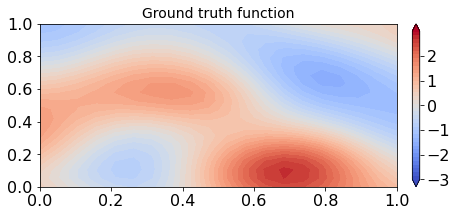

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gpytorch/utils/pinverse.py:14: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  return torch.triangular_solve(Q.transpose(-1, -2), R).solution
  4%|▍         | 2/50 [00:00<00:09,  5.15it/s]

x0:  [[0.418670654296875, 0.4148872494697571]] , a:  [[[0.4366726577281952, 0.4370013475418091]], [[0.4415625035762787, 0.43270599842071533]], [[0.4401269853115082, 0.4332934617996216]], [[0.44115155935287476, 0.4177350401878357]], [[0.41909757256507874, 0.431574285030365]]] , loss:  0.6388501358189415


 26%|██▌       | 13/50 [00:01<00:02, 12.96it/s]

x0:  [[0.43564170598983765, 0.43348249793052673]] , a:  [[[0.47089555859565735, 0.47101134061813354]], [[0.47355398535728455, 0.468664288520813]], [[0.4727928638458252, 0.4689941108226776]], [[0.473341703414917, 0.4590283930301666]], [[0.4593557119369507, 0.4680219292640686]]] , loss:  0.5739001291173701


 42%|████▏     | 21/50 [00:02<00:03,  9.22it/s]

x0:  [[0.44376859068870544, 0.44289630651474]] , a:  [[[0.4873499274253845, 0.487486869096756]], [[0.4884665608406067, 0.4865158200263977]], [[0.4881455898284912, 0.48665106296539307]], [[0.4883727431297302, 0.48240894079208374]], [[0.48234376311302185, 0.4862327575683594]]] , loss:  0.5315018946653172


 64%|██████▍   | 32/50 [00:03<00:02,  7.16it/s]

x0:  [[0.4468774199485779, 0.44653698801994324]] , a:  [[[0.4936598539352417, 0.4937964975833893]], [[0.4941466450691223, 0.49338552355766296]], [[0.4940029978752136, 0.4934403896331787]], [[0.49409252405166626, 0.4918016493320465]], [[0.49170488119125366, 0.49324122071266174]]] , loss:  0.5140043557123259


 84%|████████▍ | 42/50 [00:05<00:01,  6.79it/s]

x0:  [[0.4481045603752136, 0.4479476809501648]] , a:  [[[0.49615317583084106, 0.4962671399116516]], [[0.4964081943035126, 0.4960578978061676]], [[0.4963306486606598, 0.4960843324661255]], [[0.4963686466217041, 0.49534252285957336]], [[0.4952639937400818, 0.49596506357192993]]] , loss:  0.5070878256160977


100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


Current optimal loss 1.083088943555356;optimal action: tensor([[0.4599, 0.4598]], grad_fn=<AddBackward0>)


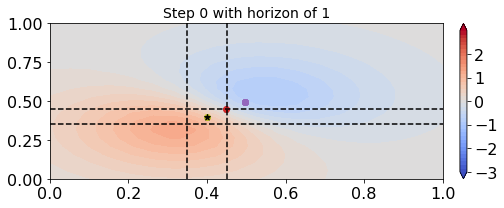

  4%|▍         | 2/50 [00:00<00:06,  7.07it/s]

x0:  [[0.4550302028656006, 0.4647592008113861]] , a:  [[[0.45549091696739197, 0.4675584137439728]], [[0.4587249755859375, 0.48461511731147766]], [[0.46989500522613525, 0.47961828112602234]], [[0.4734344780445099, 0.48066481947898865]], [[0.46225860714912415, 0.47304168343544006]]] , loss:  1.1182678180805292


 22%|██▏       | 11/50 [00:01<00:05,  6.69it/s]

x0:  [[0.4305475056171417, 0.4401273727416992]] , a:  [[[0.4075702428817749, 0.41898834705352783]], [[0.4101501405239105, 0.43596524000167847]], [[0.42064791917800903, 0.43030351400375366]], [[0.42456862330436707, 0.4314543902873993]], [[0.4132075011730194, 0.4237462878227234]]] , loss:  0.8369358196881208


 42%|████▏     | 21/50 [00:03<00:04,  6.29it/s]

x0:  [[0.4131695628166199, 0.4184415340423584]] , a:  [[[0.3754523694515228, 0.38144898414611816]], [[0.3765583038330078, 0.3910020589828491]], [[0.38222771883010864, 0.38738688826560974]], [[0.38461369276046753, 0.3880549371242523]], [[0.37819987535476685, 0.3837939500808716]]] , loss:  0.5286017993556454


 64%|██████▍   | 32/50 [00:05<00:03,  6.00it/s]

x0:  [[0.4056245684623718, 0.40766066312789917]] , a:  [[[0.361812561750412, 0.36400288343429565]], [[0.3621689975261688, 0.36777833104133606]], [[0.3644940257072449, 0.36627596616744995]], [[0.365443617105484, 0.36651337146759033]], [[0.36291995644569397, 0.36490756273269653]]] , loss:  0.3995289487203876


 84%|████████▍ | 42/50 [00:06<00:01,  6.39it/s]

x0:  [[0.4027610421180725, 0.4035640060901642]] , a:  [[[0.3565705418586731, 0.35735827684402466]], [[0.3567005693912506, 0.3589393198490143]], [[0.35775232315063477, 0.3583153188228607]], [[0.3581382632255554, 0.35840117931365967]], [[0.3570846915245056, 0.3577549457550049]]] , loss:  0.35538377835206175


100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


Current optimal loss 0.7244740813385327;optimal action: tensor([[0.4118, 0.4122]], grad_fn=<AddBackward0>)


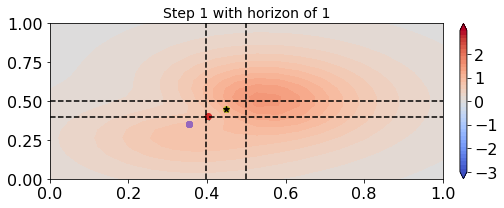

  4%|▍         | 2/50 [00:00<00:06,  7.99it/s]

x0:  [[0.40667951107025146, 0.4046001732349396]] , a:  [[[0.408338725566864, 0.4157037138938904]], [[0.4226042628288269, 0.4117691218852997]], [[0.4080878496170044, 0.42551180720329285]], [[0.41462603211402893, 0.4052262008190155]], [[0.42361629009246826, 0.41280749440193176]]] , loss:  0.7980362695597338


 24%|██▍       | 12/50 [00:01<00:06,  5.93it/s]

x0:  [[0.382660448551178, 0.3810161352157593]] , a:  [[[0.3609590530395508, 0.36757194995880127]], [[0.37402352690696716, 0.3639132082462311]], [[0.3607115149497986, 0.3780258297920227]], [[0.3662854731082916, 0.3585413992404938]], [[0.3751067519187927, 0.3648328185081482]]] , loss:  0.35184210814501793


 44%|████▍     | 22/50 [00:03<00:04,  6.14it/s]

x0:  [[0.36708685755729675, 0.36636102199554443]] , a:  [[[0.33122920989990234, 0.3350094258785248]], [[0.33845943212509155, 0.33287233114242554]], [[0.330984503030777, 0.3413267433643341]], [[0.334134578704834, 0.33012017607688904]], [[0.33909881114959717, 0.3333572447299957]]] , loss:  0.11121438909464502


 64%|██████▍   | 32/50 [00:05<00:03,  5.22it/s]

x0:  [[0.3603108823299408, 0.3600715696811676]] , a:  [[[0.3184284567832947, 0.3203178644180298]], [[0.3218524158000946, 0.3192562460899353]], [[0.318248987197876, 0.3231875002384186]], [[0.3198755085468292, 0.3179490566253662]], [[0.3221360146999359, 0.3194798231124878]]] , loss:  0.030485650362986404


 86%|████████▌ | 43/50 [00:07<00:00,  9.48it/s]

x0:  [[0.35744616389274597, 0.3574053943157196]] , a:  [[[0.31298646330833435, 0.31403374671936035]], [[0.31479325890541077, 0.31346744298934937]], [[0.31286895275115967, 0.31539466977119446]], [[0.31379464268684387, 0.3127436935901642]], [[0.3149273097515106, 0.31358540058135986]]] , loss:  0.001241825982467315


100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Current optimal loss 0.31734422475677665;optimal action: tensor([[0.3652, 0.3652]], grad_fn=<AddBackward0>)


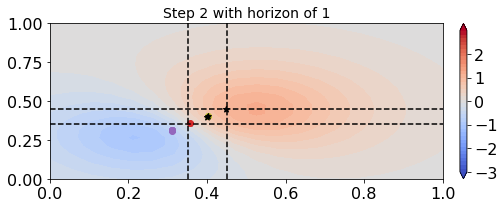

  4%|▍         | 2/50 [00:00<00:03, 14.51it/s]

x0:  [[0.3771805167198181, 0.37637585401535034]] , a:  [[[0.388475239276886, 0.38043013215065]], [[0.37962019443511963, 0.3768429458141327]], [[0.3878837823867798, 0.388997882604599]], [[0.3860572278499603, 0.3782373070716858]], [[0.3824816346168518, 0.3848697245121002]]] , loss:  0.4968044196492931


 28%|██▊       | 14/50 [00:00<00:02, 14.85it/s]

x0:  [[0.35357052087783813, 0.352621465921402]] , a:  [[[0.3405230641365051, 0.33310580253601074]], [[0.33276718854904175, 0.330253541469574]], [[0.3399325907230377, 0.3408447802066803]], [[0.33827242255210876, 0.3313315808773041]], [[0.3351083993911743, 0.33696845173835754]]] , loss:  0.06939286214057276


 44%|████▍     | 22/50 [00:01<00:01, 14.72it/s]

x0:  [[0.3327927887439728, 0.3321499824523926]] , a:  [[[0.30255433917045593, 0.29818594455718994]], [[0.2981979548931122, 0.2966723144054413]], [[0.3021484911441803, 0.30259424448013306]], [[0.3012680113315582, 0.29722878336906433]], [[0.2994493544101715, 0.30038559436798096]]] , loss:  -0.13282611054328525


 64%|██████▍   | 32/50 [00:02<00:01, 14.67it/s]

x0:  [[0.321880966424942, 0.3215026259422302]] , a:  [[[0.2838072180747986, 0.28137633204460144]], [[0.28146761655807495, 0.2805531322956085]], [[0.2835700809955597, 0.28371697664260864]], [[0.283132404088974, 0.28085532784461975]], [[0.28214383125305176, 0.28257355093955994]]] , loss:  -0.19193241705886738


 84%|████████▍ | 42/50 [00:02<00:00, 12.67it/s]

x0:  [[0.3169720470905304, 0.31670430302619934]] , a:  [[[0.2755162715911865, 0.2739287316799164]], [[0.2740531265735626, 0.2733904719352722]], [[0.2753742039203644, 0.2753615379333496]], [[0.2751067876815796, 0.273592084646225]], [[0.2744927704334259, 0.27467626333236694]]] , loss:  -0.21110109790587597


100%|██████████| 50/50 [00:03<00:00, 13.85it/s]


Current optimal loss -0.07627824913498166;optimal action: tensor([[0.3227, 0.3225]], grad_fn=<AddBackward0>)


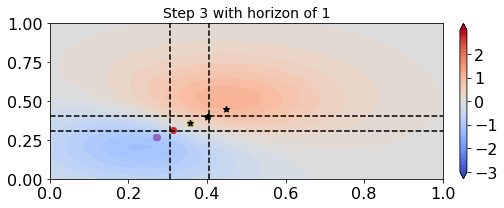

  4%|▍         | 2/50 [00:00<00:03, 14.79it/s]

x0:  [[0.3245631456375122, 0.3196483850479126]] , a:  [[[0.3334190249443054, 0.33768635988235474]], [[0.34124279022216797, 0.3314190208911896]], [[0.34350210428237915, 0.32257819175720215]], [[0.33104822039604187, 0.33140531182289124]], [[0.3382114768028259, 0.3196656405925751]]] , loss:  0.011672764064519753


 24%|██▍       | 12/50 [00:00<00:02, 14.15it/s]

x0:  [[0.3005542457103729, 0.2961605489253998]] , a:  [[[0.28548067808151245, 0.2903114855289459]], [[0.29321110248565674, 0.28382408618927]], [[0.29571980237960815, 0.2759961485862732]], [[0.2834116816520691, 0.2838503420352936]], [[0.2901213765144348, 0.273714542388916]]] , loss:  -0.3279638200875314


 48%|████▊     | 24/50 [00:01<00:01, 14.42it/s]

x0:  [[0.28491297364234924, 0.2820510268211365]] , a:  [[[0.25459539890289307, 0.25731033086776733]], [[0.2593628466129303, 0.2532106935977936]], [[0.2610442042350769, 0.24860958755016327]], [[0.25346753001213074, 0.25331416726112366]], [[0.25754985213279724, 0.24736303091049194]]] , loss:  -0.4364331706770582


 64%|██████▍   | 32/50 [00:02<00:01, 14.55it/s]

x0:  [[0.2782094478607178, 0.27607718110084534]] , a:  [[[0.24144689738750458, 0.24208314716815948]], [[0.24419927597045898, 0.23979461193084717]], [[0.24516484141349792, 0.23711611330509186]], [[0.24083389341831207, 0.23989523947238922]], [[0.24325019121170044, 0.23638947308063507]]] , loss:  -0.4587527985535422


 84%|████████▍ | 42/50 [00:02<00:00, 14.71it/s]

x0:  [[0.2754455804824829, 0.2735044062137604]] , a:  [[[0.236038476228714, 0.23540230095386505]], [[0.2378765493631363, 0.2339751273393631]], [[0.23849506676197052, 0.23216649889945984]], [[0.23563683032989502, 0.23404982686042786]], [[0.2372991144657135, 0.2316586971282959]]] , loss:  -0.46435951720025


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


Current optimal loss -0.3747735054938683;optimal action: tensor([[0.2816, 0.2796]], grad_fn=<AddBackward0>)


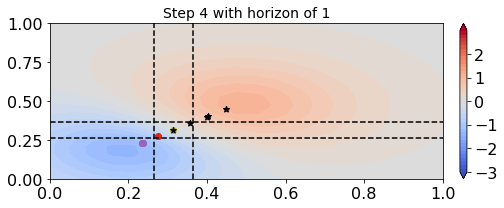

  6%|▌         | 3/50 [00:00<00:04, 10.28it/s]

x0:  [[0.28865665197372437, 0.2750093638896942]] , a:  [[[0.30759942531585693, 0.2892536520957947]], [[0.292172908782959, 0.28870177268981934]], [[0.3081603944301605, 0.2762901782989502]], [[0.2913624048233032, 0.29732146859169006]], [[0.30800849199295044, 0.29177165031433105]]] , loss:  -0.2880362264413776


 26%|██▌       | 13/50 [00:01<00:02, 14.12it/s]

x0:  [[0.26490646600723267, 0.252328097820282]] , a:  [[[0.2603742480278015, 0.2428397834300995]], [[0.24568340182304382, 0.2423580139875412]], [[0.2610503137111664, 0.23131264746189117]], [[0.24496585130691528, 0.2517883777618408]], [[0.2608211040496826, 0.24544279277324677]]] , loss:  -0.5012284256914615


 46%|████▌     | 23/50 [00:01<00:01, 13.97it/s]

x0:  [[0.24946065247058868, 0.24033288657665253]] , a:  [[[0.22759929299354553, 0.21517102420330048]], [[0.21856249868869781, 0.21506668627262115]], [[0.22818435728549957, 0.20817026495933533]], [[0.21796447038650513, 0.22117428481578827]], [[0.22784768044948578, 0.21680667996406555]]] , loss:  -0.5427857172375338


 66%|██████▌   | 33/50 [00:02<00:01, 14.07it/s]

x0:  [[0.24379922449588776, 0.23601621389389038]] , a:  [[[0.21494527161121368, 0.20463240146636963]], [[0.20930324494838715, 0.20475806295871735]], [[0.215462788939476, 0.20016075670719147]], [[0.2087165117263794, 0.20829768478870392]], [[0.21504278481006622, 0.20560318231582642]]] , loss:  -0.5438866559375419


 86%|████████▌ | 43/50 [00:03<00:00, 14.32it/s]

x0:  [[0.24264849722385406, 0.23469869792461395]] , a:  [[[0.2120019644498825, 0.20139913260936737]], [[0.20786340534687042, 0.20167037844657898]], [[0.21256105601787567, 0.19805815815925598]], [[0.20719972252845764, 0.2039875090122223]], [[0.21201761066913605, 0.2020624727010727]]] , loss:  -0.5431673535580556


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]


Current optimal loss -0.5282633734427209;optimal action: tensor([[0.2498, 0.2418]], grad_fn=<AddBackward0>)


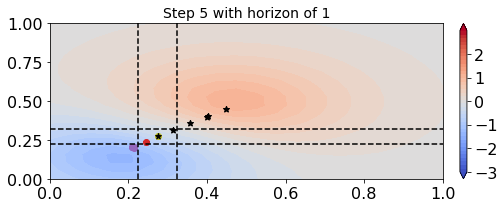

  4%|▍         | 2/50 [00:00<00:03, 14.32it/s]

x0:  [[0.26542094349861145, 0.24798530340194702]] , a:  [[[0.26596584916114807, 0.253174364566803]], [[0.27940085530281067, 0.261467307806015]], [[0.28006523847579956, 0.26413264870643616]], [[0.2820473909378052, 0.25426098704338074]], [[0.26959067583084106, 0.25767290592193604]]] , loss:  -0.4466359492280324


 24%|██▍       | 12/50 [00:00<00:02, 14.52it/s]

x0:  [[0.24275119602680206, 0.224477156996727]] , a:  [[[0.22140857577323914, 0.20690220594406128]], [[0.23308628797531128, 0.21435412764549255]], [[0.23373909294605255, 0.21705247461795807]], [[0.2358275204896927, 0.20773397386074066]], [[0.22425636649131775, 0.2108067274093628]]] , loss:  -0.5854503696753252


 44%|████▍     | 22/50 [00:01<00:02, 13.53it/s]

x0:  [[0.2272970974445343, 0.2110268473625183]] , a:  [[[0.1968214064836502, 0.18250364065170288]], [[0.20347075164318085, 0.18670475482940674]], [[0.2038055658340454, 0.18833895027637482]], [[0.20526467263698578, 0.18271619081497192]], [[0.1983659565448761, 0.1847408264875412]]] , loss:  -0.5981498475785684


 64%|██████▍   | 32/50 [00:02<00:01, 13.33it/s]

x0:  [[0.2247554212808609, 0.2076781988143921]] , a:  [[[0.1938752382993698, 0.17712347209453583]], [[0.19762197136878967, 0.1793651133775711]], [[0.19773195683956146, 0.18030063807964325]], [[0.19884967803955078, 0.1768786609172821]], [[0.19467468559741974, 0.1784050464630127]]] , loss:  -0.5954915012650928


 84%|████████▍ | 42/50 [00:03<00:00, 14.01it/s]

x0:  [[0.22892269492149353, 0.20889659225940704]] , a:  [[[0.20160292088985443, 0.18022559583187103]], [[0.20328986644744873, 0.1811855137348175]], [[0.20324230194091797, 0.18174001574516296]], [[0.20426617562770844, 0.17952673137187958]], [[0.20176298916339874, 0.18087820708751678]]] , loss:  -0.5977844751474163


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


Current optimal loss -0.5990842503034622;optimal action: tensor([[0.2387, 0.2162]], grad_fn=<AddBackward0>)


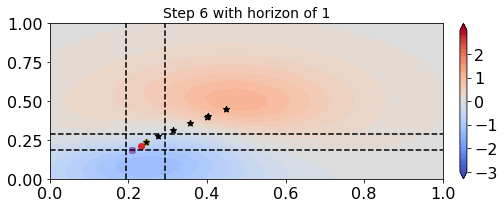

  8%|▊         | 4/50 [00:00<00:03, 14.84it/s]

x0:  [[0.25442594289779663, 0.2293694019317627]] , a:  [[[0.26320889592170715, 0.23535633087158203]], [[0.2551082968711853, 0.23816291987895966]], [[0.2743811309337616, 0.2434752732515335]], [[0.2621939182281494, 0.24213248491287231]], [[0.2642059028148651, 0.2417467087507248]]] , loss:  -0.5212193325123905


 24%|██▍       | 12/50 [00:00<00:02, 14.26it/s]

x0:  [[0.23308929800987244, 0.2054305374622345]] , a:  [[[0.21984700858592987, 0.18766823410987854]], [[0.2140519917011261, 0.19015255570411682]], [[0.23049820959568024, 0.19525034725666046]], [[0.2190271019935608, 0.19389605522155762]], [[0.22066740691661835, 0.19351714849472046]]] , loss:  -0.6522301942836127


 44%|████▍     | 22/50 [00:01<00:01, 14.59it/s]

x0:  [[0.23157578706741333, 0.18639181554317474]] , a:  [[[0.21687829494476318, 0.15424735844135284]], [[0.2177472561597824, 0.15567265450954437]], [[0.21855857968330383, 0.15855054557323456]], [[0.21668975055217743, 0.15779808163642883]], [[0.21671438217163086, 0.15756933391094208]]] , loss:  -0.6937522635668413


 64%|██████▍   | 32/50 [00:02<00:01, 11.93it/s]

x0:  [[0.23983147740364075, 0.17784789204597473]] , a:  [[[0.23221281170845032, 0.14014558494091034]], [[0.23536241054534912, 0.14096270501613617]], [[0.22821961343288422, 0.14250251650810242]], [[0.2325010746717453, 0.1421215981245041]], [[0.23171305656433105, 0.14199517667293549]]] , loss:  -0.6997412819557823


 84%|████████▍ | 42/50 [00:03<00:00, 13.82it/s]

x0:  [[0.23755523562431335, 0.17477107048034668]] , a:  [[[0.22744876146316528, 0.135165274143219]], [[0.22682589292526245, 0.13572992384433746]], [[0.2258237600326538, 0.13673906028270721]], [[0.22739993035793304, 0.13649927079677582]], [[0.22736799716949463, 0.13641692698001862]]] , loss:  -0.7003356649032061


100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


Current optimal loss -0.7076328434577283;optimal action: tensor([[0.2462, 0.1819]], grad_fn=<AddBackward0>)


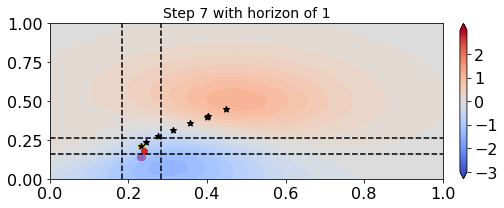

  4%|▍         | 2/50 [00:00<00:03, 14.27it/s]

x0:  [[0.24120068550109863, 0.18305188417434692]] , a:  [[[0.25453901290893555, 0.18769562244415283]], [[0.2420690655708313, 0.19678300619125366]], [[0.2593117654323578, 0.20213797688484192]], [[0.25841403007507324, 0.2018139362335205]], [[0.26427266001701355, 0.20095491409301758]]] , loss:  -0.6711062297834466


 24%|██▍       | 12/50 [00:00<00:02, 14.37it/s]

x0:  [[0.252949982881546, 0.15960396826267242]] , a:  [[[0.27680152654647827, 0.14118042588233948]], [[0.27306076884269714, 0.1493818312883377]], [[0.27661070227622986, 0.15505050122737885]], [[0.2768707871437073, 0.15468838810920715]], [[0.27402764558792114, 0.1537470519542694]]] , loss:  -0.776758358954458


 44%|████▍     | 22/50 [00:01<00:01, 14.35it/s]

x0:  [[0.24749362468719482, 0.1461205929517746]] , a:  [[[0.26511144638061523, 0.1153043657541275]], [[0.27103573083877563, 0.11997503787279129]], [[0.2634943127632141, 0.12336763739585876]], [[0.2637779712677002, 0.12314686179161072]], [[0.26318129897117615, 0.12254896014928818]]] , loss:  -0.8005001509126064


 64%|██████▍   | 32/50 [00:02<00:01, 14.27it/s]

x0:  [[0.2495957762002945, 0.14134520292282104]] , a:  [[[0.26869410276412964, 0.10662522166967392]], [[0.2709161341190338, 0.10927960276603699]], [[0.2705870270729065, 0.11101461946964264]], [[0.27019667625427246, 0.11090482026338577]], [[0.2723430395126343, 0.11058421432971954]]] , loss:  -0.8012003562930886


 84%|████████▍ | 42/50 [00:02<00:00, 14.20it/s]

x0:  [[0.24697765707969666, 0.14019785821437836]] , a:  [[[0.26726821064949036, 0.10517080128192902]], [[0.26538026332855225, 0.10687075555324554]], [[0.2671687602996826, 0.10785592347383499]], [[0.2672605812549591, 0.10779530555009842]], [[0.266526460647583, 0.10761046409606934]]] , loss:  -0.8007736158090009


100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


Current optimal loss -0.7722821052569294;optimal action: tensor([[0.2555, 0.1467]], grad_fn=<AddBackward0>)


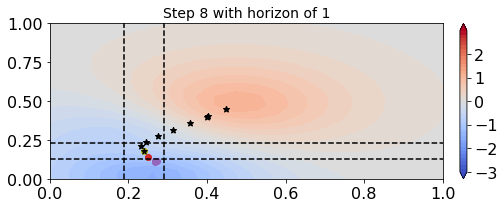

  4%|▍         | 2/50 [00:00<00:03, 14.51it/s]

x0:  [[0.2605495750904083, 0.14449185132980347]] , a:  [[[0.27676302194595337, 0.16021528840065002]], [[0.2813248634338379, 0.15632328391075134]], [[0.2677941918373108, 0.15731792151927948]], [[0.2670121490955353, 0.15133067965507507]], [[0.2673090100288391, 0.14456745982170105]]] , loss:  -0.768006251479381


 24%|██▍       | 12/50 [00:00<00:02, 14.21it/s]

x0:  [[0.2545963525772095, 0.12573595345020294]] , a:  [[[0.2704990804195404, 0.12045642733573914]], [[0.265878289937973, 0.11748520284891129]], [[0.2690281867980957, 0.11826864629983902]], [[0.269767701625824, 0.11468528211116791]], [[0.2688267230987549, 0.11283542215824127]]] , loss:  -0.7831797543087905


 44%|████▍     | 22/50 [00:01<00:01, 14.67it/s]

x0:  [[0.2551387846469879, 0.12766820192337036]] , a:  [[[0.26785117387771606, 0.1200287789106369]], [[0.2709423303604126, 0.12093829363584518]], [[0.2695305347442627, 0.12066204100847244]], [[0.26908770203590393, 0.12320305407047272]], [[0.26979050040245056, 0.12775734066963196]]] , loss:  -0.7843630373128485


 64%|██████▍   | 32/50 [00:02<00:01, 14.00it/s]

x0:  [[0.25471895933151245, 0.130865216255188]] , a:  [[[0.27051350474357605, 0.12759767472743988]], [[0.2685773968696594, 0.1293008029460907]], [[0.2690967917442322, 0.1288413405418396]], [[0.26923254132270813, 0.13081161677837372]], [[0.2692129611968994, 0.13099044561386108]]] , loss:  -0.7843583105914326


 84%|████████▍ | 42/50 [00:02<00:00, 14.08it/s]

x0:  [[0.2545340061187744, 0.1281067132949829]] , a:  [[[0.26838335394859314, 0.12491245567798615]], [[0.2696496844291687, 0.12449485063552856]], [[0.26944929361343384, 0.124669149518013]], [[0.2696773409843445, 0.12318655103445053]], [[0.2692883312702179, 0.1208135187625885]]] , loss:  -0.7845714774545748


100%|██████████| 50/50 [00:03<00:00, 14.02it/s]


Current optimal loss -0.7820644799575819;optimal action: tensor([[0.2611, 0.1323]], grad_fn=<AddBackward0>)


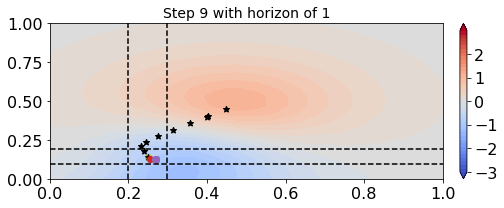

  4%|▍         | 2/50 [00:00<00:03, 14.15it/s]

x0:  [[0.26016658544540405, 0.1421421468257904]] , a:  [[[0.279097318649292, 0.1645311862230301]], [[0.2713027596473694, 0.14951421320438385]], [[0.2705720067024231, 0.14826446771621704]], [[0.27909842133522034, 0.15006636083126068]], [[0.2757302224636078, 0.1468629539012909]]] , loss:  -0.7692783056116006


 24%|██▍       | 12/50 [00:00<00:02, 13.81it/s]

x0:  [[0.2560432553291321, 0.12384480237960815]] , a:  [[[0.2683737277984619, 0.125244602560997]], [[0.2713044285774231, 0.11454463005065918]], [[0.2714020013809204, 0.11416461318731308]], [[0.26717257499694824, 0.11470116674900055]], [[0.26990383863449097, 0.11380644887685776]]] , loss:  -0.7817378598189411


 44%|████▍     | 22/50 [00:01<00:02, 12.45it/s]

x0:  [[0.25562137365341187, 0.12866051495075226]] , a:  [[[0.2698493003845215, 0.12273479998111725]], [[0.26824113726615906, 0.1275867521762848]], [[0.2681085765361786, 0.1283877044916153]], [[0.2704455852508545, 0.12729915976524353]], [[0.2689140737056732, 0.12938828766345978]]] , loss:  -0.7836504326023532


 68%|██████▊   | 34/50 [00:02<00:01, 14.54it/s]

x0:  [[0.2549326717853546, 0.12916353344917297]] , a:  [[[0.26755839586257935, 0.12430379539728165]], [[0.26869845390319824, 0.12891560792922974]], [[0.26884397864341736, 0.12890402972698212]], [[0.26746833324432373, 0.1289203017950058]], [[0.26864373683929443, 0.1287994682788849]]] , loss:  -0.7836575899644052


 84%|████████▍ | 42/50 [00:03<00:00, 14.42it/s]

x0:  [[0.2547135353088379, 0.12731295824050903]] , a:  [[[0.268253892660141, 0.12554572522640228]], [[0.26783013343811035, 0.12381140887737274]], [[0.26770898699760437, 0.1234593465924263]], [[0.26843273639678955, 0.12390976399183273]], [[0.26754510402679443, 0.1230410635471344]]] , loss:  -0.7836867089530748


100%|██████████| 50/50 [00:03<00:00, 13.75it/s]


Current optimal loss -0.7735199557597493;optimal action: tensor([[0.2613, 0.1329]], grad_fn=<AddBackward0>)


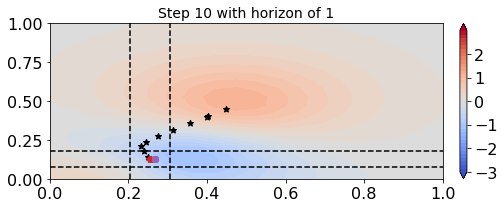

  4%|▍         | 2/50 [00:00<00:03, 13.92it/s]

x0:  [[0.2702765166759491, 0.13523820042610168]] , a:  [[[0.2872314751148224, 0.1515350490808487]], [[0.2926361858844757, 0.1500190794467926]], [[0.27742546796798706, 0.13688766956329346]], [[0.28063932061195374, 0.14480580389499664]], [[0.27782103419303894, 0.15519264340400696]]] , loss:  -0.7373420392203488


 24%|██▍       | 12/50 [00:00<00:02, 13.99it/s]

x0:  [[0.24755741655826569, 0.1133868396282196]] , a:  [[[0.2415757179260254, 0.10716666281223297]], [[0.24742132425308228, 0.10587967932224274]], [[0.23275308310985565, 0.09602776169776917]], [[0.23543095588684082, 0.10123400390148163]], [[0.233380988240242, 0.11073373258113861]]] , loss:  -0.7909740595787843


 44%|████▍     | 22/50 [00:01<00:02, 13.56it/s]

x0:  [[0.24053919315338135, 0.10856495052576065]] , a:  [[[0.22518093883991241, 0.09511303901672363]], [[0.22714875638484955, 0.09575878083705902]], [[0.2227385938167572, 0.0965266227722168]], [[0.22345882654190063, 0.09452027082443237]], [[0.22457927465438843, 0.09489515423774719]]] , loss:  -0.7879505331729328


 64%|██████▍   | 32/50 [00:02<00:01, 14.18it/s]

x0:  [[0.2470589280128479, 0.1133563369512558]] , a:  [[[0.23600097000598907, 0.1053704172372818]], [[0.2347860187292099, 0.10681882500648499]], [[0.23874008655548096, 0.11140679568052292]], [[0.237737774848938, 0.10789228975772858]], [[0.24019940197467804, 0.10293620824813843]]] , loss:  -0.791745496006859


 84%|████████▍ | 42/50 [00:03<00:00, 12.05it/s]

x0:  [[0.24929790198802948, 0.1142347902059555]] , a:  [[[0.24087120592594147, 0.1086740791797638]], [[0.23951680958271027, 0.10851405560970306]], [[0.24338723719120026, 0.10816141963005066]], [[0.24248860776424408, 0.10949824750423431]], [[0.24210414290428162, 0.10818998515605927]]] , loss:  -0.7914950907658584


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


Current optimal loss -0.7854549718364204;optimal action: tensor([[0.2540, 0.1160]], grad_fn=<AddBackward0>)


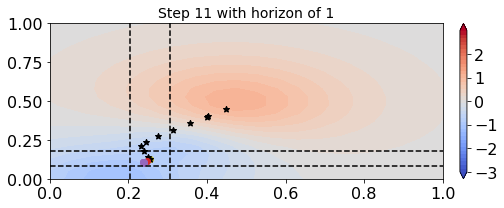

  4%|▍         | 2/50 [00:00<00:03, 14.43it/s]

x0:  [[0.26678261160850525, 0.11422781646251678]] , a:  [[[0.2675365209579468, 0.13085246086120605]], [[0.28592073917388916, 0.12333168089389801]], [[0.28588688373565674, 0.13284343481063843]], [[0.28462326526641846, 0.12760493159294128]], [[0.26800447702407837, 0.13705399632453918]]] , loss:  -0.7551849526874481


 24%|██▍       | 12/50 [00:00<00:02, 14.00it/s]

x0:  [[0.24521133303642273, 0.09990717470645905]] , a:  [[[0.22763274610042572, 0.10275282710790634]], [[0.241887167096138, 0.1048882007598877]], [[0.24182039499282837, 0.10327049344778061]], [[0.2405562549829483, 0.10338923335075378]], [[0.2279529720544815, 0.10466735064983368]]] , loss:  -0.7873920186856858


 44%|████▍     | 22/50 [00:01<00:01, 14.14it/s]

x0:  [[0.2428511381149292, 0.10415920615196228]] , a:  [[[0.232862651348114, 0.11325105279684067]], [[0.23164622485637665, 0.11688335239887238]], [[0.23142041265964508, 0.1133957952260971]], [[0.23126854002475739, 0.11569757759571075]], [[0.23291604220867157, 0.10957968235015869]]] , loss:  -0.787772890191913


 64%|██████▍   | 32/50 [00:02<00:01, 14.19it/s]

x0:  [[0.2497875839471817, 0.10166332125663757]] , a:  [[[0.24926982820034027, 0.11002178490161896]], [[0.24241845309734344, 0.10719892382621765]], [[0.24213922023773193, 0.10975006967782974]], [[0.24271583557128906, 0.10837684571743011]], [[0.24901169538497925, 0.11103490740060806]]] , loss:  -0.7886582983648986


 84%|████████▍ | 42/50 [00:02<00:00, 14.21it/s]

x0:  [[0.24764320254325867, 0.10308796912431717]] , a:  [[[0.24027158319950104, 0.11237205564975739]], [[0.2403278648853302, 0.11236099898815155]], [[0.24037180840969086, 0.1120418980717659]], [[0.2405947893857956, 0.11212775856256485]], [[0.24014712870121002, 0.113141268491745]]] , loss:  -0.7893729352628462


100%|██████████| 50/50 [00:03<00:00, 13.79it/s]


Current optimal loss -0.7856470382972495;optimal action: tensor([[0.2528, 0.1046]], grad_fn=<AddBackward0>)


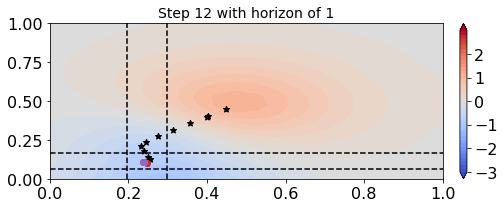

  6%|▌         | 3/50 [00:00<00:04, 10.12it/s]

x0:  [[0.2546524107456207, 0.10948427766561508]] , a:  [[[0.27296799421310425, 0.12032324075698853]], [[0.26384595036506653, 0.11047922074794769]], [[0.27460977435112, 0.11605646461248398]], [[0.26731690764427185, 0.11970333755016327]], [[0.27507638931274414, 0.11588659137487411]]] , loss:  -0.7709134426421749


 26%|██▌       | 13/50 [00:01<00:02, 14.08it/s]

x0:  [[0.23462706804275513, 0.10663800686597824]] , a:  [[[0.2326115369796753, 0.11186149716377258]], [[0.2275899052619934, 0.10778462141752243]], [[0.23400868475437164, 0.11455630511045456]], [[0.22891947627067566, 0.11203228682279587]], [[0.23441992700099945, 0.11463509500026703]]] , loss:  -0.7876161940683086


 46%|████▌     | 23/50 [00:01<00:01, 14.19it/s]

x0:  [[0.23714525997638702, 0.10568507760763168]] , a:  [[[0.2369222790002823, 0.11139810085296631]], [[0.24123211205005646, 0.11429381370544434]], [[0.2365054488182068, 0.10987694561481476]], [[0.23931947350502014, 0.11137185990810394]], [[0.23638150095939636, 0.10984426736831665]]] , loss:  -0.7891902289731972


 66%|██████▌   | 33/50 [00:02<00:01, 14.13it/s]

x0:  [[0.24007122218608856, 0.10566794872283936]] , a:  [[[0.24418334662914276, 0.1109689250588417]], [[0.24619822204113007, 0.11020158976316452]], [[0.24355120956897736, 0.11175017058849335]], [[0.24570955336093903, 0.11103375256061554]], [[0.2433745265007019, 0.11175589263439178]]] , loss:  -0.7890156896131544


 86%|████████▌ | 43/50 [00:03<00:00, 13.50it/s]

x0:  [[0.23669187724590302, 0.10526012629270554]] , a:  [[[0.2384038269519806, 0.11072948575019836]], [[0.23641741275787354, 0.11043399572372437]], [[0.23858283460140228, 0.11042123287916183]], [[0.23730133473873138, 0.11078815162181854]], [[0.23863467574119568, 0.11041178554296494]]] , loss:  -0.7892674500385185


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


Current optimal loss -0.7884062324487234;optimal action: tensor([[0.2427, 0.1080]], grad_fn=<AddBackward0>)


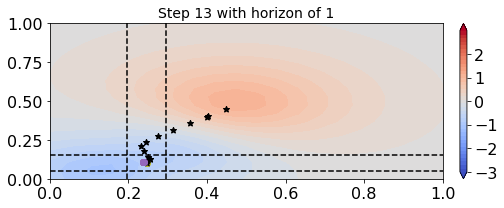

  4%|▍         | 2/50 [00:00<00:03, 14.30it/s]

x0:  [[0.2493615746498108, 0.11399227380752563]] , a:  [[[0.2611570954322815, 0.1278015673160553]], [[0.2703530490398407, 0.13488540053367615]], [[0.2602733075618744, 0.13693612813949585]], [[0.26107028126716614, 0.13190674781799316]], [[0.2521827220916748, 0.13253989815711975]]] , loss:  -0.7729358808915135


 24%|██▍       | 12/50 [00:00<00:02, 14.08it/s]

x0:  [[0.2388041615486145, 0.09788528829813004]] , a:  [[[0.24119611084461212, 0.10134843736886978]], [[0.24178941547870636, 0.10183843970298767]], [[0.24066248536109924, 0.1035301461815834]], [[0.24086470901966095, 0.10161015391349792]], [[0.24542248249053955, 0.10206165909767151]]] , loss:  -0.7865836358968017


 48%|████▊     | 24/50 [00:01<00:01, 13.09it/s]

x0:  [[0.24219238758087158, 0.10349132120609283]] , a:  [[[0.24928972125053406, 0.1165766566991806]], [[0.24505582451820374, 0.11340942233800888]], [[0.24987176060676575, 0.11217114329338074]], [[0.24950678646564484, 0.11478642374277115]], [[0.2505498230457306, 0.1138651892542839]]] , loss:  -0.7878825958878934


 64%|██████▍   | 32/50 [00:02<00:01, 14.20it/s]

x0:  [[0.23956401646137238, 0.10080363601446152]] , a:  [[[0.24369661509990692, 0.10890528559684753]], [[0.2461390197277069, 0.11026446521282196]], [[0.24414238333702087, 0.10925371944904327]], [[0.24394191801548004, 0.10917824506759644]], [[0.24191011488437653, 0.10895636677742004]]] , loss:  -0.7883313360656615


 84%|████████▍ | 42/50 [00:03<00:00, 13.72it/s]

x0:  [[0.241288959980011, 0.10135786235332489]] , a:  [[[0.24737563729286194, 0.10998716950416565]], [[0.24721764028072357, 0.11012399196624756]], [[0.2467869073152542, 0.11133250594139099]], [[0.24707911908626556, 0.1104765385389328]], [[0.2479756623506546, 0.11126485466957092]]] , loss:  -0.78847676080964


100%|██████████| 50/50 [00:03<00:00, 13.60it/s]


Current optimal loss -0.7878083530476526;optimal action: tensor([[0.2468, 0.1041]], grad_fn=<AddBackward0>)


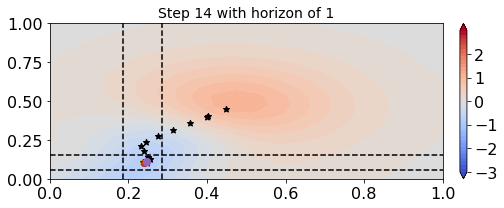

  4%|▍         | 2/50 [00:00<00:03, 14.38it/s]

x0:  [[0.24457290768623352, 0.11157742887735367]] , a:  [[[0.2506583631038666, 0.12930378317832947]], [[0.2485203742980957, 0.13283994793891907]], [[0.25450053811073303, 0.13026516139507294]], [[0.26244789361953735, 0.13336516916751862]], [[0.24464181065559387, 0.12075809389352798]]] , loss:  -0.7798314251077857


 24%|██▍       | 12/50 [00:00<00:02, 13.83it/s]

x0:  [[0.23851551115512848, 0.09725165367126465]] , a:  [[[0.24886351823806763, 0.10199544578790665]], [[0.2493932545185089, 0.10279911756515503]], [[0.24635049700737, 0.10191091895103455]], [[0.24138903617858887, 0.10277358442544937]], [[0.24372749030590057, 0.1051006019115448]]] , loss:  -0.787204798527431


 44%|████▍     | 22/50 [00:01<00:01, 14.40it/s]

x0:  [[0.23845252394676208, 0.10306517034769058]] , a:  [[[0.24453479051589966, 0.11545342206954956]], [[0.24423715472221375, 0.11351639032363892]], [[0.24601928889751434, 0.1149553433060646]], [[0.24740439653396606, 0.11290937662124634]], [[0.24681654572486877, 0.11787298321723938]]] , loss:  -0.7881101034770223


 64%|██████▍   | 32/50 [00:02<00:01, 14.18it/s]

x0:  [[0.23782488703727722, 0.09924479573965073]] , a:  [[[0.2454570084810257, 0.10822993516921997]], [[0.24550113081932068, 0.10880035161972046]], [[0.244631826877594, 0.10844650864601135]], [[0.2449066936969757, 0.10912744700908661]], [[0.245944082736969, 0.10562455654144287]]] , loss:  -0.7884084500929873


 84%|████████▍ | 42/50 [00:02<00:00, 13.90it/s]

x0:  [[0.23819975554943085, 0.10123288631439209]] , a:  [[[0.24582374095916748, 0.11179155111312866]], [[0.24599961936473846, 0.11216652393341064]], [[0.246230348944664, 0.11184360831975937]], [[0.24576348066329956, 0.11216561496257782]], [[0.24512548744678497, 0.11235298216342926]]] , loss:  -0.7885129359704433


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


Current optimal loss -0.7877657002976958;optimal action: tensor([[0.2441, 0.1034]], grad_fn=<AddBackward0>)


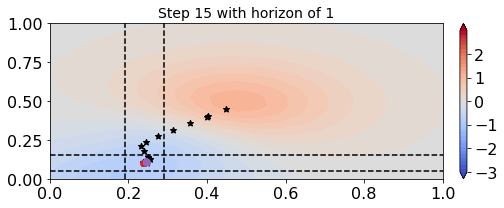

  4%|▍         | 2/50 [00:00<00:03, 14.57it/s]

x0:  [[0.24632929265499115, 0.11390288174152374]] , a:  [[[0.2499072551727295, 0.13534685969352722]], [[0.24936522543430328, 0.12057572603225708]], [[0.25600680708885193, 0.1314801424741745]], [[0.268967866897583, 0.11450836062431335]], [[0.2616850733757019, 0.11518101394176483]]] , loss:  -0.7782611071834481


 24%|██▍       | 12/50 [00:00<00:02, 13.59it/s]

x0:  [[0.23684942722320557, 0.10210531949996948]] , a:  [[[0.24924631416797638, 0.10519538819789886]], [[0.2487967163324356, 0.10699921101331711]], [[0.2442219853401184, 0.10358718037605286]], [[0.24127842485904694, 0.11435963213443756]], [[0.24044236540794373, 0.11322329193353653]]] , loss:  -0.7877098705312846


 44%|████▍     | 22/50 [00:01<00:02, 13.87it/s]

x0:  [[0.23651248216629028, 0.10373996943235397]] , a:  [[[0.24236227571964264, 0.10895118117332458]], [[0.2432784140110016, 0.1150226891040802]], [[0.24594512581825256, 0.11152537167072296]], [[0.24262401461601257, 0.10756005346775055]], [[0.24669183790683746, 0.109300397336483]]] , loss:  -0.7883548862659222


 64%|██████▍   | 32/50 [00:02<00:01, 14.04it/s]

x0:  [[0.23766161501407623, 0.1040315106511116]] , a:  [[[0.2465655505657196, 0.11272238194942474]], [[0.24604661762714386, 0.10825076699256897]], [[0.24472004175186157, 0.11236227303743362]], [[0.24814090132713318, 0.112285315990448]], [[0.24561285972595215, 0.11111725866794586]]] , loss:  -0.7884868586185803


 84%|████████▍ | 42/50 [00:03<00:00, 13.97it/s]

x0:  [[0.23657307028770447, 0.10284408181905746]] , a:  [[[0.24504873156547546, 0.1096637174487114]], [[0.2450997680425644, 0.11065511405467987]], [[0.2457457184791565, 0.10867208242416382]], [[0.24413737654685974, 0.10989163815975189]], [[0.2444571554660797, 0.11031180620193481]]] , loss:  -0.788595544294476


100%|██████████| 50/50 [00:03<00:00, 13.63it/s]


Current optimal loss -0.78811634606916;optimal action: tensor([[0.2425, 0.1057]], grad_fn=<AddBackward0>)


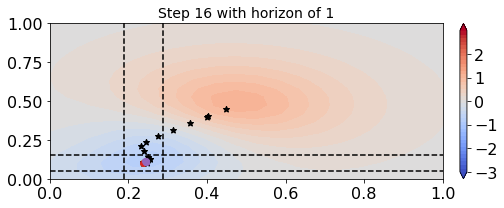

  4%|▍         | 2/50 [00:00<00:03, 13.75it/s]

x0:  [[0.24737602472305298, 0.10500472784042358]] , a:  [[[0.2678261399269104, 0.11311201751232147]], [[0.2503584921360016, 0.11008217185735703]], [[0.25897783041000366, 0.12154887616634369]], [[0.2698374092578888, 0.12178705632686615]], [[0.25465503334999084, 0.12565544247627258]]] , loss:  -0.7779109473971767


 24%|██▍       | 12/50 [00:00<00:02, 13.21it/s]

x0:  [[0.23575986921787262, 0.09818655252456665]] , a:  [[[0.23950667679309845, 0.11535915732383728]], [[0.24642454087734222, 0.11021380871534348]], [[0.24042657017707825, 0.11003118008375168]], [[0.24021252989768982, 0.11151467263698578]], [[0.2435240000486374, 0.10701454430818558]]] , loss:  -0.7878538199558193


 44%|████▍     | 22/50 [00:01<00:02, 13.71it/s]

x0:  [[0.23791582882404327, 0.09744110703468323]] , a:  [[[0.24504324793815613, 0.10662835091352463]], [[0.247214213013649, 0.11095955967903137]], [[0.24869556725025177, 0.11092865467071533]], [[0.24385039508342743, 0.10913559049367905]], [[0.24819299578666687, 0.11209553480148315]]] , loss:  -0.7883715294334684


 64%|██████▍   | 32/50 [00:02<00:01, 14.25it/s]

x0:  [[0.23699812591075897, 0.09740011394023895]] , a:  [[[0.24681372940540314, 0.11200213432312012]], [[0.24322795867919922, 0.11018477380275726]], [[0.2442251741886139, 0.10923561453819275]], [[0.24724772572517395, 0.110283762216568]], [[0.24350763857364655, 0.10943272709846497]]] , loss:  -0.7885050909803886


 84%|████████▍ | 42/50 [00:03<00:00, 13.84it/s]

x0:  [[0.2367331087589264, 0.09759889543056488]] , a:  [[[0.24415811896324158, 0.10992681235074997]], [[0.24611631035804749, 0.11049021780490875]], [[0.2446296215057373, 0.1113465279340744]], [[0.24437487125396729, 0.11100946366786957]], [[0.24543701112270355, 0.11076106131076813]]] , loss:  -0.7885967118186568


100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


Current optimal loss -0.7864784386884223;optimal action: tensor([[0.2436, 0.0997]], grad_fn=<AddBackward0>)


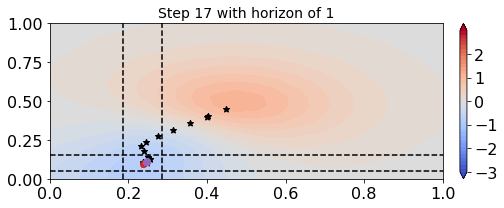

  4%|▍         | 2/50 [00:00<00:03, 13.99it/s]

x0:  [[0.23898927867412567, 0.10359631478786469]] , a:  [[[0.25669825077056885, 0.12650839984416962]], [[0.24007058143615723, 0.12007082998752594]], [[0.2480890154838562, 0.12135007977485657]], [[0.2553820013999939, 0.12206380069255829]], [[0.23998898267745972, 0.12590685486793518]]] , loss:  -0.7837611456738738


 24%|██▍       | 12/50 [00:00<00:02, 14.39it/s]

x0:  [[0.2347538024187088, 0.09561874717473984]] , a:  [[[0.2413347214460373, 0.10737811028957367]], [[0.24694469571113586, 0.11049787700176239]], [[0.24500131607055664, 0.10980558395385742]], [[0.2422388792037964, 0.10960042476654053]], [[0.2473037987947464, 0.10765662789344788]]] , loss:  -0.7883365403251172


 44%|████▍     | 22/50 [00:01<00:02, 13.94it/s]

x0:  [[0.23536726832389832, 0.09603545814752579]] , a:  [[[0.2472051978111267, 0.11002571880817413]], [[0.24393579363822937, 0.11101159453392029]], [[0.245565727353096, 0.11077573895454407]], [[0.24685606360435486, 0.11039717495441437]], [[0.24343241751194, 0.11023746430873871]]] , loss:  -0.788537992349485


 64%|██████▍   | 32/50 [00:02<00:01, 13.46it/s]

x0:  [[0.23515820503234863, 0.09614042937755585]] , a:  [[[0.24449774622917175, 0.11205065250396729]], [[0.24633511900901794, 0.11019231379032135]], [[0.2454344630241394, 0.11059124767780304]], [[0.24462689459323883, 0.11102020740509033]], [[0.24681784212589264, 0.11158031225204468]]] , loss:  -0.7885752803730544


 84%|████████▍ | 42/50 [00:03<00:00, 14.09it/s]

x0:  [[0.234796941280365, 0.09524541348218918]] , a:  [[[0.24573399126529694, 0.10874845087528229]], [[0.24481476843357086, 0.11019507050514221]], [[0.24506720900535583, 0.10992266237735748]], [[0.2456531673669815, 0.10963447391986847]], [[0.24440570175647736, 0.10926187038421631]]] , loss:  -0.7885965016143769


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


Current optimal loss -0.7854974019116141;optimal action: tensor([[0.2409, 0.0980]], grad_fn=<AddBackward0>)


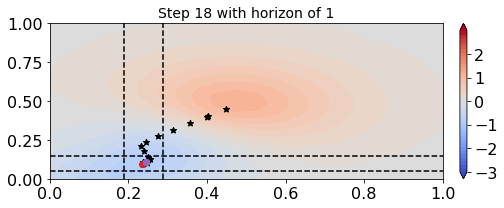

  4%|▍         | 2/50 [00:00<00:03, 14.00it/s]

x0:  [[0.25157052278518677, 0.10452711582183838]] , a:  [[[0.27011460065841675, 0.1065087616443634]], [[0.26302647590637207, 0.11056236177682877]], [[0.27011144161224365, 0.11656578630208969]], [[0.2644212245941162, 0.12693917751312256]], [[0.25536489486694336, 0.12419426441192627]]] , loss:  -0.7738816068277174


 24%|██▍       | 12/50 [00:00<00:02, 14.20it/s]

x0:  [[0.23761194944381714, 0.09700964391231537]] , a:  [[[0.23826049268245697, 0.11568374931812286]], [[0.23714329302310944, 0.108988918364048]], [[0.2381870448589325, 0.11417727172374725]], [[0.23709197342395782, 0.10641694068908691]], [[0.24062645435333252, 0.10696117579936981]]] , loss:  -0.7865366519004657


 44%|████▍     | 22/50 [00:01<00:01, 14.09it/s]

x0:  [[0.24330992996692657, 0.0968681201338768]] , a:  [[[0.24698162078857422, 0.10766597092151642]], [[0.25067293643951416, 0.11194318532943726]], [[0.24697375297546387, 0.10846599191427231]], [[0.2500818371772766, 0.11236953735351562]], [[0.25235500931739807, 0.11349219083786011]]] , loss:  -0.7877703141072447


 64%|██████▍   | 32/50 [00:02<00:01, 13.89it/s]

x0:  [[0.23992931842803955, 0.09575645625591278]] , a:  [[[0.24399973452091217, 0.11080437898635864]], [[0.24270255863666534, 0.11063273251056671]], [[0.2440711259841919, 0.1106133908033371]], [[0.2430168092250824, 0.10948358476161957]], [[0.24033130705356598, 0.10842646658420563]]] , loss:  -0.7883225112542481


 84%|████████▍ | 42/50 [00:02<00:00, 13.70it/s]

x0:  [[0.24197860062122345, 0.09643813222646713]] , a:  [[[0.24690400063991547, 0.11105930805206299]], [[0.2463712990283966, 0.11008933186531067]], [[0.24685756862163544, 0.11085395514965057]], [[0.2463887333869934, 0.11092773079872131]], [[0.2473132610321045, 0.11131787300109863]]] , loss:  -0.7885271698604412


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]


Current optimal loss -0.7859399680868838;optimal action: tensor([[0.2472, 0.0984]], grad_fn=<AddBackward0>)


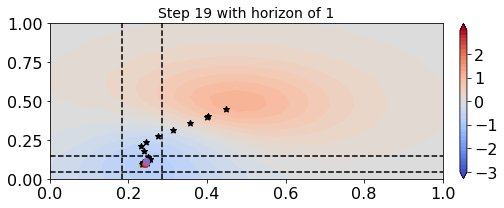

-------------------- Ground truth surface --------------------


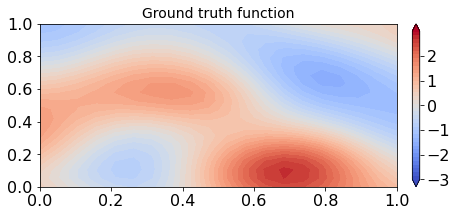

  4%|▍         | 2/50 [00:00<00:03, 12.46it/s]

x0:  [[0.40333887934684753, 0.4057529866695404]] , a:  [[[0.41059646010398865, 0.40920406579971313]], [[0.4084432125091553, 0.42759668827056885]], [[0.41960233449935913, 0.40805619955062866]], [[0.41104960441589355, 0.4206489026546478]], [[0.41234272718429565, 0.4283383786678314]]] , loss:  0.6567921306546662


 24%|██▍       | 12/50 [00:00<00:02, 13.64it/s]

x0:  [[0.4258672595024109, 0.4276384115219116]] , a:  [[[0.454488605260849, 0.45350366830825806]], [[0.4529133439064026, 0.4650976359844208]], [[0.46024760603904724, 0.45260027050971985]], [[0.45481160283088684, 0.46120136976242065]], [[0.4557040333747864, 0.46548697352409363]]] , loss:  0.5975686023360116


 44%|████▍     | 22/50 [00:01<00:02, 13.90it/s]

x0:  [[0.4397721290588379, 0.4404601454734802]] , a:  [[[0.48087048530578613, 0.48029136657714844]], [[0.4801933765411377, 0.48515114188194275]], [[0.48326417803764343, 0.4798860251903534]], [[0.4810151159763336, 0.4835684597492218]], [[0.4814019501209259, 0.48530781269073486]]] , loss:  0.5421720145393832


 64%|██████▍   | 32/50 [00:02<00:01, 14.16it/s]

x0:  [[0.44544169306755066, 0.445609986782074]] , a:  [[[0.49146395921707153, 0.49112480878829956]], [[0.49124425649642944, 0.4929850697517395]], [[0.4923614263534546, 0.49099230766296387]], [[0.49153006076812744, 0.49234214425086975]], [[0.49168097972869873, 0.4930534362792969]]] , loss:  0.5177053414712545


 84%|████████▍ | 42/50 [00:03<00:00, 13.87it/s]

x0:  [[0.4475078582763672, 0.4475279450416565]] , a:  [[[0.4953116774559021, 0.495093435049057]], [[0.49524009227752686, 0.49594002962112427]], [[0.49571123719215393, 0.4950506091117859]], [[0.4953509569168091, 0.4956226646900177]], [[0.4954223930835724, 0.49597764015197754]]] , loss:  0.5085088575434394


100%|██████████| 50/50 [00:03<00:00, 13.18it/s]


Current optimal loss 1.07956442766543;optimal action: tensor([[0.4596, 0.4596]], grad_fn=<AddBackward0>)


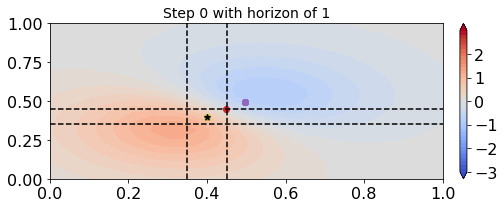

  4%|▍         | 2/50 [00:00<00:03, 13.27it/s]

x0:  [[0.4537135064601898, 0.4712742269039154]] , a:  [[[0.45704594254493713, 0.4850766956806183]], [[0.47133946418762207, 0.47446778416633606]], [[0.4557654857635498, 0.4724106192588806]], [[0.46411556005477905, 0.49019622802734375]], [[0.47061312198638916, 0.48783963918685913]]] , loss:  1.1234739145019272


 28%|██▊       | 14/50 [00:00<00:02, 14.66it/s]

x0:  [[0.4293529689311981, 0.44792860746383667]] , a:  [[[0.4086586534976959, 0.4370458424091339]], [[0.4224652945995331, 0.4271051585674286]], [[0.4076312780380249, 0.42543303966522217]], [[0.4149467945098877, 0.44291070103645325]], [[0.421664297580719, 0.4401743710041046]]] , loss:  0.8599600294497936


 48%|████▊     | 24/50 [00:01<00:01, 14.59it/s]

x0:  [[0.41233018040657043, 0.4235305190086365]] , a:  [[[0.3755917251110077, 0.3917747735977173]], [[0.38325709104537964, 0.38639289140701294]], [[0.3751918375492096, 0.3857024908065796]], [[0.37877848744392395, 0.395405650138855]], [[0.3826693296432495, 0.39360949397087097]]] , loss:  0.543026283457564


 64%|██████▍   | 32/50 [00:02<00:01, 14.04it/s]

x0:  [[0.40502867102622986, 0.4096190929412842]] , a:  [[[0.36153745651245117, 0.36782026290893555]], [[0.3647005558013916, 0.36564895510673523]], [[0.3614445924758911, 0.3654603958129883]], [[0.3627870976924896, 0.36920976638793945]], [[0.3643668293952942, 0.36845752596855164]]] , loss:  0.40232104727183726


 84%|████████▍ | 42/50 [00:02<00:00, 14.47it/s]

x0:  [[0.4022830128669739, 0.4042103886604309]] , a:  [[[0.35621699690818787, 0.3586963713169098]], [[0.3576355278491974, 0.3577318787574768]], [[0.35620322823524475, 0.3576797842979431]], [[0.35677260160446167, 0.3592316210269928]], [[0.3574558198451996, 0.3589189946651459]]] , loss:  0.35442111428371353


100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


Current optimal loss 0.7762131605937387;optimal action: tensor([[0.4113, 0.4124]], grad_fn=<AddBackward0>)


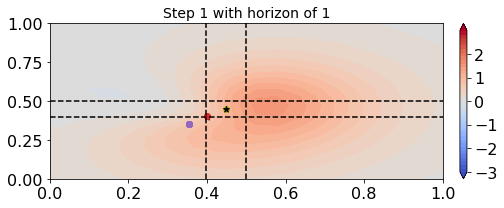

  4%|▍         | 2/50 [00:00<00:03, 13.14it/s]

x0:  [[0.4080958664417267, 0.4035322964191437]] , a:  [[[0.4258157014846802, 0.4085226058959961]], [[0.41954001784324646, 0.4112827181816101]], [[0.41631364822387695, 0.40953415632247925]], [[0.43062835931777954, 0.40410298109054565]], [[0.41439011693000793, 0.4222666621208191]]] , loss:  0.797655999107592


 24%|██▍       | 12/50 [00:00<00:03, 11.69it/s]

x0:  [[0.38376185297966003, 0.38021141290664673]] , a:  [[[0.3770468235015869, 0.3612358868122101]], [[0.3705601394176483, 0.3636512756347656]], [[0.3675713837146759, 0.3621326982975006]], [[0.38270559906959534, 0.357642263174057]], [[0.3658076524734497, 0.3746887147426605]]] , loss:  0.34879551316572355


 48%|████▊     | 24/50 [00:01<00:01, 14.23it/s]

x0:  [[0.3673977851867676, 0.36602428555488586]] , a:  [[[0.3399425446987152, 0.33150357007980347]], [[0.33612027764320374, 0.3328578472137451]], [[0.33450591564178467, 0.33206573128700256]], [[0.34363871812820435, 0.3295796513557434]], [[0.3333740532398224, 0.33931630849838257]]] , loss:  0.10364986725840993


 64%|██████▍   | 32/50 [00:02<00:01, 13.84it/s]

x0:  [[0.36027538776397705, 0.359974205493927]] , a:  [[[0.32247427105903625, 0.31860435009002686]], [[0.32070258259773254, 0.31928256154060364]], [[0.31995582580566406, 0.318916380405426]], [[0.32417479157447815, 0.3176349103450775]], [[0.3193127512931824, 0.32226669788360596]]] , loss:  0.021995237721910123


 84%|████████▍ | 42/50 [00:03<00:00, 14.24it/s]

x0:  [[0.35731327533721924, 0.3574047088623047]] , a:  [[[0.315123051404953, 0.3131099343299866]], [[0.3142361342906952, 0.31348562240600586]], [[0.31384411454200745, 0.313291072845459]], [[0.31591570377349854, 0.31255391240119934]], [[0.3134611248970032, 0.31495919823646545]]] , loss:  -0.007341880575861537


100%|██████████| 50/50 [00:03<00:00, 13.52it/s]


Current optimal loss 0.315350038996059;optimal action: tensor([[0.3650, 0.3653]], grad_fn=<AddBackward0>)


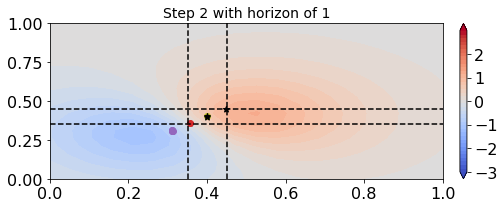

  4%|▍         | 2/50 [00:00<00:03, 14.19it/s]

x0:  [[0.37751054763793945, 0.3752095103263855]] , a:  [[[0.39499324560165405, 0.39656853675842285]], [[0.3804715573787689, 0.3889637589454651]], [[0.39244741201400757, 0.391081303358078]], [[0.38173428177833557, 0.38011467456817627]], [[0.3884701728820801, 0.39673689007759094]]] , loss:  0.5566282549566935


 24%|██▍       | 12/50 [00:00<00:02, 13.83it/s]

x0:  [[0.35399681329727173, 0.3512292206287384]] , a:  [[[0.3472631871700287, 0.348961740732193]], [[0.33363428711891174, 0.34064438939094543]], [[0.3445829749107361, 0.34279826283454895]], [[0.3347087502479553, 0.3324846029281616]], [[0.34061479568481445, 0.34918105602264404]]] , loss:  0.11816923407274396


 46%|████▌     | 23/50 [00:02<00:02, 10.00it/s]

x0:  [[0.333238422870636, 0.330993115901947]] , a:  [[[0.3069441020488739, 0.30743762850761414]], [[0.29908064007759094, 0.3022465407848358]], [[0.3053792119026184, 0.303495317697525]], [[0.29975107312202454, 0.2975190579891205]], [[0.3029293417930603, 0.3076375126838684]]] , loss:  -0.10457479563662886


 64%|██████▍   | 32/50 [00:03<00:02,  9.00it/s]

x0:  [[0.32253801822662354, 0.32063594460487366]] , a:  [[[0.2868748903274536, 0.2858160734176636]], [[0.282683402299881, 0.28322404623031616]], [[0.2861168086528778, 0.28384846448898315]], [[0.28309690952301025, 0.28072604537010193]], [[0.2847551107406616, 0.28593534231185913]]] , loss:  -0.17007071115627936


 84%|████████▍ | 42/50 [00:04<00:00,  9.90it/s]

x0:  [[0.31783390045166016, 0.3160167634487152]] , a:  [[[0.2782098650932312, 0.27619466185569763]], [[0.27559059858322144, 0.27477577328681946]], [[0.2777838110923767, 0.27514058351516724]], [[0.2758743166923523, 0.2732805907726288]], [[0.2769257724285126, 0.27625271677970886]]] , loss:  -0.19088434700747198


100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


Current optimal loss -0.07686290611310365;optimal action: tensor([[0.3238, 0.3219]], grad_fn=<AddBackward0>)


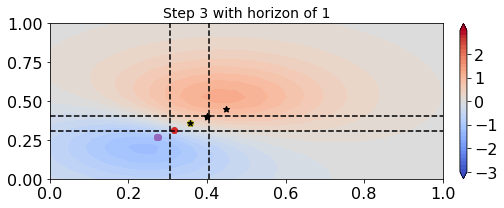

  4%|▍         | 2/50 [00:00<00:03, 14.18it/s]

x0:  [[0.31793490052223206, 0.3340516686439514]] , a:  [[[0.3243025541305542, 0.33621829748153687]], [[0.3383174538612366, 0.3502877652645111]], [[0.3200223445892334, 0.3542698919773102]], [[0.33571740984916687, 0.34944358468055725]], [[0.33633679151535034, 0.3495452105998993]]] , loss:  0.0955294332850741


 24%|██▍       | 12/50 [00:00<00:02, 14.07it/s]

x0:  [[0.29491445422172546, 0.3103593587875366]] , a:  [[[0.2777791917324066, 0.2894771993160248]], [[0.2916984558105469, 0.3024071156978607]], [[0.2740993797779083, 0.3068811297416687]], [[0.2887716591358185, 0.30152592062950134]], [[0.28945350646972656, 0.3016301989555359]]] , loss:  -0.2742991083375469


 44%|████▍     | 22/50 [00:01<00:01, 14.01it/s]

x0:  [[0.28212130069732666, 0.29022490978240967]] , a:  [[[0.251288503408432, 0.25597989559173584]], [[0.2595989406108856, 0.263484925031662]], [[0.24881291389465332, 0.2664640545845032]], [[0.25772643089294434, 0.26296183466911316]], [[0.2581592798233032, 0.26302090287208557]]] , loss:  -0.42102832863698814


 64%|██████▍   | 32/50 [00:02<00:01, 13.58it/s]

x0:  [[0.2773262858390808, 0.27991777658462524]] , a:  [[[0.24126262962818146, 0.24006015062332153]], [[0.2459152787923813, 0.24416358768939972]], [[0.23941712081432343, 0.24574540555477142]], [[0.2448853701353073, 0.24389882385730743]], [[0.2451276183128357, 0.24392762780189514]]] , loss:  -0.45547526881195183


 84%|████████▍ | 42/50 [00:03<00:00, 14.01it/s]

x0:  [[0.27564936876296997, 0.2753162086009979]] , a:  [[[0.23782473802566528, 0.23302747309207916]], [[0.24090854823589325, 0.23563627898693085]], [[0.23620741069316864, 0.2365279644727707]], [[0.24024862051010132, 0.23548154532909393]], [[0.24040775001049042, 0.23549829423427582]]] , loss:  -0.46475897736978544


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]


Current optimal loss -0.3711508753137128;optimal action: tensor([[0.2822, 0.2804]], grad_fn=<AddBackward0>)


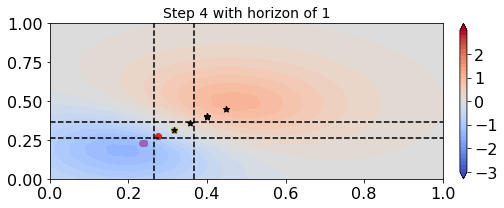

  4%|▍         | 2/50 [00:00<00:03, 14.39it/s]

x0:  [[0.29786160588264465, 0.2830679416656494]] , a:  [[[0.32054683566093445, 0.29592716693878174]], [[0.3080589175224304, 0.2860961854457855]], [[0.3166024684906006, 0.30288442969322205]], [[0.3133535385131836, 0.298383891582489]], [[0.30387258529663086, 0.3011339604854584]]] , loss:  -0.23111321337980567


 24%|██▍       | 12/50 [00:00<00:02, 13.75it/s]

x0:  [[0.2750539481639862, 0.2592741847038269]] , a:  [[[0.27481529116630554, 0.24821507930755615]], [[0.2616092264652252, 0.23947849869728088]], [[0.27018335461616516, 0.2556088864803314]], [[0.2667236328125, 0.25072285532951355]], [[0.2577970325946808, 0.2536832392215729]]] , loss:  -0.47896172294706363


 44%|████▍     | 22/50 [00:01<00:02, 13.65it/s]

x0:  [[0.25708845257759094, 0.2443414330482483]] , a:  [[[0.23812638223171234, 0.21729224920272827]], [[0.2299133986234665, 0.21214619278907776]], [[0.23490358889102936, 0.2220817506313324]], [[0.23282229900360107, 0.21895107626914978]], [[0.227322518825531, 0.22092118859291077]]] , loss:  -0.5392249390625246


 64%|██████▍   | 32/50 [00:02<00:01, 14.01it/s]

x0:  [[0.2506836950778961, 0.23820006847381592]] , a:  [[[0.22429171204566956, 0.20438392460346222]], [[0.2195223867893219, 0.20126353204250336]], [[0.2221810668706894, 0.2072257101535797]], [[0.22105473279953003, 0.2054365575313568]], [[0.21740683913230896, 0.2066321074962616]]] , loss:  -0.5433832719159359


 84%|████████▍ | 42/50 [00:03<00:00, 13.97it/s]

x0:  [[0.25075265765190125, 0.23582683503627777]] , a:  [[[0.2231709063053131, 0.1993827372789383]], [[0.22001323103904724, 0.19715140759944916]], [[0.221455380320549, 0.20131751894950867]], [[0.22078809142112732, 0.20015008747577667]], [[0.2178344428539276, 0.20097942650318146]]] , loss:  -0.5440264018186941


100%|██████████| 50/50 [00:03<00:00, 13.57it/s]


Current optimal loss -0.5352500327258127;optimal action: tensor([[0.2585, 0.2413]], grad_fn=<AddBackward0>)


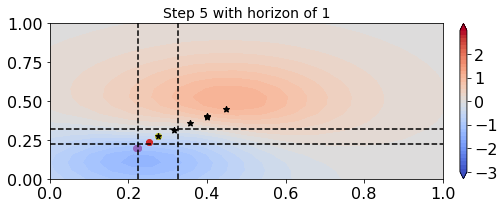

  4%|▍         | 2/50 [00:00<00:03, 13.28it/s]

x0:  [[0.26874294877052307, 0.23792725801467896]] , a:  [[[0.279964417219162, 0.24272441864013672]], [[0.2848716676235199, 0.24843022227287292]], [[0.2860218286514282, 0.25736144185066223]], [[0.28975698351860046, 0.2527022361755371]], [[0.27007073163986206, 0.25816044211387634]]] , loss:  -0.4721967820757447


 24%|██▍       | 12/50 [00:00<00:03, 12.53it/s]

x0:  [[0.24565395712852478, 0.21508201956748962]] , a:  [[[0.2339308261871338, 0.1968703716993332]], [[0.2385769486427307, 0.2018793225288391]], [[0.2396668940782547, 0.21102699637413025]], [[0.24381130933761597, 0.2060195505619049]], [[0.22550618648529053, 0.21197925508022308]]] , loss:  -0.622020920641133


 44%|████▍     | 22/50 [00:01<00:01, 14.07it/s]

x0:  [[0.2350379377603531, 0.20274265110492706]] , a:  [[[0.21490395069122314, 0.17210134863853455]], [[0.21684226393699646, 0.17500972747802734]], [[0.21687322854995728, 0.18063758313655853]], [[0.21938084065914154, 0.17745725810527802]], [[0.20985673367977142, 0.18135644495487213]]] , loss:  -0.6437628477365906


 64%|██████▍   | 32/50 [00:02<00:01, 14.32it/s]

x0:  [[0.23889701068401337, 0.1982085406780243]] , a:  [[[0.2236040234565735, 0.16317780315876007]], [[0.22334790229797363, 0.16491785645484924]], [[0.22243821620941162, 0.16810350120067596]], [[0.2236444354057312, 0.16630443930625916]], [[0.22089926898479462, 0.16854989528656006]]] , loss:  -0.6479613785882105


 84%|████████▍ | 42/50 [00:03<00:00, 14.07it/s]

x0:  [[0.2459559440612793, 0.1967221349477768]] , a:  [[[0.23774604499340057, 0.16051672399044037]], [[0.23630452156066895, 0.16171593964099884]], [[0.23506289720535278, 0.16375789046287537]], [[0.23530833423137665, 0.16261453926563263]], [[0.23746009171009064, 0.16405244171619415]]] , loss:  -0.6490675916714668


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


Current optimal loss -0.6580666074987856;optimal action: tensor([[0.2497, 0.2022]], grad_fn=<AddBackward0>)


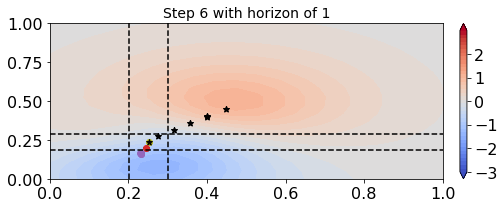

  4%|▍         | 2/50 [00:00<00:03, 12.60it/s]

x0:  [[0.2581469416618347, 0.20926810801029205]] , a:  [[[0.28016555309295654, 0.21950310468673706]], [[0.26258590817451477, 0.2101956158876419]], [[0.2629389464855194, 0.22679343819618225]], [[0.2634153664112091, 0.2226422131061554]], [[0.25857019424438477, 0.21685750782489777]]] , loss:  -0.6006254329100796


 24%|██▍       | 12/50 [00:00<00:02, 13.83it/s]

x0:  [[0.24172475934028625, 0.18523819744586945]] , a:  [[[0.24255752563476562, 0.17149333655834198]], [[0.23275567591190338, 0.16362079977989197]], [[0.23187211155891418, 0.17883554100990295]], [[0.23224160075187683, 0.17453007400035858]], [[0.23255176842212677, 0.16913719475269318]]] , loss:  -0.7165901480477104


 44%|████▍     | 22/50 [00:01<00:01, 14.07it/s]

x0:  [[0.24884551763534546, 0.1693195253610611]] , a:  [[[0.24246588349342346, 0.14030489325523376]], [[0.25063031911849976, 0.13588081300258636]], [[0.24959991872310638, 0.14470186829566956]], [[0.2496493011713028, 0.14211204648017883]], [[0.252380907535553, 0.13898685574531555]]] , loss:  -0.7467464544940091


 64%|██████▍   | 32/50 [00:02<00:01, 11.56it/s]

x0:  [[0.24617990851402283, 0.1630246639251709]] , a:  [[[0.2414173185825348, 0.1281147599220276]], [[0.2440449297428131, 0.1254894882440567]], [[0.24421976506710052, 0.13051274418830872]], [[0.2442292422056198, 0.12912358343601227]], [[0.243175208568573, 0.12734940648078918]]] , loss:  -0.7491211126483129


 84%|████████▍ | 42/50 [00:03<00:00, 13.52it/s]

x0:  [[0.2472677081823349, 0.16110961139202118]] , a:  [[[0.24734507501125336, 0.12440832704305649]], [[0.24451494216918945, 0.12254262715578079]], [[0.24469195306301117, 0.12594300508499146]], [[0.2447107881307602, 0.12507259845733643]], [[0.2441442608833313, 0.12387746572494507]]] , loss:  -0.7487688171114352


100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


Current optimal loss -0.7366803353977023;optimal action: tensor([[0.2529, 0.1676]], grad_fn=<AddBackward0>)


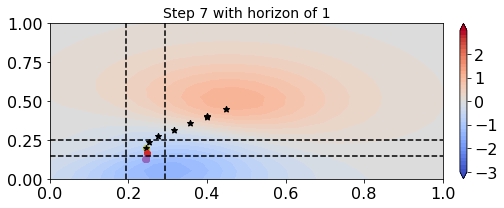

  4%|▍         | 2/50 [00:00<00:03, 14.65it/s]

x0:  [[0.25133955478668213, 0.17192216217517853]] , a:  [[[0.2602768540382385, 0.19144496321678162]], [[0.25781306624412537, 0.19275343418121338]], [[0.2656305134296417, 0.188089519739151]], [[0.2547120749950409, 0.17826972901821136]], [[0.26893994212150574, 0.17316731810569763]]] , loss:  -0.6991571336580876


 24%|██▍       | 12/50 [00:00<00:02, 13.99it/s]

x0:  [[0.24702483415603638, 0.1483888477087021]] , a:  [[[0.2600361108779907, 0.14448228478431702]], [[0.26045262813568115, 0.14597360789775848]], [[0.25652939081192017, 0.14085830748081207]], [[0.25464731454849243, 0.1316531002521515]], [[0.2539430558681488, 0.12752526998519897]]] , loss:  -0.7750957407399114


 44%|████▍     | 22/50 [00:01<00:02, 13.95it/s]

x0:  [[0.24593542516231537, 0.1352730542421341]] , a:  [[[0.2540924847126007, 0.11427506059408188]], [[0.2538548409938812, 0.11518047004938126]], [[0.256234735250473, 0.11213657259941101]], [[0.258098840713501, 0.10698240995407104]], [[0.25754594802856445, 0.10474848002195358]]] , loss:  -0.7851533282400005


 64%|██████▍   | 32/50 [00:02<00:01, 13.90it/s]

x0:  [[0.24581700563430786, 0.13189060986042023]] , a:  [[[0.25675493478775024, 0.10526643693447113]], [[0.2569515109062195, 0.10569319128990173]], [[0.2554556131362915, 0.10423758625984192]], [[0.25532203912734985, 0.10165172070264816]], [[0.25491002202033997, 0.10051380842924118]]] , loss:  -0.7837238183974395


 84%|████████▍ | 42/50 [00:02<00:00, 14.23it/s]

x0:  [[0.24572525918483734, 0.13281011581420898]] , a:  [[[0.2555198073387146, 0.10646679997444153]], [[0.25541552901268005, 0.1066376268863678]], [[0.25624141097068787, 0.10605090856552124]], [[0.25548043847084045, 0.10509305447340012]], [[0.2564770579338074, 0.10482338070869446]]] , loss:  -0.7845041070632123


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


Current optimal loss -0.7765059510106965;optimal action: tensor([[0.2518, 0.1384]], grad_fn=<AddBackward0>)


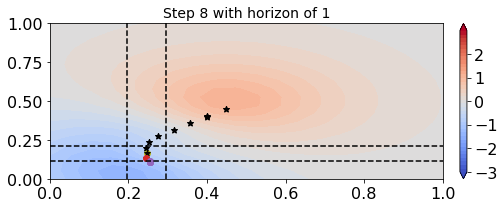

  4%|▍         | 2/50 [00:00<00:03, 12.49it/s]

x0:  [[0.2609959840774536, 0.1501755714416504]] , a:  [[[0.2805410921573639, 0.16941480338573456]], [[0.26444685459136963, 0.16147065162658691]], [[0.26701611280441284, 0.1601942628622055]], [[0.278907835483551, 0.17143678665161133]], [[0.26399415731430054, 0.16963091492652893]]] , loss:  -0.7330805768065665


 24%|██▍       | 12/50 [00:00<00:02, 13.90it/s]

x0:  [[0.24829986691474915, 0.1270466148853302]] , a:  [[[0.2488027960062027, 0.1233648955821991]], [[0.24948488175868988, 0.11554645001888275]], [[0.24793148040771484, 0.1144157201051712]], [[0.24788007140159607, 0.12561726570129395]], [[0.24983130395412445, 0.12361855804920197]]] , loss:  -0.7862938414641224


 44%|████▍     | 22/50 [00:01<00:01, 14.04it/s]

x0:  [[0.2521858811378479, 0.11618293076753616]] , a:  [[[0.25227248668670654, 0.09997375309467316]], [[0.2594131827354431, 0.09654344618320465]], [[0.2591891288757324, 0.0961102619767189]], [[0.2533056139945984, 0.10109590739011765]], [[0.25934770703315735, 0.10011227428913116]]] , loss:  -0.7851485851476676


 64%|██████▍   | 32/50 [00:02<00:01, 13.72it/s]

x0:  [[0.24994826316833496, 0.11861726641654968]] , a:  [[[0.25412121415138245, 0.10386151075363159]], [[0.2504461407661438, 0.10412003099918365]], [[0.2513112425804138, 0.1042858213186264]], [[0.2542954683303833, 0.10396905988454819]], [[0.25026735663414, 0.10385793447494507]]] , loss:  -0.7871087849433966


 84%|████████▍ | 42/50 [00:03<00:00, 13.84it/s]

x0:  [[0.2514314353466034, 0.12388777732849121]] , a:  [[[0.2553980052471161, 0.1141846626996994]], [[0.25505757331848145, 0.11622504889965057]], [[0.25452280044555664, 0.11662629246711731]], [[0.25487688183784485, 0.11375086009502411]], [[0.2552012801170349, 0.11410155892372131]]] , loss:  -0.7880246285824795


100%|██████████| 50/50 [00:03<00:00, 13.57it/s]


Current optimal loss -0.783894876211095;optimal action: tensor([[0.2575, 0.1241]], grad_fn=<AddBackward0>)


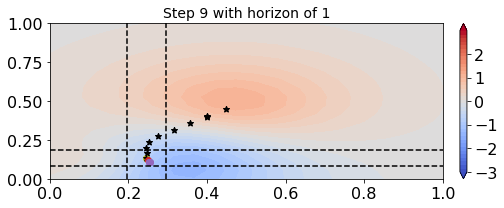

  4%|▍         | 2/50 [00:00<00:03, 13.90it/s]

x0:  [[0.27350738644599915, 0.14021947979927063]] , a:  [[[0.2850742042064667, 0.16331765055656433]], [[0.28035855293273926, 0.14508217573165894]], [[0.2958294153213501, 0.15587297081947327]], [[0.29464223980903625, 0.15910214185714722]], [[0.27694252133369446, 0.1621721386909485]]] , loss:  -0.7330941588488735


 24%|██▍       | 12/50 [00:00<00:02, 13.82it/s]

x0:  [[0.2527337074279785, 0.11809253692626953]] , a:  [[[0.24283280968666077, 0.1192464828491211]], [[0.2394786775112152, 0.10297595709562302]], [[0.2530573308467865, 0.1114702820777893]], [[0.25173845887184143, 0.11463531851768494]], [[0.23757319152355194, 0.11795118451118469]]] , loss:  -0.7852143321711063


 44%|████▍     | 22/50 [00:01<00:02, 12.41it/s]

x0:  [[0.25112834572792053, 0.11156293749809265]] , a:  [[[0.24125206470489502, 0.10205449163913727]], [[0.24182648956775665, 0.10009106993675232]], [[0.24187839031219482, 0.1000053659081459]], [[0.24158068001270294, 0.1006849929690361]], [[0.24373242259025574, 0.10156188905239105]]] , loss:  -0.7833261327077354


 64%|██████▍   | 32/50 [00:02<00:01, 13.44it/s]

x0:  [[0.2577790319919586, 0.11831791698932648]] , a:  [[[0.25506600737571716, 0.11227679252624512]], [[0.2567494511604309, 0.11922596395015717]], [[0.25068581104278564, 0.1145419180393219]], [[0.2511141300201416, 0.11347054690122604]], [[0.2583569884300232, 0.1124645322561264]]] , loss:  -0.786100630916345


 84%|████████▍ | 42/50 [00:03<00:00, 13.63it/s]

x0:  [[0.25559720396995544, 0.11993037164211273]] , a:  [[[0.25029370188713074, 0.11616110801696777]], [[0.24999554455280304, 0.11892370134592056]], [[0.24914172291755676, 0.11797738075256348]], [[0.24940353631973267, 0.11727721989154816]], [[0.24903284013271332, 0.1164429634809494]]] , loss:  -0.7863927631591752


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


Current optimal loss -0.7777704115165722;optimal action: tensor([[0.2613, 0.1220]], grad_fn=<AddBackward0>)


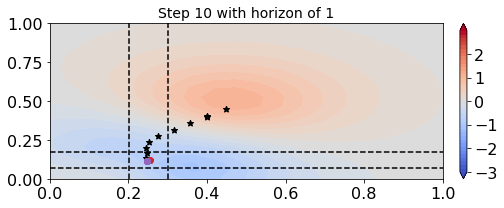

  4%|▍         | 2/50 [00:00<00:03, 13.65it/s]

x0:  [[0.26096123456954956, 0.12844404578208923]] , a:  [[[0.28005263209342957, 0.14779743552207947]], [[0.2665737271308899, 0.14271743595600128]], [[0.2673152983188629, 0.13639798760414124]], [[0.27372053265571594, 0.1429964303970337]], [[0.26703378558158875, 0.13721805810928345]]] , loss:  -0.7553621095966551


 24%|██▍       | 12/50 [00:00<00:02, 13.63it/s]

x0:  [[0.2392510175704956, 0.10616917908191681]] , a:  [[[0.23566457629203796, 0.10302961617708206]], [[0.22422443330287933, 0.09780766814947128]], [[0.2244676649570465, 0.09281110763549805]], [[0.22958123683929443, 0.09822593629360199]], [[0.2243020087480545, 0.09337810426950455]]] , loss:  -0.7958167452603176


 44%|████▍     | 22/50 [00:01<00:02, 13.54it/s]

x0:  [[0.23576578497886658, 0.10251768678426743]] , a:  [[[0.22200271487236023, 0.09101837873458862]], [[0.22194048762321472, 0.08919958770275116]], [[0.22067752480506897, 0.09031945466995239]], [[0.22081662714481354, 0.09008578956127167]], [[0.22085848450660706, 0.09003346413373947]]] , loss:  -0.793875377571381


 64%|██████▍   | 32/50 [00:02<00:01, 13.72it/s]

x0:  [[0.2416309416294098, 0.10891155153512955]] , a:  [[[0.23064255714416504, 0.10169437527656555]], [[0.23629871010780334, 0.10280145704746246]], [[0.23543775081634521, 0.10588979721069336]], [[0.23280315101146698, 0.10324729979038239]], [[0.23563611507415771, 0.10548803955316544]]] , loss:  -0.7962236976994264


 84%|████████▍ | 42/50 [00:03<00:00, 12.21it/s]

x0:  [[0.24133336544036865, 0.10814686119556427]] , a:  [[[0.23240117728710175, 0.10129934549331665]], [[0.23302969336509705, 0.10303741693496704]], [[0.2341863214969635, 0.10237310826778412]], [[0.23365724086761475, 0.10216375440359116]], [[0.23403029143810272, 0.10259662568569183]]] , loss:  -0.7964767267410648


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Current optimal loss -0.787606948145293;optimal action: tensor([[0.2471, 0.1105]], grad_fn=<AddBackward0>)


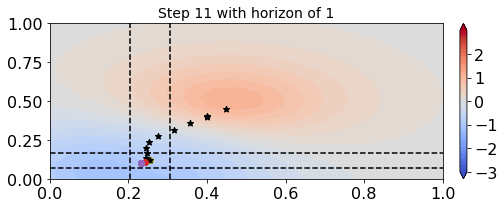

  4%|▍         | 2/50 [00:00<00:03, 13.86it/s]

x0:  [[0.2552441656589508, 0.12229785323143005]] , a:  [[[0.26364269852638245, 0.13273265957832336]], [[0.2671956717967987, 0.13686472177505493]], [[0.274413526058197, 0.13199478387832642]], [[0.25747260451316833, 0.13167697191238403]], [[0.2678534984588623, 0.13413748145103455]]] , loss:  -0.7688023588342567


 24%|██▍       | 12/50 [00:00<00:02, 13.84it/s]

x0:  [[0.23752792179584503, 0.10867249965667725]] , a:  [[[0.23032689094543457, 0.10561488568782806]], [[0.23155184090137482, 0.10603086650371552]], [[0.23571039736270905, 0.10899987816810608]], [[0.23134566843509674, 0.10467161983251572]], [[0.23156115412712097, 0.10627320408821106]]] , loss:  -0.7855260592323792


 44%|████▍     | 22/50 [00:01<00:02, 13.73it/s]

x0:  [[0.2442101240158081, 0.11379936337471008]] , a:  [[[0.2470562607049942, 0.11658437550067902]], [[0.24509018659591675, 0.1147422045469284]], [[0.24133409559726715, 0.11587702482938766]], [[0.2504722774028778, 0.11760814487934113]], [[0.2444586157798767, 0.11591556668281555]]] , loss:  -0.7879047275108201


 64%|██████▍   | 32/50 [00:02<00:01, 13.44it/s]

x0:  [[0.24207273125648499, 0.1121772974729538]] , a:  [[[0.24161382019519806, 0.11306791007518768]], [[0.24167026579380035, 0.11397148668766022]], [[0.2411385476589203, 0.11091534793376923]], [[0.23918776214122772, 0.1134285181760788]], [[0.24210458993911743, 0.11279915273189545]]] , loss:  -0.7885085477524694


 84%|████████▍ | 42/50 [00:03<00:00, 12.85it/s]

x0:  [[0.24246610701084137, 0.11222274601459503]] , a:  [[[0.24112391471862793, 0.11268690228462219]], [[0.24197788536548615, 0.11259392648935318]], [[0.24306058883666992, 0.11484691500663757]], [[0.24109351634979248, 0.11149896681308746]], [[0.24188660085201263, 0.11330091208219528]]] , loss:  -0.7885436772101452


100%|██████████| 50/50 [00:04<00:00, 12.08it/s]


Current optimal loss -0.7870348132251287;optimal action: tensor([[0.2496, 0.1156]], grad_fn=<AddBackward0>)


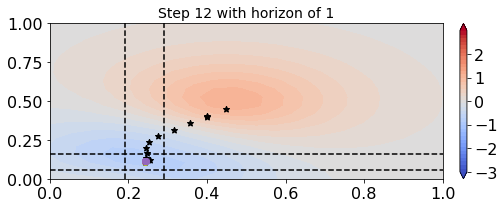

  4%|▍         | 2/50 [00:00<00:08,  5.96it/s]

x0:  [[0.2653011381626129, 0.11625902354717255]] , a:  [[[0.27429866790771484, 0.11673552542924881]], [[0.2675217390060425, 0.11827091872692108]], [[0.27566564083099365, 0.12707261741161346]], [[0.27233800292015076, 0.13240444660186768]], [[0.2692892253398895, 0.1338960826396942]]] , loss:  -0.7657126503958943


 24%|██▍       | 12/50 [00:01<00:04,  8.39it/s]

x0:  [[0.24608668684959412, 0.10398949682712555]] , a:  [[[0.23432838916778564, 0.11249962449073792]], [[0.2303646057844162, 0.11040829867124557]], [[0.23493941128253937, 0.11453044414520264]], [[0.23251241445541382, 0.10873164236545563]], [[0.23083588480949402, 0.10697657614946365]]] , loss:  -0.7862538601061152


 44%|████▍     | 22/50 [00:02<00:03,  8.02it/s]

x0:  [[0.250625878572464, 0.10523514449596405]] , a:  [[[0.23898079991340637, 0.11267358064651489]], [[0.24123525619506836, 0.11384744197130203]], [[0.23886780440807343, 0.10978960245847702]], [[0.2393244206905365, 0.11297977715730667]], [[0.240573450922966, 0.11321798712015152]]] , loss:  -0.788301313201087


 66%|██████▌   | 33/50 [00:03<00:01, 12.84it/s]

x0:  [[0.25444456934928894, 0.10657986998558044]] , a:  [[[0.24549174308776855, 0.11319956183433533]], [[0.24719443917274475, 0.11442675441503525]], [[0.2449309229850769, 0.11562605202198029]], [[0.24630236625671387, 0.11424832046031952]], [[0.24707190692424774, 0.11507774889469147]]] , loss:  -0.7879971474235156


 86%|████████▌ | 43/50 [00:04<00:00, 13.85it/s]

x0:  [[0.25115710496902466, 0.10489115118980408]] , a:  [[[0.23984670639038086, 0.11337379366159439]], [[0.2385357916355133, 0.11230876296758652]], [[0.24009473621845245, 0.11161629110574722]], [[0.23954114317893982, 0.11257494986057281]], [[0.23871153593063354, 0.11185406148433685]]] , loss:  -0.788288710696393


100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Current optimal loss -0.7842572998251867;optimal action: tensor([[0.2576, 0.1076]], grad_fn=<AddBackward0>)


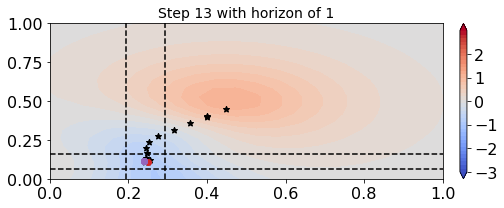

  4%|▍         | 2/50 [00:00<00:03, 13.04it/s]

x0:  [[0.2575801610946655, 0.12069399654865265]] , a:  [[[0.27988383173942566, 0.12483924627304077]], [[0.266692191362381, 0.13462036848068237]], [[0.27512866258621216, 0.12733864784240723]], [[0.2647984027862549, 0.141696035861969]], [[0.270897775888443, 0.13479819893836975]]] , loss:  -0.7578321981532763


 24%|██▍       | 12/50 [00:00<00:02, 13.86it/s]

x0:  [[0.23887600004673004, 0.10444565117359161]] , a:  [[[0.2404448240995407, 0.10137899965047836]], [[0.2327669858932495, 0.10106897354125977]], [[0.2365042120218277, 0.10089221596717834]], [[0.23306119441986084, 0.10521434992551804]], [[0.23405393958091736, 0.10129917412996292]]] , loss:  -0.7842793441044653


 44%|████▍     | 22/50 [00:01<00:02, 12.67it/s]

x0:  [[0.2433633953332901, 0.11039142310619354]] , a:  [[[0.24230334162712097, 0.11864301562309265]], [[0.24827760457992554, 0.11289262771606445]], [[0.2437770664691925, 0.11755824089050293]], [[0.25005149841308594, 0.10888487100601196]], [[0.24581673741340637, 0.1131206601858139]]] , loss:  -0.7878450821205689


 64%|██████▍   | 32/50 [00:02<00:01, 13.81it/s]

x0:  [[0.2434423416852951, 0.10834115743637085]] , a:  [[[0.24542869627475739, 0.10795797407627106]], [[0.24699272215366364, 0.11136933416128159]], [[0.24672430753707886, 0.10880562663078308]], [[0.2462877780199051, 0.11017094552516937]], [[0.2471485435962677, 0.1111169308423996]]] , loss:  -0.7883823566451265


 84%|████████▍ | 42/50 [00:03<00:00, 13.50it/s]

x0:  [[0.24159912765026093, 0.1091265007853508]] , a:  [[[0.24459350109100342, 0.11057894676923752]], [[0.2419603019952774, 0.11120028793811798]], [[0.24380937218666077, 0.11071130633354187]], [[0.24153223633766174, 0.11288975179195404]], [[0.24289433658123016, 0.111260324716568]]] , loss:  -0.7883470842943512


100%|██████████| 50/50 [00:03<00:00, 13.12it/s]


Current optimal loss -0.7880000860266718;optimal action: tensor([[0.2492, 0.1122]], grad_fn=<AddBackward0>)


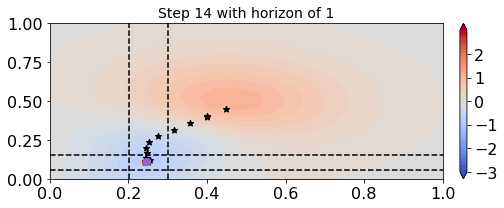

  4%|▍         | 2/50 [00:00<00:03, 13.29it/s]

x0:  [[0.2619149386882782, 0.11302778124809265]] , a:  [[[0.2845172584056854, 0.1320422738790512]], [[0.2749987244606018, 0.13106176257133484]], [[0.26292717456817627, 0.1317606270313263]], [[0.27913898229599, 0.13479666411876678]], [[0.26236966252326965, 0.11529567837715149]]] , loss:  -0.7563566630386458


 24%|██▍       | 12/50 [00:00<00:02, 13.56it/s]

x0:  [[0.2428140640258789, 0.09862561523914337]] , a:  [[[0.24371586740016937, 0.1043323278427124]], [[0.2356506884098053, 0.10337860882282257]], [[0.23217831552028656, 0.1019466370344162]], [[0.23867106437683105, 0.10401378571987152]], [[0.23176036775112152, 0.11140353977680206]]] , loss:  -0.7845723336286573


 44%|████▍     | 22/50 [00:01<00:02, 13.83it/s]

x0:  [[0.2476726919412613, 0.10220492631196976]] , a:  [[[0.24203841388225555, 0.11352115869522095]], [[0.24441346526145935, 0.11316236853599548]], [[0.2512631118297577, 0.11236296594142914]], [[0.2430296242237091, 0.11159853637218475]], [[0.25123390555381775, 0.11087409406900406]]] , loss:  -0.7878821878844064


 64%|██████▍   | 32/50 [00:02<00:01, 13.53it/s]

x0:  [[0.24802958965301514, 0.1009313315153122]] , a:  [[[0.24441495537757874, 0.10888457298278809]], [[0.24744576215744019, 0.10994473099708557]], [[0.2470494657754898, 0.11211974173784256]], [[0.2463425248861313, 0.11064291000366211]], [[0.24759504199028015, 0.11005406826734543]]] , loss:  -0.7884881848534019


 84%|████████▍ | 42/50 [00:03<00:00, 12.65it/s]

x0:  [[0.24657142162322998, 0.10053389519453049]] , a:  [[[0.24536935985088348, 0.11047288030385971]], [[0.2441447377204895, 0.11008581519126892]], [[0.2416304051876068, 0.10876356065273285]], [[0.24491268396377563, 0.1098896861076355]], [[0.24154755473136902, 0.1107635647058487]]] , loss:  -0.7884181890865603


100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


Current optimal loss -0.7843404954200999;optimal action: tensor([[0.2546, 0.1036]], grad_fn=<AddBackward0>)


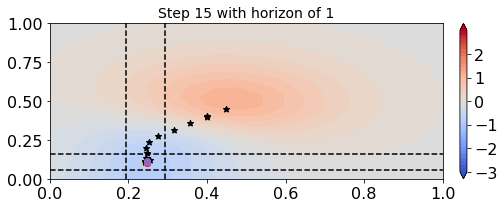

  4%|▍         | 2/50 [00:00<00:03, 12.88it/s]

x0:  [[0.25160038471221924, 0.10182920098304749]] , a:  [[[0.27066901326179504, 0.11809435486793518]], [[0.27427855134010315, 0.10442068427801132]], [[0.2727295160293579, 0.10944083333015442]], [[0.25638970732688904, 0.10234695672988892]], [[0.2672770321369171, 0.1199227124452591]]] , loss:  -0.7679190888774248


 24%|██▍       | 12/50 [00:00<00:02, 13.37it/s]

x0:  [[0.23437973856925964, 0.10087796300649643]] , a:  [[[0.23575443029403687, 0.10927291214466095]], [[0.2380625158548355, 0.11201174557209015]], [[0.2369593232870102, 0.11085876822471619]], [[0.2366361916065216, 0.11200261116027832]], [[0.2346022129058838, 0.10675542056560516]]] , loss:  -0.78569962528838


 44%|████▍     | 22/50 [00:01<00:02, 13.70it/s]

x0:  [[0.2394149899482727, 0.1014251857995987]] , a:  [[[0.24720388650894165, 0.11073646694421768]], [[0.24531233310699463, 0.10995858162641525]], [[0.2460823506116867, 0.11039312928915024]], [[0.2538601756095886, 0.11059534549713135]], [[0.24906083941459656, 0.11277052760124207]]] , loss:  -0.7879011312639977


 64%|██████▍   | 32/50 [00:02<00:01, 14.02it/s]

x0:  [[0.23731862008571625, 0.10055802762508392]] , a:  [[[0.24540600180625916, 0.11061052232980728]], [[0.24503467977046967, 0.11021744459867477]], [[0.24525633454322815, 0.1101173609495163]], [[0.24265195429325104, 0.1104850172996521]], [[0.2453135848045349, 0.10921942442655563]]] , loss:  -0.7885758559362421


 84%|████████▍ | 42/50 [00:03<00:00, 13.97it/s]

x0:  [[0.23714029788970947, 0.10061334073543549]] , a:  [[[0.24489717185497284, 0.10976862907409668]], [[0.24567364156246185, 0.11062237620353699]], [[0.24533012509346008, 0.11029710620641708]], [[0.24370291829109192, 0.10986146330833435]], [[0.24424977600574493, 0.11075776070356369]]] , loss:  -0.7886027177676487


100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


Current optimal loss -0.7877446153624333;optimal action: tensor([[0.2439, 0.1036]], grad_fn=<AddBackward0>)


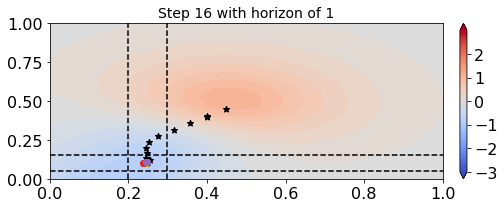

  4%|▍         | 2/50 [00:00<00:03, 12.85it/s]

x0:  [[0.25383636355400085, 0.11717577278614044]] , a:  [[[0.2651679217815399, 0.12981140613555908]], [[0.26675209403038025, 0.1402016431093216]], [[0.26793336868286133, 0.13057273626327515]], [[0.2584245800971985, 0.1329999566078186]], [[0.2651044726371765, 0.13940086960792542]]] , loss:  -0.7668487281808416


 24%|██▍       | 12/50 [00:00<00:02, 13.97it/s]

x0:  [[0.24027559161186218, 0.0997629389166832]] , a:  [[[0.23701192438602448, 0.09984971582889557]], [[0.23770025372505188, 0.10335993766784668]], [[0.23742958903312683, 0.10009868443012238]], [[0.2392025887966156, 0.09945729374885559]], [[0.2376248985528946, 0.10272525995969772]]] , loss:  -0.7851694243344854


 44%|████▍     | 22/50 [00:01<00:02, 13.58it/s]

x0:  [[0.24622076749801636, 0.10642048716545105]] , a:  [[[0.24923700094223022, 0.11767210066318512]], [[0.2486797720193863, 0.11144369095563889]], [[0.24774464964866638, 0.11740964651107788]], [[0.25133150815963745, 0.11543624103069305]], [[0.24945831298828125, 0.1118205264210701]]] , loss:  -0.7875600234100466


 64%|██████▍   | 32/50 [00:02<00:01, 13.74it/s]

x0:  [[0.24309614300727844, 0.10372674465179443]] , a:  [[[0.24354885518550873, 0.10916462540626526]], [[0.24319282174110413, 0.10967257618904114]], [[0.24426354467868805, 0.10885979235172272]], [[0.24098056554794312, 0.11053873598575592]], [[0.24272462725639343, 0.10988584160804749]]] , loss:  -0.788381538311628


 84%|████████▍ | 42/50 [00:03<00:00, 13.87it/s]

x0:  [[0.24486130475997925, 0.10405305027961731]] , a:  [[[0.24592427909374237, 0.10970776528120041]], [[0.24637064337730408, 0.11139340698719025]], [[0.2459636628627777, 0.10999739170074463]], [[0.24704773724079132, 0.1096232682466507]], [[0.2464510053396225, 0.11115347594022751]]] , loss:  -0.7885553972474417


100%|██████████| 50/50 [00:03<00:00, 13.43it/s]


Current optimal loss -0.78747390719413;optimal action: tensor([[0.2502, 0.1076]], grad_fn=<AddBackward0>)


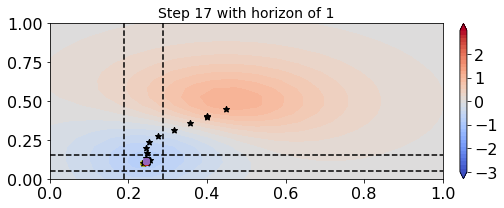

  4%|▍         | 2/50 [00:00<00:03, 13.33it/s]

x0:  [[0.24766746163368225, 0.12026765942573547]] , a:  [[[0.26411572098731995, 0.13827133178710938]], [[0.2572781443595886, 0.13204127550125122]], [[0.25212883949279785, 0.12226778268814087]], [[0.26912668347358704, 0.12631773948669434]], [[0.263351172208786, 0.13734111189842224]]] , loss:  -0.771877714084801


 24%|██▍       | 12/50 [00:00<00:02, 13.15it/s]

x0:  [[0.23574458062648773, 0.10504570603370667]] , a:  [[[0.23919448256492615, 0.10355626046657562]], [[0.24161550402641296, 0.10100237280130386]], [[0.24482838809490204, 0.10314750671386719]], [[0.23949268460273743, 0.10331755131483078]], [[0.2392648458480835, 0.1030072569847107]]] , loss:  -0.7867893172538516


 44%|████▍     | 22/50 [00:01<00:02, 12.66it/s]

x0:  [[0.23860716819763184, 0.11126938462257385]] , a:  [[[0.24733836948871613, 0.11123199760913849]], [[0.24852260947227478, 0.11501478403806686]], [[0.24782830476760864, 0.11947210133075714]], [[0.24460165202617645, 0.11757687479257584]], [[0.24760423600673676, 0.11178814619779587]]] , loss:  -0.7879126572051496


 64%|██████▍   | 32/50 [00:02<00:01, 13.16it/s]

x0:  [[0.2370280921459198, 0.10766929388046265]] , a:  [[[0.24474497139453888, 0.10932229459285736]], [[0.24314644932746887, 0.1090918630361557]], [[0.2428015023469925, 0.10605522245168686]], [[0.24667830765247345, 0.10581684857606888]], [[0.24454908072948456, 0.10938546806573868]]] , loss:  -0.7883758501247757


 84%|████████▍ | 42/50 [00:03<00:00, 13.55it/s]

x0:  [[0.2373000532388687, 0.10985822975635529]] , a:  [[[0.2448441982269287, 0.11261363327503204]], [[0.2457886040210724, 0.11129391193389893]], [[0.24623426795005798, 0.11137837171554565]], [[0.24445664882659912, 0.11282621324062347]], [[0.24491971731185913, 0.11237195879220963]]] , loss:  -0.788556991991577


100%|██████████| 50/50 [00:03<00:00, 12.90it/s]


Current optimal loss -0.7883733915761956;optimal action: tensor([[0.2429, 0.1124]], grad_fn=<AddBackward0>)


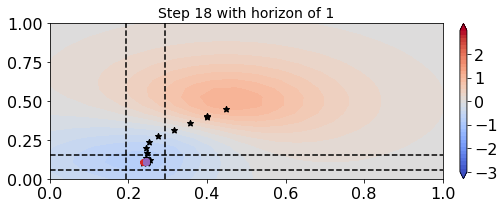

  4%|▍         | 2/50 [00:00<00:03, 13.70it/s]

x0:  [[0.25298747420310974, 0.11544167995452881]] , a:  [[[0.2743234634399414, 0.13814175128936768]], [[0.2559528648853302, 0.13083416223526]], [[0.2535976767539978, 0.1272778958082199]], [[0.25363871455192566, 0.1305660903453827]], [[0.2629729211330414, 0.1377483308315277]]] , loss:  -0.771567748991049


 24%|██▍       | 12/50 [00:00<00:02, 13.71it/s]

x0:  [[0.24230177700519562, 0.09894119203090668]] , a:  [[[0.24303586781024933, 0.10350750386714935]], [[0.2428370714187622, 0.10022812336683273]], [[0.2444859892129898, 0.10048949718475342]], [[0.24485386908054352, 0.10017133504152298]], [[0.23969250917434692, 0.10275068879127502]]] , loss:  -0.7868721010944534


 44%|████▍     | 22/50 [00:01<00:02, 13.56it/s]

x0:  [[0.24295060336589813, 0.10525692999362946]] , a:  [[[0.23977616429328918, 0.11277171969413757]], [[0.24670232832431793, 0.11634618043899536]], [[0.24601371586322784, 0.1182035356760025]], [[0.24567747116088867, 0.1164262518286705]], [[0.24641509354114532, 0.1122591570019722]]] , loss:  -0.7879116814110341


 64%|██████▍   | 32/50 [00:02<00:01, 13.37it/s]

x0:  [[0.2442016899585724, 0.10167557746171951]] , a:  [[[0.248285174369812, 0.10798351466655731]], [[0.24517561495304108, 0.10912225395441055]], [[0.245341494679451, 0.1084619015455246]], [[0.2454163134098053, 0.10909268260002136]], [[0.2464442253112793, 0.10930681228637695]]] , loss:  -0.7884782251945831


 84%|████████▍ | 42/50 [00:03<00:00, 12.10it/s]

x0:  [[0.2430422604084015, 0.10257063806056976]] , a:  [[[0.24507908523082733, 0.11253710091114044]], [[0.24449202418327332, 0.11034558713436127]], [[0.24451644718647003, 0.11000325530767441]], [[0.24457907676696777, 0.1103203073143959]], [[0.24336838722229004, 0.11172135919332504]]] , loss:  -0.7885712058208834


100%|██████████| 50/50 [00:03<00:00, 13.08it/s]


Current optimal loss -0.7875443803979706;optimal action: tensor([[0.2495, 0.1057]], grad_fn=<AddBackward0>)


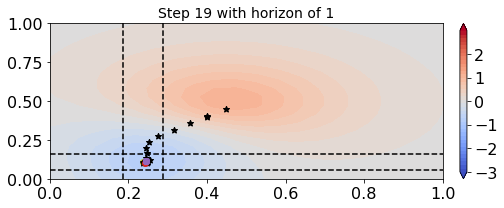

-------------------- Ground truth surface --------------------


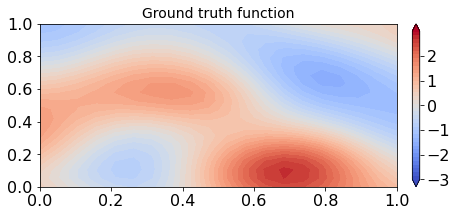

  6%|▌         | 3/50 [00:00<00:03, 12.02it/s]

x0:  [[0.4030516445636749, 0.41791585087776184]] , a:  [[[0.4254205822944641, 0.43692708015441895]], [[0.42419302463531494, 0.422473669052124]], [[0.4163677394390106, 0.434079647064209]], [[0.41061675548553467, 0.42869138717651367]], [[0.4030856490135193, 0.4402361512184143]]] , loss:  0.6480848832007444


 26%|██▌       | 13/50 [00:01<00:02, 13.26it/s]

x0:  [[0.4256930649280548, 0.43524301052093506]] , a:  [[[0.46344438195228577, 0.4710690975189209]], [[0.46279388666152954, 0.46201997995376587]], [[0.4583107829093933, 0.46945589780807495]], [[0.4545305669307709, 0.46619293093681335]], [[0.4483913779258728, 0.4728724956512451]]] , loss:  0.585915977042393


 46%|████▌     | 23/50 [00:01<00:02, 13.43it/s]

x0:  [[0.43962424993515015, 0.4436374008655548]] , a:  [[[0.484487384557724, 0.48746395111083984]], [[0.48421791195869446, 0.48359978199005127]], [[0.4824192523956299, 0.48678112030029297]], [[0.48083412647247314, 0.4853997230529785]], [[0.47803744673728943, 0.48822924494743347]]] , loss:  0.5370369458043618


 66%|██████▌   | 33/50 [00:02<00:01, 13.52it/s]

x0:  [[0.4453413784503937, 0.4468340575695038]] , a:  [[[0.492843359708786, 0.4937165081501007]], [[0.492717981338501, 0.49216997623443604]], [[0.4920252561569214, 0.49341636896133423]], [[0.4914349913597107, 0.49284628033638]], [[0.4904588460922241, 0.494045227766037]]] , loss:  0.5159395479496471


 82%|████████▏ | 41/50 [00:03<00:00, 13.65it/s]

x0:  [[0.44744545221328735, 0.4480842351913452]] , a:  [[[0.4959583580493927, 0.49617812037467957]], [[0.49588438868522644, 0.49544763565063477]], [[0.4955640733242035, 0.4960172474384308]], [[0.4953029155731201, 0.4957350492477417]], [[0.4949280023574829, 0.49634239077568054]]] , loss:  0.5078295195359204


100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


Current optimal loss 1.0837351330504814;optimal action: tensor([[0.4594, 0.4598]], grad_fn=<AddBackward0>)


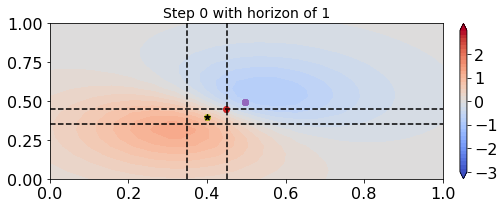

  4%|▍         | 2/50 [00:00<00:03, 13.44it/s]

x0:  [[0.4683166742324829, 0.45581862330436707]] , a:  [[[0.48514968156814575, 0.4766159653663635]], [[0.4894545078277588, 0.45769721269607544]], [[0.48342084884643555, 0.464505672454834]], [[0.4713495075702667, 0.46016725897789]], [[0.47791787981987, 0.47547662258148193]]] , loss:  1.1295520490569009


 24%|██▍       | 12/50 [00:00<00:02, 13.57it/s]

x0:  [[0.4443240165710449, 0.43123430013656616]] , a:  [[[0.4368084967136383, 0.4281192421913147]], [[0.44186654686927795, 0.40934625267982483]], [[0.43481650948524475, 0.4152147173881531]], [[0.4233664870262146, 0.4113946259021759]], [[0.4292185604572296, 0.4267275333404541]]] , loss:  0.8679965138056046


 44%|████▍     | 22/50 [00:01<00:02, 13.76it/s]

x0:  [[0.4209323823451996, 0.41337814927101135]] , a:  [[[0.3911771774291992, 0.38665610551834106]], [[0.39460089802742004, 0.3759770393371582]], [[0.3900162875652313, 0.3789854943752289]], [[0.38389134407043457, 0.3771328330039978]], [[0.3867645859718323, 0.38577279448509216]]] , loss:  0.5446924413684446


 64%|██████▍   | 32/50 [00:02<00:01, 13.71it/s]

x0:  [[0.40837714076042175, 0.40556374192237854]] , a:  [[[0.3673363924026489, 0.3660702407360077]], [[0.3688230812549591, 0.361731618642807]], [[0.366964191198349, 0.3630041480064392]], [[0.3645871877670288, 0.3623271584510803]], [[0.36562126874923706, 0.3657674193382263]]] , loss:  0.4021820999751437


 84%|████████▍ | 42/50 [00:03<00:00, 13.80it/s]

x0:  [[0.4035862684249878, 0.40263622999191284]] , a:  [[[0.35838592052459717, 0.35826244950294495]], [[0.3590148091316223, 0.3563724756240845]], [[0.3582720160484314, 0.35698819160461426]], [[0.3572613298892975, 0.35670894384384155]], [[0.357681006193161, 0.3581676185131073]]] , loss:  0.3540280773314025


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


Current optimal loss 0.7523898806336148;optimal action: tensor([[0.4120, 0.4116]], grad_fn=<AddBackward0>)


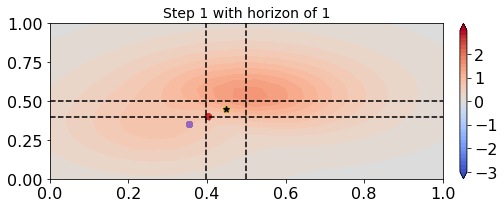

  6%|▌         | 3/50 [00:00<00:04, 10.09it/s]

x0:  [[0.4052039384841919, 0.41327372193336487]] , a:  [[[0.4273526668548584, 0.42628446221351624]], [[0.41063278913497925, 0.4320469796657562]], [[0.4112929403781891, 0.4136873185634613]], [[0.4056788384914398, 0.4322070777416229]], [[0.4100669324398041, 0.4351315498352051]]] , loss:  0.8320278781860212


 26%|██▌       | 13/50 [00:01<00:02, 13.45it/s]

x0:  [[0.38151395320892334, 0.38865798711776733]] , a:  [[[0.3800297677516937, 0.37700727581977844]], [[0.36293888092041016, 0.38317936658859253]], [[0.363569438457489, 0.36602580547332764]], [[0.35891541838645935, 0.3833736777305603]], [[0.36244747042655945, 0.3868067264556885]]] , loss:  0.42632792207103


 46%|████▌     | 23/50 [00:01<00:01, 13.76it/s]

x0:  [[0.3666169047355652, 0.3703248202800751]] , a:  [[[0.34263545274734497, 0.33979254961013794]], [[0.3324081599712372, 0.34367263317108154]], [[0.3328872323036194, 0.3340187966823578]], [[0.3302917778491974, 0.34382957220077515]], [[0.33211031556129456, 0.34603023529052734]]] , loss:  0.19154232914683078


 66%|██████▌   | 33/50 [00:02<00:01, 13.87it/s]

x0:  [[0.360172837972641, 0.3617422580718994]] , a:  [[[0.32386088371276855, 0.3223044276237488]], [[0.3190750777721405, 0.3241555690765381]], [[0.319362074136734, 0.31961876153945923]], [[0.3180250823497772, 0.32423654198646545]], [[0.3189106583595276, 0.32521718740463257]]] , loss:  0.10964563313767384


 86%|████████▌ | 43/50 [00:03<00:00, 13.74it/s]

x0:  [[0.3574303090572357, 0.3581094741821289]] , a:  [[[0.31576430797576904, 0.3149243891239166]], [[0.31338661909103394, 0.3158267140388489]], [[0.3135451078414917, 0.3134806156158447]], [[0.3127863109111786, 0.31586024165153503]], [[0.3132903575897217, 0.316302627325058]]] , loss:  0.08004952963763487


100%|██████████| 50/50 [00:03<00:00, 13.11it/s]


Current optimal loss 0.3250671819728998;optimal action: tensor([[0.3652, 0.3655]], grad_fn=<AddBackward0>)


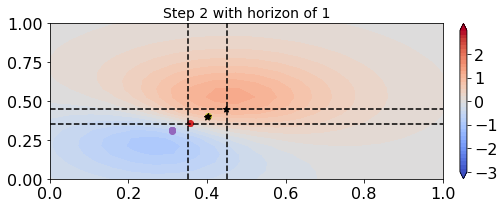

  4%|▍         | 2/50 [00:00<00:03, 14.31it/s]

x0:  [[0.37899264693260193, 0.3583138883113861]] , a:  [[[0.3916054964065552, 0.38028377294540405]], [[0.3825567960739136, 0.36882099509239197]], [[0.38165295124053955, 0.3741638660430908]], [[0.3924059569835663, 0.3717274069786072]], [[0.3879365921020508, 0.3652975559234619]]] , loss:  0.45878463521564444


 24%|██▍       | 12/50 [00:00<00:02, 13.90it/s]

x0:  [[0.35567259788513184, 0.335105299949646]] , a:  [[[0.3437449038028717, 0.3335600197315216]], [[0.3356712758541107, 0.32134073972702026]], [[0.33491262793540955, 0.3266638219356537]], [[0.3445764482021332, 0.32412344217300415]], [[0.34033435583114624, 0.31812039017677307]]] , loss:  0.018777644707006404


 44%|████▍     | 22/50 [00:01<00:02, 12.19it/s]

x0:  [[0.33392801880836487, 0.32134050130844116]] , a:  [[[0.30387914180755615, 0.29824793338775635]], [[0.2995370626449585, 0.2907150685787201]], [[0.2990783154964447, 0.2938966453075409]], [[0.30448299646377563, 0.2922626733779907]], [[0.3021245002746582, 0.28883418440818787]]] , loss:  -0.19271249241149122


 64%|██████▍   | 32/50 [00:02<00:01, 13.63it/s]

x0:  [[0.322224885225296, 0.315545916557312]] , a:  [[[0.28393080830574036, 0.28090786933898926]], [[0.2817784249782562, 0.27715635299682617]], [[0.2815076410770416, 0.2787898778915405]], [[0.2843053936958313, 0.2779163718223572]], [[0.2831465005874634, 0.2761484980583191]]] , loss:  -0.25434952755004814


 84%|████████▍ | 42/50 [00:03<00:00, 13.49it/s]

x0:  [[0.31703346967697144, 0.3130525052547455]] , a:  [[[0.2752982974052429, 0.27326664328575134]], [[0.27403005957603455, 0.2712281048297882]], [[0.2738519310951233, 0.272158145904541]], [[0.27553775906562805, 0.27166295051574707]], [[0.27487313747406006, 0.27062222361564636]]] , loss:  -0.27421053311869203


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Current optimal loss -0.09291796277212051;optimal action: tensor([[0.3227, 0.3198]], grad_fn=<AddBackward0>)


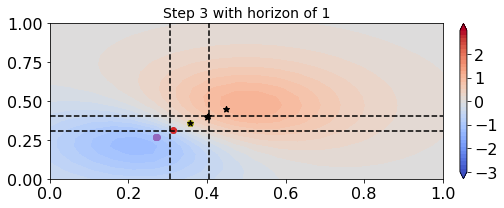

  4%|▍         | 2/50 [00:00<00:03, 12.97it/s]

x0:  [[0.32981154322624207, 0.3160734474658966]] , a:  [[[0.3419170081615448, 0.3235129117965698]], [[0.33743399381637573, 0.31635215878486633]], [[0.34585678577423096, 0.33179086446762085]], [[0.33140504360198975, 0.3181520104408264]], [[0.3328012228012085, 0.32270190119743347]]] , loss:  -0.01963622345231954


 24%|██▍       | 12/50 [00:00<00:02, 13.66it/s]

x0:  [[0.3058350086212158, 0.29284346103668213]] , a:  [[[0.29389169812202454, 0.2766033709049225]], [[0.28976064920425415, 0.2706904709339142]], [[0.29784095287323, 0.284546822309494]], [[0.28470367193222046, 0.272128164768219]], [[0.2858102023601532, 0.2759231626987457]]] , loss:  -0.33505191607682744


 44%|████▍     | 22/50 [00:01<00:02, 13.98it/s]

x0:  [[0.2885991334915161, 0.27931728959083557]] , a:  [[[0.2603546977043152, 0.24843952059745789]], [[0.25792816281318665, 0.2450285255908966]], [[0.2627081871032715, 0.2532341480255127]], [[0.25497958064079285, 0.2458844780921936]], [[0.25559309124946594, 0.2480938881635666]]] , loss:  -0.42725590415018955


 64%|██████▍   | 32/50 [00:02<00:01, 13.68it/s]

x0:  [[0.280781626701355, 0.2736595869064331]] , a:  [[[0.24539929628372192, 0.23649029433727264]], [[0.2439957559108734, 0.23443278670310974]], [[0.24668651819229126, 0.23922733962535858]], [[0.24219273030757904, 0.23497112095355988]], [[0.24256058037281036, 0.2363075464963913]]] , loss:  -0.4449939129428107


 84%|████████▍ | 42/50 [00:03<00:00, 11.79it/s]

x0:  [[0.2775166630744934, 0.2712308168411255]] , a:  [[[0.23918721079826355, 0.23134252429008484]], [[0.2382306158542633, 0.22988566756248474]], [[0.24000997841358185, 0.23314426839351654]], [[0.23692628741264343, 0.23027533292770386]], [[0.23719066381454468, 0.23121938109397888]]] , loss:  -0.44914476881653903


100%|██████████| 50/50 [00:03<00:00, 13.05it/s]


Current optimal loss -0.37979641492435356;optimal action: tensor([[0.2840, 0.2777]], grad_fn=<AddBackward0>)


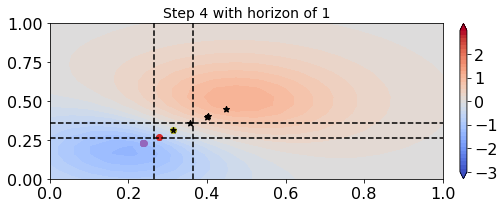

  4%|▍         | 2/50 [00:00<00:03, 13.62it/s]

x0:  [[0.29665371775627136, 0.2841019630432129]] , a:  [[[0.3166770339012146, 0.29611286520957947]], [[0.31905215978622437, 0.3053968548774719]], [[0.30718308687210083, 0.29529547691345215]], [[0.3016832172870636, 0.3034677803516388]], [[0.3141234517097473, 0.29856008291244507]]] , loss:  -0.21578970366585168


 24%|██▍       | 12/50 [00:00<00:02, 13.74it/s]

x0:  [[0.2731301486492157, 0.2601068615913391]] , a:  [[[0.2696370482444763, 0.24816517531871796]], [[0.2724149227142334, 0.2580866813659668]], [[0.25979918241500854, 0.24742315709590912]], [[0.25487756729125977, 0.255906343460083]], [[0.2667754590511322, 0.25060126185417175]]] , loss:  -0.4842221837396526


 44%|████▍     | 22/50 [00:01<00:02, 13.70it/s]

x0:  [[0.2549535632133484, 0.24388131499290466]] , a:  [[[0.2329433560371399, 0.21629516780376434]], [[0.23464910686016083, 0.22259078919887543]], [[0.22678884863853455, 0.21596835553646088]], [[0.22373440861701965, 0.2213556468486786]], [[0.23105712234973907, 0.21783651411533356]]] , loss:  -0.5588228126495244


 64%|██████▍   | 32/50 [00:02<00:01, 13.75it/s]

x0:  [[0.24734212458133698, 0.23720629513263702]] , a:  [[[0.21738290786743164, 0.203341543674469]], [[0.2181936651468277, 0.20697961747646332]], [[0.21371622383594513, 0.2032448947429657]], [[0.21164585649967194, 0.2064644992351532]], [[0.2162533402442932, 0.20430195331573486]]] , loss:  -0.5647352316407104


 84%|████████▍ | 42/50 [00:03<00:00, 13.89it/s]

x0:  [[0.24517592787742615, 0.2348524034023285]] , a:  [[[0.21277080476284027, 0.19883395731449127]], [[0.21316629648208618, 0.20129185914993286]], [[0.21015800535678864, 0.1988411247730255]], [[0.20844262838363647, 0.20110058784484863]], [[0.21196214854717255, 0.19954264163970947]]] , loss:  -0.5641467156809901


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


Current optimal loss -0.5242037325693788;optimal action: tensor([[0.2546, 0.2441]], grad_fn=<AddBackward0>)


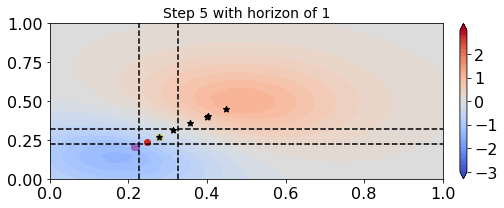

  6%|▌         | 3/50 [00:00<00:04, 10.07it/s]

x0:  [[0.2652451992034912, 0.24634292721748352]] , a:  [[[0.2818485200405121, 0.25663110613822937]], [[0.27924349904060364, 0.26212018728256226]], [[0.28376781940460205, 0.25199437141418457]], [[0.2845648229122162, 0.25901365280151367]], [[0.2852361500263214, 0.25611987709999084]]] , loss:  -0.43932817698436055


 26%|██▌       | 13/50 [00:01<00:02, 12.73it/s]

x0:  [[0.24181951582431793, 0.22316429018974304]] , a:  [[[0.23500347137451172, 0.21016322076320648]], [[0.23231668770313263, 0.21551643311977386]], [[0.23707948625087738, 0.20607313513755798]], [[0.23792853951454163, 0.21238656342029572]], [[0.23869644105434418, 0.2096697986125946]]] , loss:  -0.5858354611243517


 46%|████▌     | 23/50 [00:01<00:01, 13.68it/s]

x0:  [[0.2270129770040512, 0.21118032932281494]] , a:  [[[0.20568643510341644, 0.18582041561603546]], [[0.20393654704093933, 0.18908758461475372]], [[0.20704419910907745, 0.18336956202983856]], [[0.20744185149669647, 0.18707042932510376]], [[0.2079809457063675, 0.18543587625026703]]] , loss:  -0.5989141595285685


 66%|██████▌   | 33/50 [00:02<00:01, 13.59it/s]

x0:  [[0.2235649824142456, 0.2085641324520111]] , a:  [[[0.19910144805908203, 0.18065279722213745]], [[0.197908416390419, 0.18260927498340607]], [[0.1999920904636383, 0.1791221797466278]], [[0.19999130070209503, 0.1812855750322342]], [[0.20037758350372314, 0.1803005486726761]]] , loss:  -0.5959048617665104


 86%|████████▌ | 43/50 [00:03<00:00, 13.36it/s]

x0:  [[0.22563424706459045, 0.21000376343727112]] , a:  [[[0.2035675048828125, 0.18392601609230042]], [[0.20263637602329254, 0.1851130872964859]], [[0.2042408287525177, 0.1829851120710373]], [[0.20391450822353363, 0.1841481775045395]], [[0.20425036549568176, 0.18355560302734375]]] , loss:  -0.5979844460926829


100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


Current optimal loss -0.5879873204955677;optimal action: tensor([[0.2359, 0.2189]], grad_fn=<AddBackward0>)


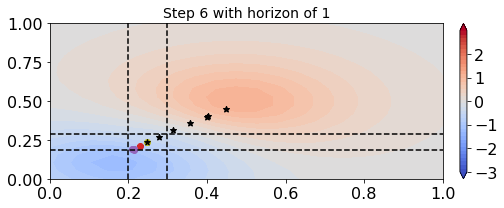

  4%|▍         | 2/50 [00:00<00:03, 13.05it/s]

x0:  [[0.244951069355011, 0.21853624284267426]] , a:  [[[0.2674318253993988, 0.22951281070709229]], [[0.25559407472610474, 0.2408004105091095]], [[0.2662253975868225, 0.23584288358688354]], [[0.26231375336647034, 0.23220060765743256]], [[0.258792519569397, 0.2341231107711792]]] , loss:  -0.5300570365693335


 24%|██▍       | 12/50 [00:00<00:02, 13.49it/s]

x0:  [[0.221684992313385, 0.19571085274219513]] , a:  [[[0.22167880833148956, 0.18351498246192932]], [[0.20935657620429993, 0.19533352553844452]], [[0.2202407419681549, 0.18974918127059937]], [[0.21595782041549683, 0.18608325719833374]], [[0.21240204572677612, 0.18800711631774902]]] , loss:  -0.6264165496722474


 44%|████▍     | 22/50 [00:01<00:02, 12.62it/s]

x0:  [[0.21006453037261963, 0.1850263625383377]] , a:  [[[0.1955832540988922, 0.16189050674438477]], [[0.1887921392917633, 0.16873958706855774]], [[0.19460135698318481, 0.16529996693134308]], [[0.19242066144943237, 0.16339904069900513]], [[0.19056551158428192, 0.16451779007911682]]] , loss:  -0.6280239661828597


 64%|██████▍   | 32/50 [00:02<00:01, 13.85it/s]

x0:  [[0.21139785647392273, 0.18371374905109406]] , a:  [[[0.19649925827980042, 0.16110889613628387]], [[0.19420692324638367, 0.16410839557647705]], [[0.19591155648231506, 0.16244003176689148]], [[0.19554173946380615, 0.16188323497772217]], [[0.19504353404045105, 0.1624191850423813]]] , loss:  -0.6283771228596878


 84%|████████▍ | 42/50 [00:03<00:00, 13.75it/s]

x0:  [[0.21682560443878174, 0.18611273169517517]] , a:  [[[0.20658712089061737, 0.1690651774406433]], [[0.20743383467197418, 0.16935093700885773]], [[0.20631320774555206, 0.16885079443454742]], [[0.20704135298728943, 0.16924645006656647]], [[0.20746245980262756, 0.16934555768966675]]] , loss:  -0.6311585723609587


100%|██████████| 50/50 [00:03<00:00, 13.05it/s]


Current optimal loss -0.6385420899922807;optimal action: tensor([[0.2208, 0.1900]], grad_fn=<AddBackward0>)


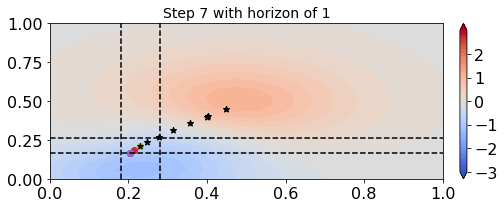

  4%|▍         | 2/50 [00:00<00:03, 13.58it/s]

x0:  [[0.21597346663475037, 0.20669138431549072]] , a:  [[[0.23237565159797668, 0.22136998176574707]], [[0.22208717465400696, 0.22668221592903137]], [[0.22368523478507996, 0.22187170386314392]], [[0.22653329372406006, 0.21840228140354156]], [[0.23024117946624756, 0.21477918326854706]]] , loss:  -0.588550762375508


 24%|██▍       | 12/50 [00:00<00:02, 13.62it/s]

x0:  [[0.20122341811656952, 0.1833113729953766]] , a:  [[[0.19921112060546875, 0.17380040884017944]], [[0.198342964053154, 0.17959177494049072]], [[0.19800260663032532, 0.17433258891105652]], [[0.19780993461608887, 0.17087414860725403]], [[0.198444202542305, 0.16752195358276367]]] , loss:  -0.6594194399241141


 44%|████▍     | 22/50 [00:01<00:02, 13.39it/s]

x0:  [[0.20736892521381378, 0.1643831431865692]] , a:  [[[0.20923177897930145, 0.13806568086147308]], [[0.21386556327342987, 0.14156243205070496]], [[0.21354416012763977, 0.1383935511112213]], [[0.2124543935060501, 0.13640378415584564]], [[0.21053126454353333, 0.1345205157995224]]] , loss:  -0.6785406483824722


 64%|██████▍   | 32/50 [00:02<00:01, 13.07it/s]

x0:  [[0.2035268098115921, 0.15765389800071716]] , a:  [[[0.20583932101726532, 0.12570099532604218]], [[0.20301425457000732, 0.12751032412052155]], [[0.2036258429288864, 0.12587717175483704]], [[0.20454491674900055, 0.12480323761701584]], [[0.20552656054496765, 0.12374431639909744]]] , loss:  -0.6775430254958072


 84%|████████▍ | 42/50 [00:03<00:00, 12.57it/s]

x0:  [[0.20556971430778503, 0.15777239203453064]] , a:  [[[0.20899735391139984, 0.1255401372909546]], [[0.20924387872219086, 0.12660923600196838]], [[0.2089099884033203, 0.12564817070960999]], [[0.20869334042072296, 0.12497660517692566]], [[0.20874737203121185, 0.12428581714630127]]] , loss:  -0.6775945293595141


100%|██████████| 50/50 [00:03<00:00, 12.87it/s]


Current optimal loss -0.6690068227407153;optimal action: tensor([[0.2125, 0.1674]], grad_fn=<AddBackward0>)


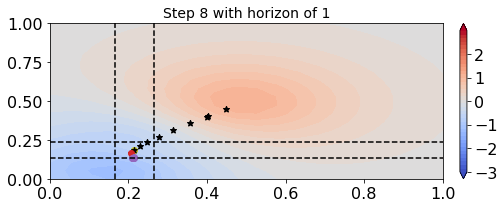

  4%|▍         | 2/50 [00:00<00:03, 13.77it/s]

x0:  [[0.21788880228996277, 0.1682475507259369]] , a:  [[[0.22472615540027618, 0.18464972078800201]], [[0.23471227288246155, 0.18034446239471436]], [[0.2283557653427124, 0.1778796762228012]], [[0.2320995032787323, 0.18467718362808228]], [[0.22533182799816132, 0.17491155862808228]]] , loss:  -0.6481100832506516


 24%|██▍       | 12/50 [00:00<00:02, 13.36it/s]

x0:  [[0.2011474072933197, 0.14518961310386658]] , a:  [[[0.1957683563232422, 0.13791190087795258]], [[0.19820769131183624, 0.1336350440979004]], [[0.1955386996269226, 0.1314164102077484]], [[0.1968981921672821, 0.1379106342792511]], [[0.1951974332332611, 0.12887950241565704]]] , loss:  -0.6935656612262893


 44%|████▍     | 22/50 [00:01<00:02, 13.71it/s]

x0:  [[0.20735298097133636, 0.13445858657360077]] , a:  [[[0.21161001920700073, 0.11284730583429337]], [[0.20563898980617523, 0.11064394563436508]], [[0.20930364727973938, 0.1096251830458641]], [[0.20749452710151672, 0.11278854310512543]], [[0.21082532405853271, 0.10846652835607529]]] , loss:  -0.6953060836324119


 64%|██████▍   | 32/50 [00:02<00:01, 13.82it/s]

x0:  [[0.20415356755256653, 0.13387060165405273]] , a:  [[[0.2014908492565155, 0.11059267818927765]], [[0.2033081203699112, 0.11000888049602509]], [[0.20287683606147766, 0.10978446900844574]], [[0.20318250358104706, 0.11055712401866913]], [[0.20227688550949097, 0.10958877205848694]]] , loss:  -0.695369518102852


 84%|████████▍ | 42/50 [00:03<00:00, 13.59it/s]

x0:  [[0.205662339925766, 0.13718421757221222]] , a:  [[[0.20533505082130432, 0.11772045493125916]], [[0.20640593767166138, 0.11831526458263397]], [[0.2053689956665039, 0.11861855536699295]], [[0.20586654543876648, 0.11775843054056168]], [[0.20512692630290985, 0.11913692206144333]]] , loss:  -0.6967682517897208


100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


Current optimal loss -0.7207779903214039;optimal action: tensor([[0.2113, 0.1417]], grad_fn=<AddBackward0>)


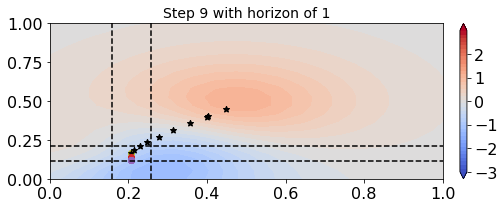

  4%|▍         | 2/50 [00:00<00:03, 13.81it/s]

x0:  [[0.22811341285705566, 0.147620290517807]] , a:  [[[0.23416252434253693, 0.1673010289669037]], [[0.2304590940475464, 0.1650732457637787]], [[0.23866607248783112, 0.16312867403030396]], [[0.22907783091068268, 0.16266366839408875]], [[0.24956800043582916, 0.1511608362197876]]] , loss:  -0.7065366873450326


 24%|██▍       | 12/50 [00:00<00:02, 13.85it/s]

x0:  [[0.23948663473129272, 0.12383813410997391]] , a:  [[[0.26171278953552246, 0.11998172104358673]], [[0.2599625885486603, 0.11750433593988419]], [[0.26246151328086853, 0.11549891531467438]], [[0.2591067850589752, 0.11497844010591507]], [[0.25681978464126587, 0.1046232134103775]]] , loss:  -0.7712021101639884


 44%|████▍     | 22/50 [00:01<00:02, 13.61it/s]

x0:  [[0.23536238074302673, 0.1099032312631607]] , a:  [[[0.25094759464263916, 0.08836633712053299]], [[0.25242605805397034, 0.08689894527196884]], [[0.2468339502811432, 0.08572974801063538]], [[0.2525162994861603, 0.08544909209012985]], [[0.23804064095020294, 0.07955347001552582]]] , loss:  -0.7827993595183758


 64%|██████▍   | 32/50 [00:02<00:01, 13.49it/s]

x0:  [[0.2324301302433014, 0.10595355927944183]] , a:  [[[0.2411913126707077, 0.07829633355140686]], [[0.24239754676818848, 0.07768230885267258]], [[0.240497887134552, 0.07697388529777527]], [[0.24275508522987366, 0.07701201736927032]], [[0.24627068638801575, 0.07368180900812149]]] , loss:  -0.7818114839628462


 84%|████████▍ | 42/50 [00:03<00:00, 13.23it/s]

x0:  [[0.23449544608592987, 0.10654019564390182]] , a:  [[[0.24670284986495972, 0.07888761907815933]], [[0.2455219030380249, 0.07872281223535538]], [[0.24877957999706268, 0.07830299437046051]], [[0.24529600143432617, 0.07847364246845245]], [[0.24982032179832458, 0.07702947407960892]]] , loss:  -0.7823488709402777


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


Current optimal loss -0.7865920569495519;optimal action: tensor([[0.2403, 0.1106]], grad_fn=<AddBackward0>)


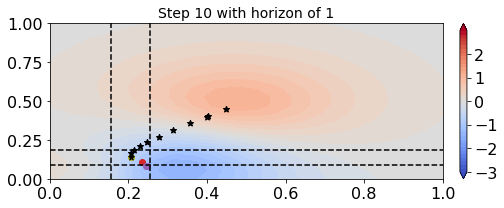

  4%|▍         | 2/50 [00:00<00:03, 13.52it/s]

x0:  [[0.23727895319461823, 0.12289957702159882]] , a:  [[[0.249155655503273, 0.13811230659484863]], [[0.2388269305229187, 0.12999078631401062]], [[0.25980591773986816, 0.13393822312355042]], [[0.25763168931007385, 0.1356697529554367]], [[0.2500162422657013, 0.12576551735401154]]] , loss:  -0.7682142906861135


 24%|██▍       | 12/50 [00:00<00:02, 13.63it/s]

x0:  [[0.24326175451278687, 0.10026241838932037]] , a:  [[[0.26206865906715393, 0.0924500823020935]], [[0.2614791989326477, 0.08523492515087128]], [[0.25360560417175293, 0.08848626166582108]], [[0.25563082098960876, 0.09007999300956726]], [[0.2597963809967041, 0.08202250301837921]]] , loss:  -0.8012986338218446


 44%|████▍     | 22/50 [00:01<00:02, 13.78it/s]

x0:  [[0.24173271656036377, 0.09254151582717896]] , a:  [[[0.2549043595790863, 0.07439756393432617]], [[0.2595973014831543, 0.07192984968423843]], [[0.25822240114212036, 0.07263395190238953]], [[0.25695502758026123, 0.07324472069740295]], [[0.2544386684894562, 0.07116935402154922]]] , loss:  -0.7993822355045399


 64%|██████▍   | 32/50 [00:02<00:01, 13.12it/s]

x0:  [[0.24067944288253784, 0.09843759983778]] , a:  [[[0.25603875517845154, 0.08257134258747101]], [[0.2542186975479126, 0.08381091058254242]], [[0.2566438615322113, 0.08300792425870895]], [[0.25710421800613403, 0.08274711668491364]], [[0.25699615478515625, 0.08512843400239944]]] , loss:  -0.8016475711176518


 84%|████████▍ | 42/50 [00:03<00:00, 13.56it/s]

x0:  [[0.24216286838054657, 0.10211380571126938]] , a:  [[[0.2594950795173645, 0.0888899713754654]], [[0.2583732604980469, 0.09064801037311554]], [[0.2581145465373993, 0.08996935188770294]], [[0.2580294609069824, 0.08954530954360962]], [[0.2592661678791046, 0.0918363705277443]]] , loss:  -0.8014132415199644


100%|██████████| 50/50 [00:03<00:00, 12.98it/s]


Current optimal loss -0.7887241030469637;optimal action: tensor([[0.2477, 0.1037]], grad_fn=<AddBackward0>)


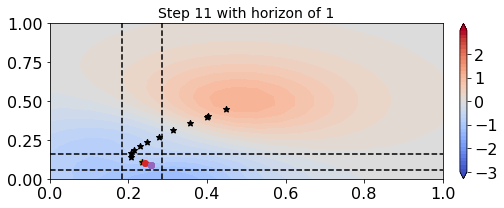

  4%|▍         | 2/50 [00:00<00:03, 13.57it/s]

x0:  [[0.25785812735557556, 0.11578242480754852]] , a:  [[[0.27678734064102173, 0.11911389231681824]], [[0.26669737696647644, 0.12645074725151062]], [[0.2744240164756775, 0.13152697682380676]], [[0.26571810245513916, 0.12155178934335709]], [[0.26157450675964355, 0.12461282312870026]]] , loss:  -0.7804466640569808


 24%|██▍       | 12/50 [00:00<00:02, 13.63it/s]

x0:  [[0.24438928067684174, 0.1072247177362442]] , a:  [[[0.2448236048221588, 0.11447528004646301]], [[0.24279168248176575, 0.10887257754802704]], [[0.2431841939687729, 0.10821086168289185]], [[0.24277573823928833, 0.11286136507987976]], [[0.24566909670829773, 0.10914182662963867]]] , loss:  -0.7892354866034064


 44%|████▍     | 22/50 [00:01<00:02, 13.54it/s]

x0:  [[0.24966278672218323, 0.11000556498765945]] , a:  [[[0.2505030333995819, 0.11171266436576843]], [[0.2560153901576996, 0.11611835658550262]], [[0.25176048278808594, 0.11442021280527115]], [[0.256563663482666, 0.11380916833877563]], [[0.2565653324127197, 0.11746084690093994]]] , loss:  -0.7898454060690561


 64%|██████▍   | 32/50 [00:02<00:01, 13.58it/s]

x0:  [[0.24654535949230194, 0.10784684121608734]] , a:  [[[0.24933791160583496, 0.11283143609762192]], [[0.24754935503005981, 0.11106505990028381]], [[0.24981319904327393, 0.11191485822200775]], [[0.24755752086639404, 0.11249693483114243]], [[0.24594862759113312, 0.10953090339899063]]] , loss:  -0.7902132621112412


 84%|████████▍ | 42/50 [00:03<00:00, 13.68it/s]

x0:  [[0.24857386946678162, 0.1090264692902565]] , a:  [[[0.25253188610076904, 0.1131134033203125]], [[0.25166863203048706, 0.11317034065723419]], [[0.2516661584377289, 0.11348903924226761]], [[0.25135987997055054, 0.1124778464436531]], [[0.25257328152656555, 0.11414308100938797]]] , loss:  -0.7903500796742682


100%|██████████| 50/50 [00:03<00:00, 13.04it/s]


Current optimal loss -0.7871485210184359;optimal action: tensor([[0.2541, 0.1116]], grad_fn=<AddBackward0>)


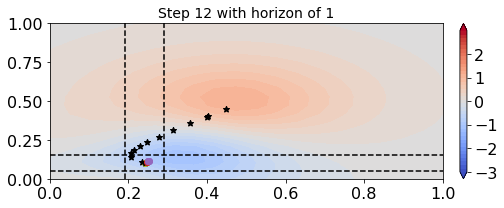

  4%|▍         | 2/50 [00:00<00:03, 13.71it/s]

x0:  [[0.2575278878211975, 0.12514443695545197]] , a:  [[[0.2800966799259186, 0.1447523832321167]], [[0.2803661823272705, 0.146824449300766]], [[0.26273950934410095, 0.12835684418678284]], [[0.2654077112674713, 0.14005377888679504]], [[0.2729697525501251, 0.1320902407169342]]] , loss:  -0.7619771258209658


 24%|██▍       | 12/50 [00:00<00:02, 13.46it/s]

x0:  [[0.23952263593673706, 0.10527058690786362]] , a:  [[[0.24207228422164917, 0.10379292070865631]], [[0.24248498678207397, 0.10566630959510803]], [[0.23710475862026215, 0.09485480189323425]], [[0.23984454572200775, 0.09924624860286713]], [[0.2365848273038864, 0.09700140357017517]]] , loss:  -0.7855439699481719


 44%|████▍     | 22/50 [00:01<00:02, 13.14it/s]

x0:  [[0.24297094345092773, 0.10940836369991302]] , a:  [[[0.2442389577627182, 0.10626006871461868]], [[0.244545578956604, 0.10555695742368698]], [[0.25255298614501953, 0.11396969109773636]], [[0.25119224190711975, 0.10682955384254456]], [[0.24715544283390045, 0.11264247447252274]]] , loss:  -0.7878363730665011


 64%|██████▍   | 32/50 [00:02<00:01, 13.22it/s]

x0:  [[0.2433549016714096, 0.11126186698675156]] , a:  [[[0.248589888215065, 0.11088931560516357]], [[0.24816110730171204, 0.11024076491594315]], [[0.24806293845176697, 0.11466662585735321]], [[0.24536627531051636, 0.11355350911617279]], [[0.2513017952442169, 0.11224879324436188]]] , loss:  -0.787987228181666


 84%|████████▍ | 42/50 [00:03<00:00, 13.40it/s]

x0:  [[0.24185967445373535, 0.10847482085227966]] , a:  [[[0.2464624047279358, 0.10832110792398453]], [[0.24633753299713135, 0.10859230160713196]], [[0.24484562873840332, 0.1042499914765358]], [[0.24739615619182587, 0.10721853375434875]], [[0.24468909204006195, 0.10616829246282578]]] , loss:  -0.7881426758465246


100%|██████████| 50/50 [00:03<00:00, 13.01it/s]


Current optimal loss -0.7882048071799821;optimal action: tensor([[0.2482, 0.1122]], grad_fn=<AddBackward0>)


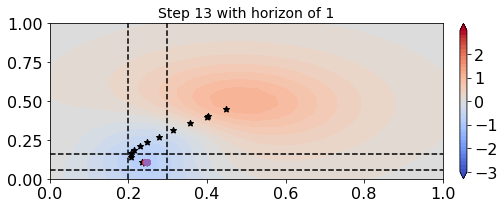

  4%|▍         | 2/50 [00:00<00:03, 12.61it/s]

x0:  [[0.24857361614704132, 0.10990241169929504]] , a:  [[[0.26098623871803284, 0.11647970229387283]], [[0.27034273743629456, 0.11299766600131989]], [[0.257739394903183, 0.11580602079629898]], [[0.2571917474269867, 0.13291798532009125]], [[0.25641435384750366, 0.12446022033691406]]] , loss:  -0.7772947346981459


 24%|██▍       | 12/50 [00:00<00:02, 12.96it/s]

x0:  [[0.23807750642299652, 0.098565012216568]] , a:  [[[0.2403334528207779, 0.11162237823009491]], [[0.2413582056760788, 0.1090540960431099]], [[0.2418205589056015, 0.11158986389636993]], [[0.2446557730436325, 0.10372353345155716]], [[0.243485689163208, 0.10390069335699081]]] , loss:  -0.7878737192511925


 44%|████▍     | 22/50 [00:01<00:02, 13.43it/s]

x0:  [[0.2397957295179367, 0.10052885860204697]] , a:  [[[0.24771004915237427, 0.10901518166065216]], [[0.24276641011238098, 0.10918958485126495]], [[0.24818339943885803, 0.1095685362815857]], [[0.24545900523662567, 0.10958828777074814]], [[0.24677520990371704, 0.11436079442501068]]] , loss:  -0.7883471064430058


 64%|██████▍   | 32/50 [00:02<00:01, 13.35it/s]

x0:  [[0.23928198218345642, 0.0996437668800354]] , a:  [[[0.24474401772022247, 0.11030985414981842]], [[0.2476072609424591, 0.11037183552980423]], [[0.2439100295305252, 0.10983564704656601]], [[0.24514366686344147, 0.11111815273761749]], [[0.24481604993343353, 0.10795510560274124]]] , loss:  -0.7885302361058325


 84%|████████▍ | 42/50 [00:03<00:00, 13.20it/s]

x0:  [[0.23877021670341492, 0.09935815632343292]] , a:  [[[0.2443920373916626, 0.10959649085998535]], [[0.24422119557857513, 0.10985735803842545]], [[0.24493524432182312, 0.10987681895494461]], [[0.24501833319664001, 0.10938194394111633]], [[0.24449294805526733, 0.1099906861782074]]] , loss:  -0.7885946518193157


100%|██████████| 50/50 [00:03<00:00, 12.84it/s]


Current optimal loss -0.787381245975704;optimal action: tensor([[0.2456, 0.1020]], grad_fn=<AddBackward0>)


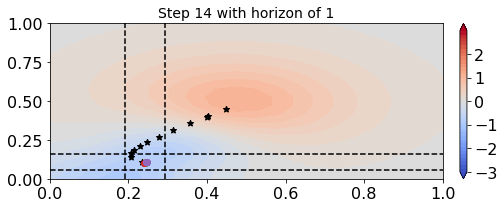

  4%|▍         | 2/50 [00:00<00:03, 13.23it/s]

x0:  [[0.24567782878875732, 0.11494307219982147]] , a:  [[[0.2607601284980774, 0.12002954632043839]], [[0.2587326765060425, 0.12629541754722595]], [[0.2623600661754608, 0.13769316673278809]], [[0.2633594274520874, 0.12244734168052673]], [[0.2538890838623047, 0.11583757400512695]]] , loss:  -0.7766807246210266


 24%|██▍       | 12/50 [00:00<00:02, 13.21it/s]

x0:  [[0.2363349050283432, 0.10367678850889206]] , a:  [[[0.24126096069812775, 0.1080244928598404]], [[0.2428969442844391, 0.10334184765815735]], [[0.2427280843257904, 0.10636155307292938]], [[0.24059288203716278, 0.10655809938907623]], [[0.245340034365654, 0.11072161048650742]]] , loss:  -0.7880139088654301


 44%|████▍     | 22/50 [00:01<00:02, 13.52it/s]

x0:  [[0.2378794252872467, 0.10517779737710953]] , a:  [[[0.24671828746795654, 0.11145195364952087]], [[0.2459288090467453, 0.1126018837094307]], [[0.24478018283843994, 0.10549792647361755]], [[0.24592961370944977, 0.111758753657341]], [[0.24669668078422546, 0.11066544055938721]]] , loss:  -0.7884173486184289


 64%|██████▍   | 32/50 [00:02<00:01, 13.15it/s]

x0:  [[0.2373770922422409, 0.10532817244529724]] , a:  [[[0.24519242346286774, 0.10909850150346756]], [[0.24548675119876862, 0.10994008183479309]], [[0.24596232175827026, 0.11226773262023926]], [[0.2460598349571228, 0.10921815782785416]], [[0.24396765232086182, 0.10901807248592377]]] , loss:  -0.7885510277597563


 84%|████████▍ | 42/50 [00:03<00:00, 13.40it/s]

x0:  [[0.23687312006950378, 0.10467831790447235]] , a:  [[[0.24428322911262512, 0.10929405689239502]], [[0.244319885969162, 0.10814613848924637]], [[0.2445620596408844, 0.10975752770900726]], [[0.24375785887241364, 0.10915127396583557]], [[0.2454710602760315, 0.10957953333854675]]] , loss:  -0.7885668816601172


100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


Current optimal loss -0.7884600557471306;optimal action: tensor([[0.2436, 0.1082]], grad_fn=<AddBackward0>)


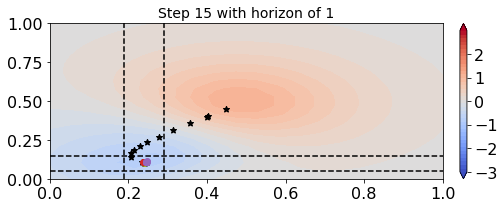

  4%|▍         | 2/50 [00:00<00:03, 13.27it/s]

x0:  [[0.23992426693439484, 0.11437267065048218]] , a:  [[[0.2502461075782776, 0.1337064802646637]], [[0.24048283696174622, 0.12064969539642334]], [[0.2420617789030075, 0.12300466001033783]], [[0.2608024477958679, 0.12581582367420197]], [[0.2625845968723297, 0.13078488409519196]]] , loss:  -0.779013891606594


 24%|██▍       | 12/50 [00:00<00:02, 13.59it/s]

x0:  [[0.23165108263492584, 0.10207831114530563]] , a:  [[[0.2486424744129181, 0.10390834510326385]], [[0.24968454241752625, 0.10529521107673645]], [[0.24860237538814545, 0.10410840809345245]], [[0.24083486199378967, 0.10403387248516083]], [[0.24052192270755768, 0.10332868993282318]]] , loss:  -0.7873049558530647


 44%|████▍     | 22/50 [00:01<00:02, 13.32it/s]

x0:  [[0.2325279861688614, 0.10658150911331177]] , a:  [[[0.2442317008972168, 0.11012648046016693]], [[0.24441930651664734, 0.11559148132801056]], [[0.24487558007240295, 0.11506258696317673]], [[0.24886687099933624, 0.11437129974365234]], [[0.24820920825004578, 0.11238059401512146]]] , loss:  -0.7881298735891346


 64%|██████▍   | 32/50 [00:02<00:01, 13.44it/s]

x0:  [[0.23086139559745789, 0.10367323458194733]] , a:  [[[0.24629399180412292, 0.10986117273569107]], [[0.24570445716381073, 0.10617373138666153]], [[0.24570295214653015, 0.10703278332948685]], [[0.243857741355896, 0.10759902000427246]], [[0.24447059631347656, 0.10930608212947845]]] , loss:  -0.788454162771318


 84%|████████▍ | 42/50 [00:03<00:00, 13.71it/s]

x0:  [[0.23102952539920807, 0.10534119606018066]] , a:  [[[0.24483704566955566, 0.11147857457399368]], [[0.24533477425575256, 0.11173386126756668]], [[0.24521386623382568, 0.11138233542442322]], [[0.2458777129650116, 0.11133413016796112]], [[0.24555963277816772, 0.11074744910001755]]] , loss:  -0.7885722121016829


100%|██████████| 50/50 [00:03<00:00, 12.84it/s]


Current optimal loss -0.7871607180786371;optimal action: tensor([[0.2366, 0.1075]], grad_fn=<AddBackward0>)


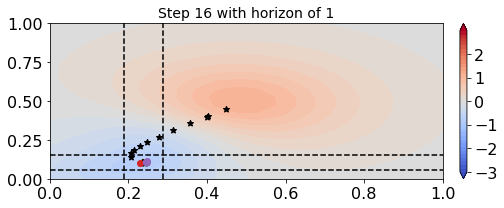

  4%|▍         | 2/50 [00:00<00:03, 13.27it/s]

x0:  [[0.23216746747493744, 0.11479835212230682]] , a:  [[[0.2412795126438141, 0.11757764220237732]], [[0.24196785688400269, 0.1191057413816452]], [[0.25074106454849243, 0.12645158171653748]], [[0.24046461284160614, 0.11850345879793167]], [[0.23373277485370636, 0.1310770958662033]]] , loss:  -0.7830315053340952


 24%|██▍       | 12/50 [00:00<00:02, 13.18it/s]

x0:  [[0.23517054319381714, 0.10631194710731506]] , a:  [[[0.2436494082212448, 0.1109861209988594]], [[0.2435482144355774, 0.10973595082759857]], [[0.24246111512184143, 0.10578311234712601]], [[0.24376428127288818, 0.1101052463054657]], [[0.24902893602848053, 0.10583649575710297]]] , loss:  -0.7882503591136697


 44%|████▍     | 22/50 [00:01<00:02, 13.67it/s]

x0:  [[0.23407839238643646, 0.10699288547039032]] , a:  [[[0.24427103996276855, 0.1098848283290863]], [[0.244234099984169, 0.11050933599472046]], [[0.24509911239147186, 0.11087596416473389]], [[0.244420126080513, 0.11033844947814941]], [[0.2415505051612854, 0.1079254075884819]]] , loss:  -0.7884793655282533


 64%|██████▍   | 32/50 [00:02<00:01, 13.59it/s]

x0:  [[0.23482635617256165, 0.10776963829994202]] , a:  [[[0.2444099634885788, 0.11028607189655304]], [[0.24453333020210266, 0.11021629720926285]], [[0.24446973204612732, 0.1114884614944458]], [[0.244171604514122, 0.11019201576709747]], [[0.24614648520946503, 0.11291249841451645]]] , loss:  -0.7885477630076048


 84%|████████▍ | 42/50 [00:03<00:00, 13.29it/s]

x0:  [[0.23466449975967407, 0.10666416585445404]] , a:  [[[0.2450060099363327, 0.10974276065826416]], [[0.24492162466049194, 0.10962819308042526]], [[0.2448282539844513, 0.1083637997508049]], [[0.24517390131950378, 0.10968656092882156]], [[0.2444770634174347, 0.10892468690872192]]] , loss:  -0.7885834126478971


100%|██████████| 50/50 [00:03<00:00, 13.10it/s]


Current optimal loss -0.7879992880951058;optimal action: tensor([[0.2408, 0.1107]], grad_fn=<AddBackward0>)


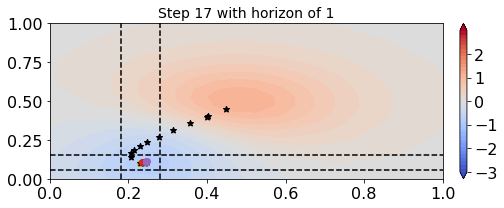

  4%|▍         | 2/50 [00:00<00:03, 13.47it/s]

x0:  [[0.2537485957145691, 0.12814512848854065]] , a:  [[[0.27175113558769226, 0.13828372955322266]], [[0.2710783779621124, 0.12911102175712585]], [[0.2732718586921692, 0.1499851942062378]], [[0.2751619815826416, 0.14250539243221283]], [[0.259224534034729, 0.13885566592216492]]] , loss:  -0.7542107954452263


 24%|██▍       | 12/50 [00:01<00:03, 11.94it/s]

x0:  [[0.23631945252418518, 0.10852578282356262]] , a:  [[[0.23589207231998444, 0.09925872087478638]], [[0.23538410663604736, 0.09709843248128891]], [[0.2372225970029831, 0.10849606245756149]], [[0.23802995681762695, 0.10198644548654556]], [[0.2369472086429596, 0.0992048978805542]]] , loss:  -0.7843446497873083


 44%|████▍     | 22/50 [00:01<00:02, 12.70it/s]

x0:  [[0.2424343377351761, 0.11246581375598907]] , a:  [[[0.24784687161445618, 0.10939015448093414]], [[0.247853621840477, 0.11554647982120514]], [[0.2480165809392929, 0.10571437329053879]], [[0.2461327761411667, 0.1077534407377243]], [[0.25400176644325256, 0.10760851204395294]]] , loss:  -0.787642949572487


 64%|██████▍   | 32/50 [00:02<00:01, 13.14it/s]

x0:  [[0.24010983109474182, 0.11502149701118469]] , a:  [[[0.24494168162345886, 0.11462163925170898]], [[0.24558217823505402, 0.11379547417163849]], [[0.24404048919677734, 0.11059757322072983]], [[0.2446095496416092, 0.11356101930141449]], [[0.2417459785938263, 0.11462356150150299]]] , loss:  -0.7882394632825684


 84%|████████▍ | 42/50 [00:03<00:00, 13.44it/s]

x0:  [[0.24077288806438446, 0.11207650601863861]] , a:  [[[0.24546483159065247, 0.10712268948554993]], [[0.24521508812904358, 0.10467734932899475]], [[0.24560430645942688, 0.10903695225715637]], [[0.24610282480716705, 0.10803081840276718]], [[0.24516870081424713, 0.10795803368091583]]] , loss:  -0.7884081059350297


100%|██████████| 50/50 [00:03<00:00, 12.73it/s]


Current optimal loss -0.7879217325343171;optimal action: tensor([[0.2473, 0.1163]], grad_fn=<AddBackward0>)


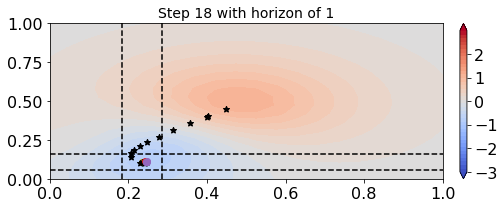

  4%|▍         | 2/50 [00:00<00:03, 12.90it/s]

x0:  [[0.26258909702301025, 0.12829527258872986]] , a:  [[[0.262824147939682, 0.14307862520217896]], [[0.2673247456550598, 0.1328892707824707]], [[0.2676185369491577, 0.1435306817293167]], [[0.2759379744529724, 0.1397426575422287]], [[0.26653289794921875, 0.1489734649658203]]] , loss:  -0.7571124791142825


 24%|██▍       | 12/50 [00:00<00:02, 13.57it/s]

x0:  [[0.2475447654724121, 0.10776671767234802]] , a:  [[[0.23739038407802582, 0.10159312933683395]], [[0.2360192835330963, 0.09702780842781067]], [[0.23676496744155884, 0.10201257467269897]], [[0.2398972511291504, 0.09991323202848434]], [[0.23748517036437988, 0.10673479735851288]]] , loss:  -0.7849515811902961


 44%|████▍     | 22/50 [00:01<00:02, 13.47it/s]

x0:  [[0.25383955240249634, 0.11074003577232361]] , a:  [[[0.25168576836586, 0.10636772215366364]], [[0.248907208442688, 0.11297672241926193]], [[0.24944278597831726, 0.10666420310735703]], [[0.24440933763980865, 0.10973825305700302]], [[0.2504621148109436, 0.10521110892295837]]] , loss:  -0.7876318266709836


 64%|██████▍   | 32/50 [00:02<00:01, 12.45it/s]

x0:  [[0.2514651417732239, 0.11420908570289612]] , a:  [[[0.24188537895679474, 0.11482362449169159]], [[0.2448069155216217, 0.11663585901260376]], [[0.24362729489803314, 0.11484363675117493]], [[0.24457567930221558, 0.11554145812988281]], [[0.24247023463249207, 0.11236347258090973]]] , loss:  -0.78806511106171


 84%|████████▍ | 42/50 [00:03<00:00, 13.02it/s]

x0:  [[0.25307998061180115, 0.11066232621669769]] , a:  [[[0.24636700749397278, 0.10856328904628754]], [[0.24565401673316956, 0.10534835606813431]], [[0.245967835187912, 0.10851651430130005]], [[0.24727705121040344, 0.10680168867111206]], [[0.24620658159255981, 0.10903133451938629]]] , loss:  -0.7883789110380417


100%|██████████| 50/50 [00:03<00:00, 12.85it/s]


Current optimal loss -0.7815763333338841;optimal action: tensor([[0.2590, 0.1143]], grad_fn=<AddBackward0>)


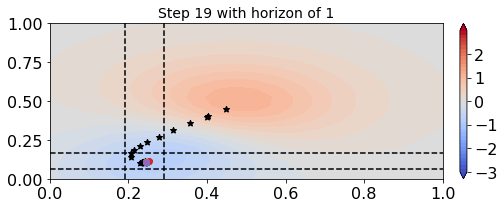

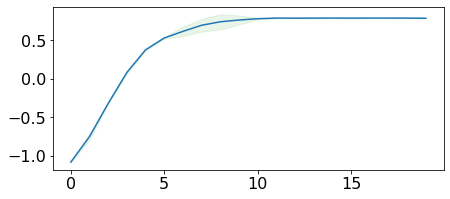

In [ ]:
#@title HES
import copy
n_dim = "2" #@param [1, 2]
n_dim = int(n_dim)
nonmyopic = False #@param {type:"boolean"}
budget = 20 #@param {type:"integer"}

save = True
draw_legend = False 

if n_dim == 1:
    dim_xi = [n_dim]
    prev_x = torch.tensor([0.3])
    prev_x_str = '0.3'
elif n_dim == 2:
    dim_xi = [1, n_dim]
    prev_x = torch.tensor([[0.4, 0.4]])
    prev_x_str = '0.4_0.4'

neighbor_size = 1/budget # 0.02
n_init = 0
ehig_opt_epoch = 50
ehig_opt_lr = 0.1
use_lr_schedule = False
train = False

seeds = [0, 1, 2]

optimal_loss_results = []

exp_name = f'{n_dim}D_nonmyopic{nonmyopic}_budget{budget}_\
neighbor_size{neighbor_size}_prev_x{prev_x_str}'

# create folder
if not os.path.exists(f'{path}/{exp_name}'): 
    os.makedirs(f'{path}/{exp_name}')
    print(f'Saving to: {path}/{exp_name}')

for seed in seeds:

    if n_dim == 1:
        dim_xi = [n_dim]
        prev_x = torch.tensor([0.3])
    elif n_dim == 2:
        dim_xi = [1, n_dim]
        prev_x = torch.tensor([[0.4, 0.4]])

    if n_dim == 2: 
        print('-'*20, 'Ground truth surface', '-'*20)
        ground_truth(draw_true_model=True, n_dim=n_dim)
        plt.show()

    train_x, train_y = init_data(n_init=n_init)

    model = init_model(
        n_dim=n_dim, prev_x=prev_x, 
        train_x=train_x, train_y=train_y,
        train=train)

    if nonmyopic: horizon = budget
    else: horizon = 1
    optimal_loss = []
    for step in range(budget):

        best_result = argmax_ehig(
            model, prev_x, horizon=horizon, 
            ehig_opt_epoch=ehig_opt_epoch, 
            ehig_opt_lr=ehig_opt_lr, 
            neighbor_size=neighbor_size,
            use_lr_schedule=use_lr_schedule,
            seed=seed)
        
        if nonmyopic: horizon = horizon - 1

        with torch.no_grad():
            next_x = best_result[0]
            next_y = func(next_x.reshape(-1, n_dim))

            # draw_posterior(n_dim=n_dim, model=model)
            # if n_dim == 2: plt.show()

            # update data and model
            train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
            train_y = torch.cat([train_y, next_y])

            model = init_model(
                n_dim=n_dim, prev_x=prev_x, 
                train_x=train_x, train_y=train_y,
                train=train)

        # eval
        a = (torch.rand([n_dim] if n_dim==1 else [1, n_dim])).requires_grad_(True)
        optimizer = optim.Adam([a], lr=ehig_opt_lr)

        loss = []
        for epoch in range(10):
            optimizer.zero_grad()

            a = torch.sigmoid(a) * (neighbor_size*2) \
            + (next_x - neighbor_size)

            p_y_on_a_D = model.posterior(a)
            ell = p_y_on_a_D.mean.mean()
            ell.backward(retain_graph=True)
            optimizer.step()
            loss.append(ell.clone().detach())
        
        loss = torch.stack(loss).squeeze()
        print(f'Current optimal loss {loss.min().item()};'
        f'optimal action: {a}')
        optimal_loss.append(loss.min())


        if n_dim == 1:
            dim_xi = [n_dim]
        elif n_dim == 2:
            dim_xi = [1, n_dim]

        # plot & update prev_x
        if n_dim == 1: ground_truth(draw_true_model=True, n_dim=n_dim)

        plt.title(f'Step {step} with horizon of {horizon}')

        # draw_posterior(n_dim=n_dim, model=model)

        if n_dim == 1:
            dmin = -4
            dmax = 4
            plt.vlines(prev_x, dmin, dmax, color=color['C5'], 
                        label='Current location')
            plt.vlines(prev_x - neighbor_size, 
                        dmin, dmax, color='black', linestyle='--')
            plt.vlines(prev_x + neighbor_size, 
                        dmin, dmax, color='black', linestyle='--')
            prev_x = next_x
            plt.plot(train_x.squeeze().cpu().numpy(), 
                    train_y.squeeze().cpu().numpy(), 'k*')
            plt.vlines(best_result[0], dmin, dmax, 
                    color=color['C3'], label='Optimal query')
            plt.vlines(best_result[-1], dmin, dmax, 
                    color=color['C4'], label='Optimal action')
            plt.ylim(dmin, dmax)

        elif n_dim == 2:
            plt.hlines(prev_x[0, 1] - neighbor_size, 0, 1, linestyle='--')
            plt.hlines(prev_x[0, 1] + neighbor_size, 0, 1, linestyle='--')
            plt.vlines(prev_x[0, 0] - neighbor_size, 0, 1, linestyle='--')
            plt.vlines(prev_x[0, 0] + neighbor_size, 0, 1, linestyle='--')
            plt.scatter(prev_x[0, 0], prev_x[0, 1], 
                        color=color['C5'], label='Current location')
            prev_x = next_x 
            plt.scatter(train_x[:, 0], train_x[:, 1], 
                        marker='*', color='black')
            plt.scatter(best_result[0][0, 0], best_result[0][0, 1], 
                        color=color['C3'], label='Optimal query')
            plt.scatter(best_result[-1][..., 0], best_result[-1][..., 1], 
                        color=color['C4'], label='Optimal action')
            plt.ylim(0, 1)

        plt.tight_layout()
        if draw_legend: plt.legend()

        if save: plt.savefig(
            f'{path}/{exp_name}/seed{seed}_step{step}.{imgtype}', 
            dpi=dpi, bbox_inches='tight')

        plt.show()

    # plot optimal loss over query
    optimal_loss = torch.stack(optimal_loss).numpy()

    optimal_loss_results.append(optimal_loss)

optimal_loss_results = np.array(optimal_loss_results)
mean = optimal_loss_results.mean(0)
std = optimal_loss_results.std(0)

plt.plot(-mean, label=color['C1'])
plt.fill_between(
    np.arange(len(mean)),
    -(mean-2*std),
    -(mean+2*std),
    color=color['C2'], alpha=.1
)

plt.show()

np.save(f'{path}/{exp_name}/data.npy', optimal_loss_results)


-------------------- Ground truth surface --------------------


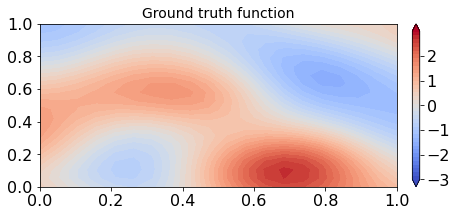

Current optimal loss 0.4399765764135206;optimal action: tensor([[0.3918, 0.3741]], grad_fn=<AddBackward0>)


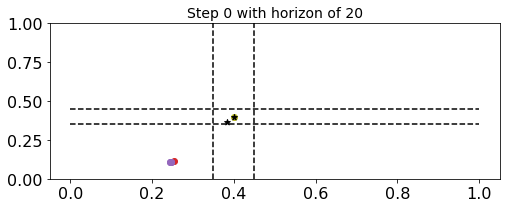

Current optimal loss 0.1693113152620084;optimal action: tensor([[0.3703, 0.3374]], grad_fn=<AddBackward0>)


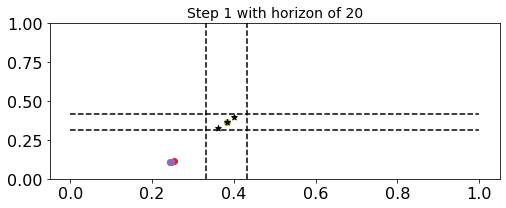

Current optimal loss 0.10371347210365274;optimal action: tensor([[0.3618, 0.3401]], grad_fn=<AddBackward0>)


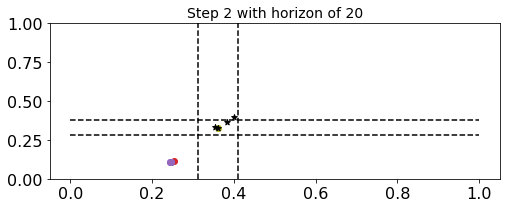

Current optimal loss -0.11470245114469375;optimal action: tensor([[0.3207, 0.3170]], grad_fn=<AddBackward0>)


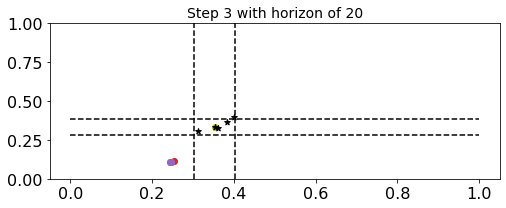

Current optimal loss -0.42769671611235727;optimal action: tensor([[0.2777, 0.2678]], grad_fn=<AddBackward0>)


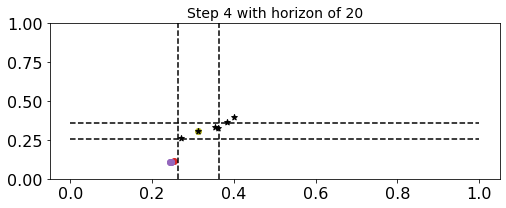

Current optimal loss -0.3414061718377738;optimal action: tensor([[0.2499, 0.2864]], grad_fn=<AddBackward0>)


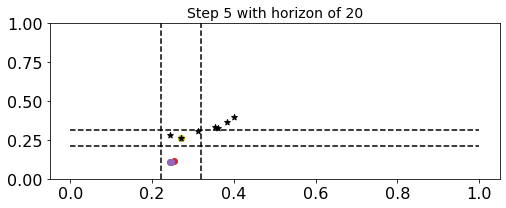

Current optimal loss -0.12495867976455406;optimal action: tensor([[0.2991, 0.3234]], grad_fn=<AddBackward0>)


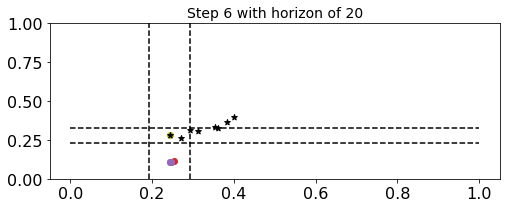

Current optimal loss 0.19413212624490378;optimal action: tensor([[0.3071, 0.3693]], grad_fn=<AddBackward0>)


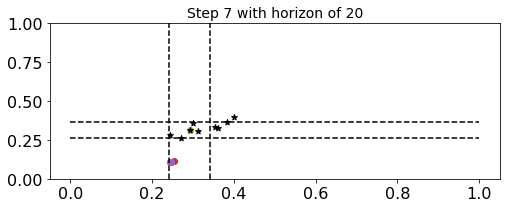

Current optimal loss 0.2550570960413544;optimal action: tensor([[0.2686, 0.3812]], grad_fn=<AddBackward0>)


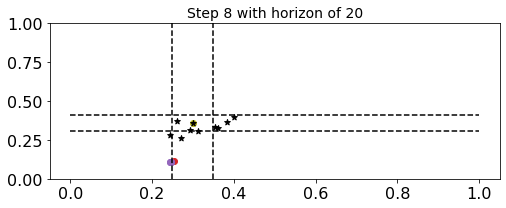

Current optimal loss 0.01753803653759103;optimal action: tensor([[0.2459, 0.3465]], grad_fn=<AddBackward0>)


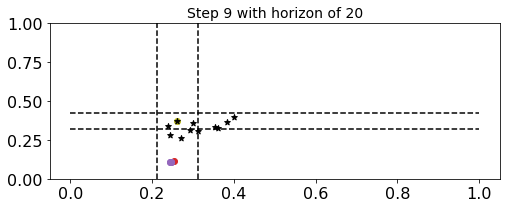

Current optimal loss 0.31467265933131017;optimal action: tensor([[0.2022, 0.3702]], grad_fn=<AddBackward0>)


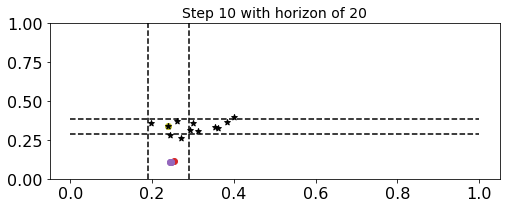

Current optimal loss 0.04321854464703189;optimal action: tensor([[0.2242, 0.3406]], grad_fn=<AddBackward0>)


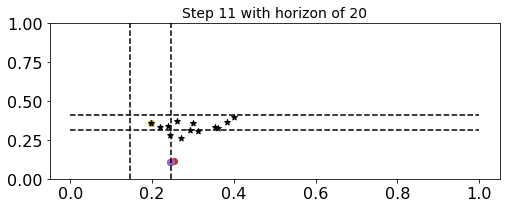

Current optimal loss -0.18456739916993317;optimal action: tensor([[0.2509, 0.3141]], grad_fn=<AddBackward0>)


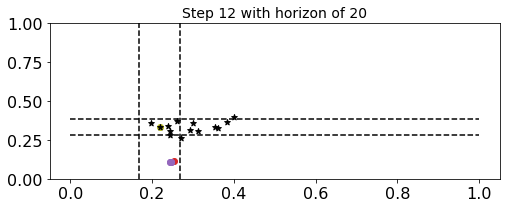

Current optimal loss -0.27052161508568834;optimal action: tensor([[0.2290, 0.2960]], grad_fn=<AddBackward0>)


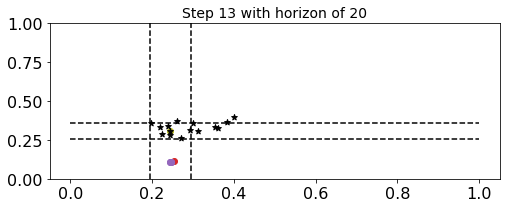

Current optimal loss -0.36931196293583995;optimal action: tensor([[0.2799, 0.2811]], grad_fn=<AddBackward0>)


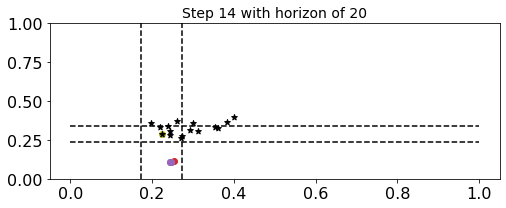

Current optimal loss -0.14176782784447417;optimal action: tensor([[0.3275, 0.3077]], grad_fn=<AddBackward0>)


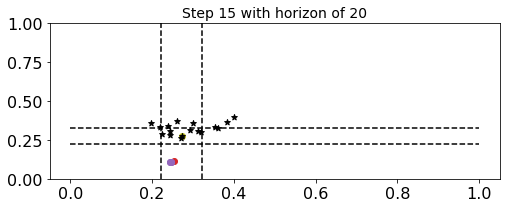

Current optimal loss 0.03963539544477641;optimal action: tensor([[0.3420, 0.3322]], grad_fn=<AddBackward0>)


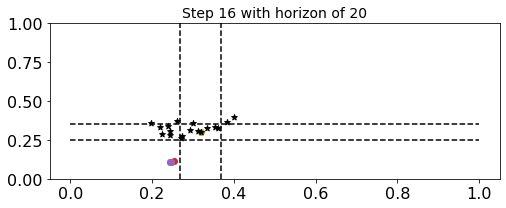

Current optimal loss -0.31714787446043446;optimal action: tensor([[0.2956, 0.2938]], grad_fn=<AddBackward0>)


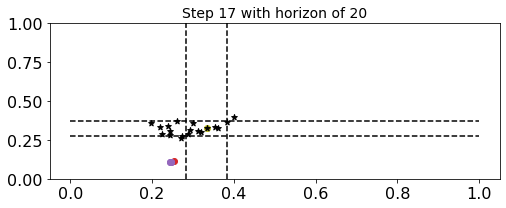

Current optimal loss 0.006444530440822028;optimal action: tensor([[0.3165, 0.3401]], grad_fn=<AddBackward0>)


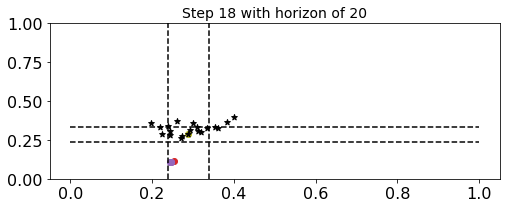

Current optimal loss -0.1051611004445386;optimal action: tensor([[0.3240, 0.3165]], grad_fn=<AddBackward0>)


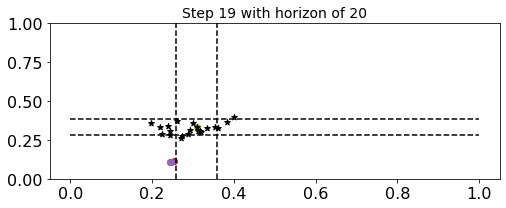

-------------------- Ground truth surface --------------------


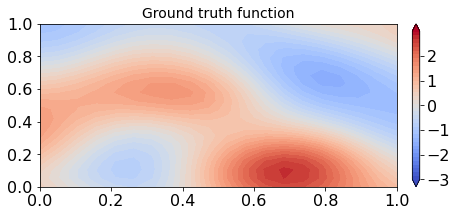

Current optimal loss 0.9027578683010914;optimal action: tensor([[0.4255, 0.4286]], grad_fn=<AddBackward0>)


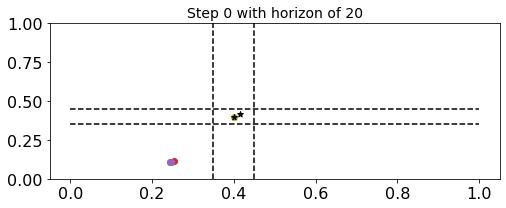

Current optimal loss 0.7152834853917468;optimal action: tensor([[0.4643, 0.3786]], grad_fn=<AddBackward0>)


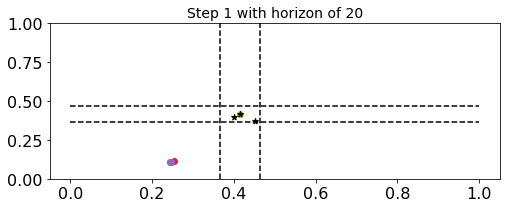

Current optimal loss 0.653312151828495;optimal action: tensor([[0.4760, 0.3550]], grad_fn=<AddBackward0>)


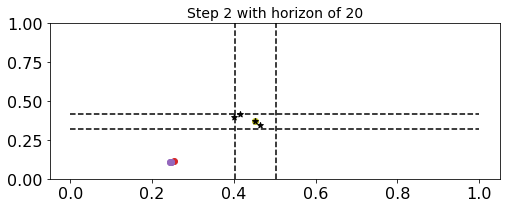

Current optimal loss 0.7902391691281011;optimal action: tensor([[0.5241, 0.3928]], grad_fn=<AddBackward0>)


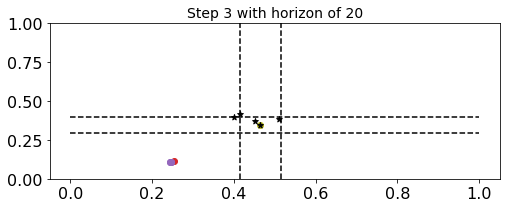

Current optimal loss 0.741566375461551;optimal action: tensor([[0.5537, 0.4381]], grad_fn=<AddBackward0>)


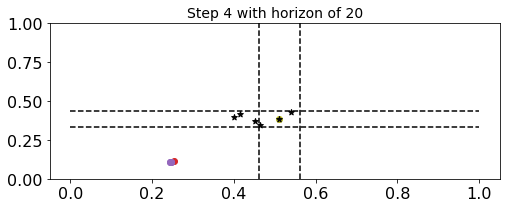

Current optimal loss 1.0262358179944404;optimal action: tensor([[0.5034, 0.4823]], grad_fn=<AddBackward0>)


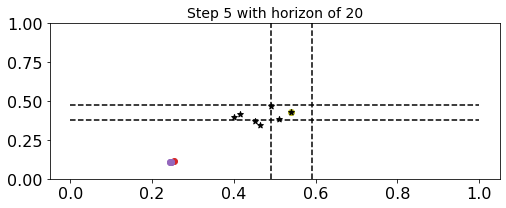

Current optimal loss 0.8935299508733872;optimal action: tensor([[0.5354, 0.5117]], grad_fn=<AddBackward0>)


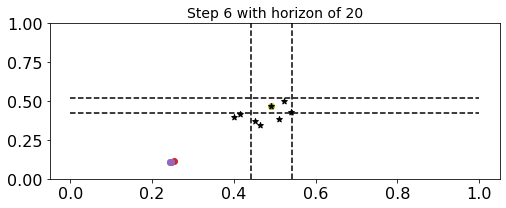

Current optimal loss 0.6533126711636764;optimal action: tensor([[0.5686, 0.4819]], grad_fn=<AddBackward0>)


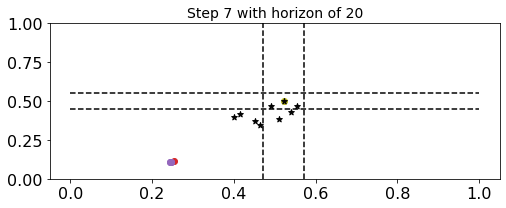

Current optimal loss 0.8593075525717775;optimal action: tensor([[0.5333, 0.4761]], grad_fn=<AddBackward0>)


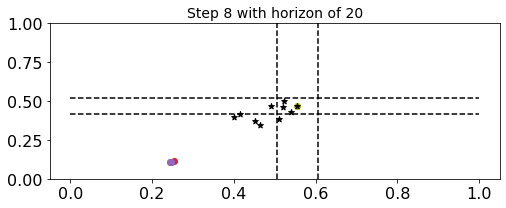

Current optimal loss 0.8276843999962443;optimal action: tensor([[0.5246, 0.4303]], grad_fn=<AddBackward0>)


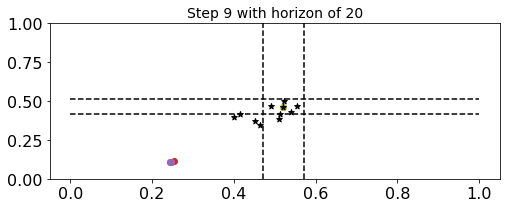

Current optimal loss 0.7888771465603264;optimal action: tensor([[0.5365, 0.4293]], grad_fn=<AddBackward0>)


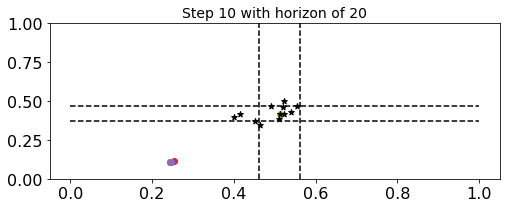

Current optimal loss 0.582546071161969;optimal action: tensor([[0.5801, 0.4647]], grad_fn=<AddBackward0>)


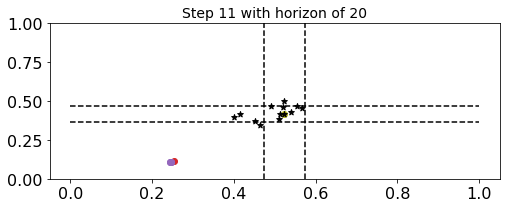

Current optimal loss 0.6280266796370846;optimal action: tensor([[0.5740, 0.4455]], grad_fn=<AddBackward0>)


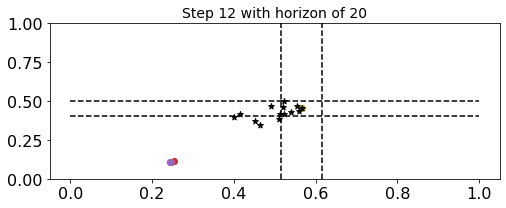

Current optimal loss 0.4320639875518256;optimal action: tensor([[0.6150, 0.4381]], grad_fn=<AddBackward0>)


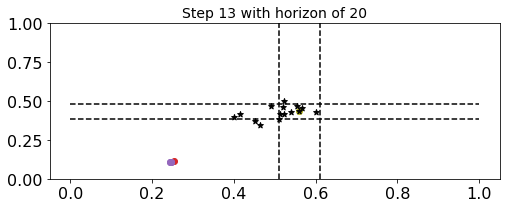

Current optimal loss 0.4224099308389481;optimal action: tensor([[0.6645, 0.3896]], grad_fn=<AddBackward0>)


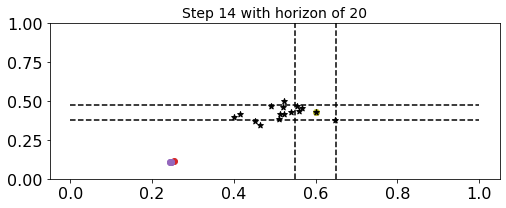

Current optimal loss 0.4070183411583337;optimal action: tensor([[0.6153, 0.4323]], grad_fn=<AddBackward0>)


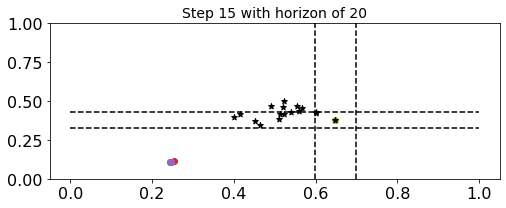

Current optimal loss 0.4545814633523217;optimal action: tensor([[0.5971, 0.4697]], grad_fn=<AddBackward0>)


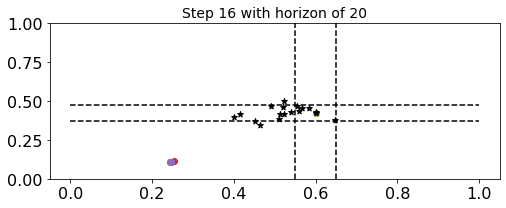

Current optimal loss 0.6007455335244751;optimal action: tensor([[0.5745, 0.4728]], grad_fn=<AddBackward0>)


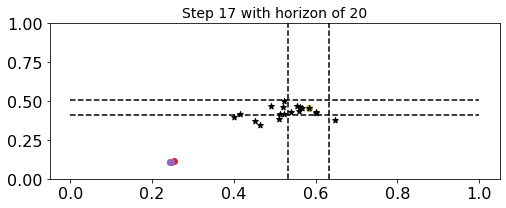

Current optimal loss 0.7573974679847201;optimal action: tensor([[0.5471, 0.4395]], grad_fn=<AddBackward0>)


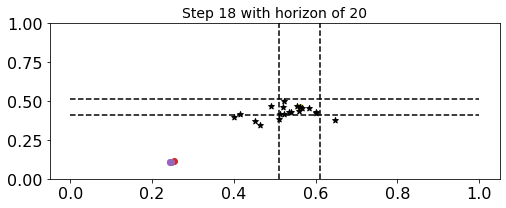

Current optimal loss 0.7845729800565362;optimal action: tensor([[0.5238, 0.4014]], grad_fn=<AddBackward0>)


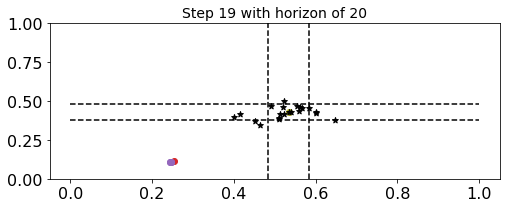

-------------------- Ground truth surface --------------------


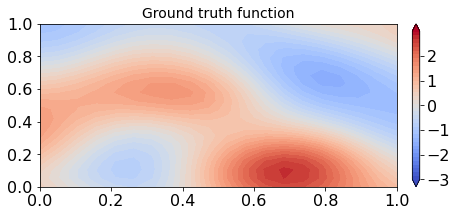

Current optimal loss 0.9830504447901268;optimal action: tensor([[0.4163, 0.4547]], grad_fn=<AddBackward0>)


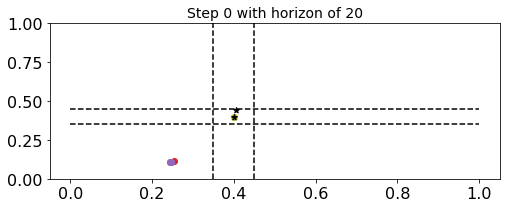

Current optimal loss 1.2349534411670433;optimal action: tensor([[0.4222, 0.4838]], grad_fn=<AddBackward0>)


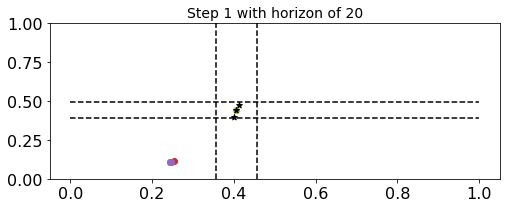

Current optimal loss 0.9240727836768791;optimal action: tensor([[0.4686, 0.4362]], grad_fn=<AddBackward0>)


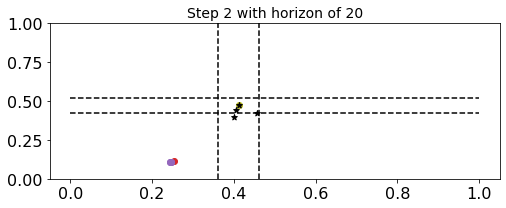

Current optimal loss 0.6446531198762828;optimal action: tensor([[0.4192, 0.3925]], grad_fn=<AddBackward0>)


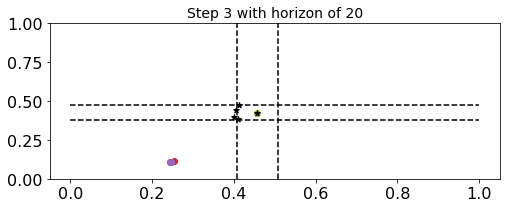

Current optimal loss 0.700626269368671;optimal action: tensor([[0.4450, 0.3876]], grad_fn=<AddBackward0>)


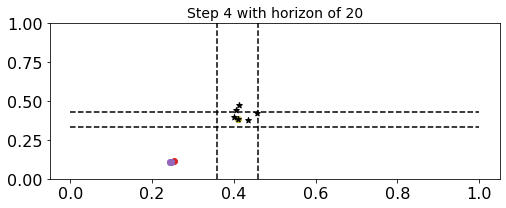

Current optimal loss 0.7218385234566153;optimal action: tensor([[0.4066, 0.4063]], grad_fn=<AddBackward0>)


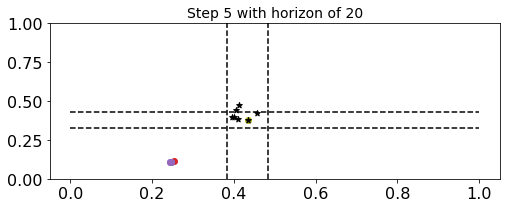

Current optimal loss 0.7888686839165585;optimal action: tensor([[0.3793, 0.4248]], grad_fn=<AddBackward0>)


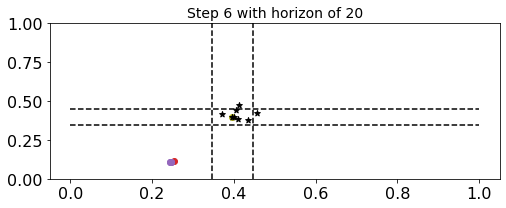

Current optimal loss 0.62466965452021;optimal action: tensor([[0.4061, 0.3915]], grad_fn=<AddBackward0>)


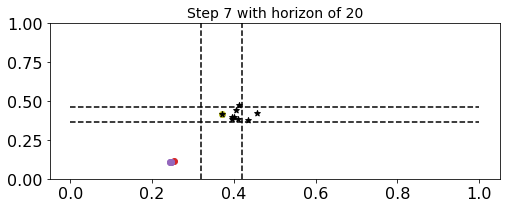

Current optimal loss 0.41489399515635533;optimal action: tensor([[0.3661, 0.3786]], grad_fn=<AddBackward0>)


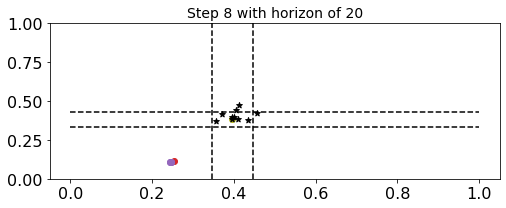

Current optimal loss 0.27163860263250167;optimal action: tensor([[0.3859, 0.3435]], grad_fn=<AddBackward0>)


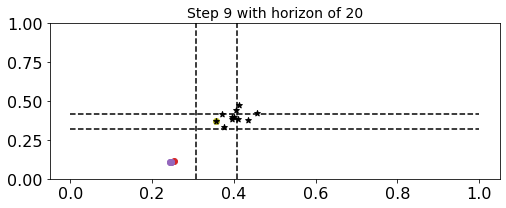

Current optimal loss 0.3855572675772098;optimal action: tensor([[0.3394, 0.3853]], grad_fn=<AddBackward0>)


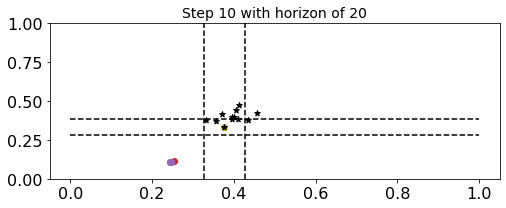

Current optimal loss 0.6939216285875555;optimal action: tensor([[0.3789, 0.4119]], grad_fn=<AddBackward0>)


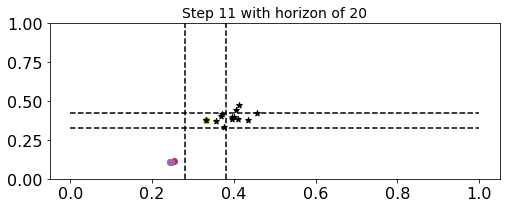

Current optimal loss 0.9468968637413283;optimal action: tensor([[0.3964, 0.4417]], grad_fn=<AddBackward0>)


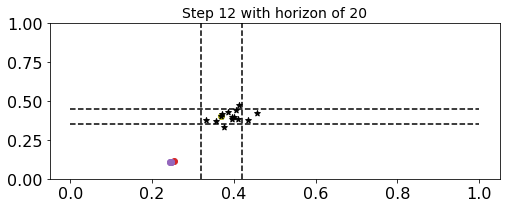

Current optimal loss 0.7673735376236334;optimal action: tensor([[0.4172, 0.4098]], grad_fn=<AddBackward0>)


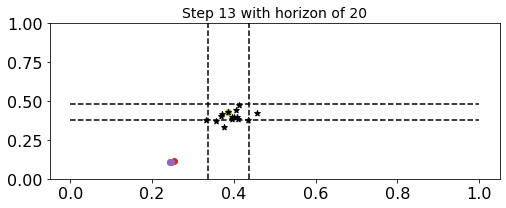

Current optimal loss 0.691873963494603;optimal action: tensor([[0.4255, 0.3943]], grad_fn=<AddBackward0>)


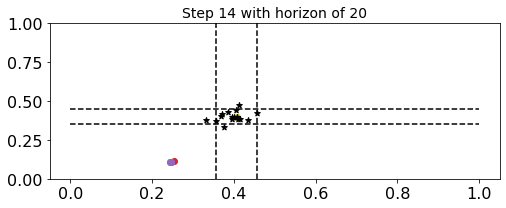

Current optimal loss 0.5506029391728396;optimal action: tensor([[0.4561, 0.3526]], grad_fn=<AddBackward0>)


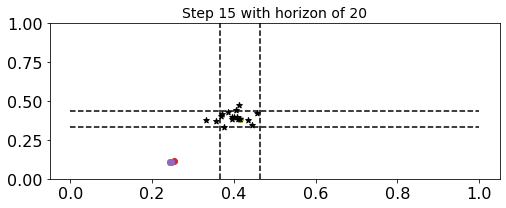

Current optimal loss 0.6471680061873035;optimal action: tensor([[0.4725, 0.3511]], grad_fn=<AddBackward0>)


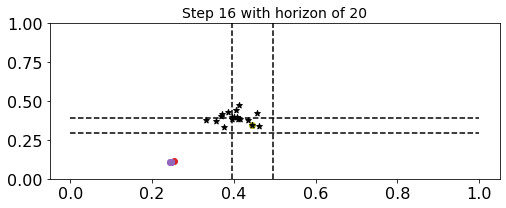

Current optimal loss 0.7944255649236917;optimal action: tensor([[0.5153, 0.3178]], grad_fn=<AddBackward0>)


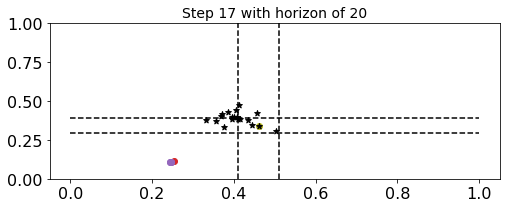

Current optimal loss 0.7616439144819993;optimal action: tensor([[0.5202, 0.3488]], grad_fn=<AddBackward0>)


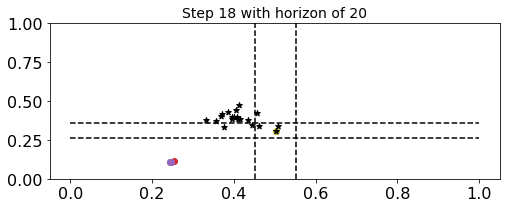

Current optimal loss 0.6775118989412476;optimal action: tensor([[0.4800, 0.3574]], grad_fn=<AddBackward0>)


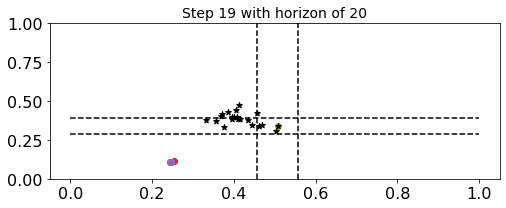

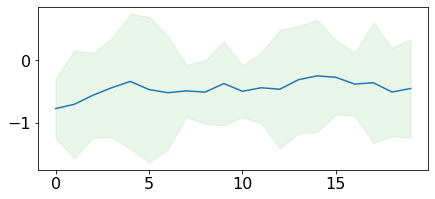

In [11]:
#@title Random
import copy
n_dim = "2" #@param [1, 2]
n_dim = int(n_dim)
nonmyopic = True #@param {type:"boolean"}
budget = 20 #@param {type:"integer"}

save = True
draw_legend = False 

if n_dim == 1:
    dim_xi = [n_dim]
    prev_x = torch.tensor([0.3])
    prev_x_str = '0.3'
elif n_dim == 2:
    dim_xi = [1, n_dim]
    prev_x = torch.tensor([[0.4, 0.4]])
    prev_x_str = '0.4_0.4'

neighbor_size = 1/budget # 0.02
n_init = 0
ehig_opt_epoch = 50
ehig_opt_lr = 0.1
use_lr_schedule = False
train = False

seeds = [0, 1, 2]

optimal_loss_results = []

exp_name = f'{n_dim}D_nonmyopic{nonmyopic}_budget{budget}_\
neighbor_size{neighbor_size}_prev_x{prev_x_str}'

# create folder
if not os.path.exists(f'{path}/{exp_name}'): 
    os.makedirs(f'{path}/{exp_name}')
    print(f'Saving to: {path}/{exp_name}')

for seed in seeds:

    if n_dim == 1:
        dim_xi = [n_dim]
        prev_x = torch.tensor([0.3])
    elif n_dim == 2:
        dim_xi = [1, n_dim]
        prev_x = torch.tensor([[0.4, 0.4]])

    if n_dim == 2: 
        print('-'*20, 'Ground truth surface', '-'*20)
        ground_truth(draw_true_model=True, n_dim=n_dim)
        plt.show()

    train_x, train_y = init_data(n_init=n_init)

    model = init_model(
        n_dim=n_dim, prev_x=prev_x, 
        train_x=train_x, train_y=train_y,
        train=train)

    if nonmyopic: horizon = budget
    else: horizon = 1
    optimal_loss = []
    for step in range(budget):

        with torch.no_grad():
            if n_dim == 1:
                low = (prev_x - neighbor_size).item()
                high = (prev_x + neighbor_size).item()
                next_x = torch.FloatTensor(1).uniform_(low, high)

                print(next_x)
            elif n_dim == 2:
                low0 = (prev_x[0, 0] - neighbor_size).item()
                high0 = (prev_x[0, 0] + neighbor_size).item()
                next_x0 = torch.FloatTensor(1, 1).uniform_(low0, high0)
                low1 = (prev_x[0, 1] - neighbor_size).item()
                high1 = (prev_x[0, 1] + neighbor_size).item()
                next_x1 = torch.FloatTensor(1, 1).uniform_(low1, high1)
                next_x = torch.cat([next_x0, next_x1], dim=1)

            next_y = func(next_x.reshape(-1, n_dim))

            # draw_posterior(n_dim=n_dim, model=model)
            # if n_dim == 2: plt.show()

            # update data and model
            train_x = torch.cat([train_x, next_x.reshape(-1, n_dim)])
            train_y = torch.cat([train_y, next_y])

            model = init_model(
                n_dim=n_dim, prev_x=prev_x, 
                train_x=train_x, train_y=train_y,
                train=train)

        # eval
        a = (torch.rand([n_dim] if n_dim==1 else [1, n_dim])).requires_grad_(True)
        optimizer = optim.Adam([a], lr=ehig_opt_lr)

        loss = []
        for epoch in range(10):
            optimizer.zero_grad()

            a = torch.sigmoid(a) * (neighbor_size*2) \
            + (next_x - neighbor_size)

            p_y_on_a_D = model.posterior(a)
            ell = p_y_on_a_D.mean.mean()
            ell.backward(retain_graph=True)
            optimizer.step()
            loss.append(ell.clone().detach())
        
        loss = torch.stack(loss).squeeze()
        print(f'Current optimal loss {loss.min().item()};'
        f'optimal action: {a}')
        optimal_loss.append(loss.min())


        if n_dim == 1:
            dim_xi = [n_dim]
        elif n_dim == 2:
            dim_xi = [1, n_dim]

        # plot & update prev_x
        if n_dim == 1: ground_truth(draw_true_model=True, n_dim=n_dim)

        plt.title(f'Step {step} with horizon of {horizon}')

        # draw_posterior(n_dim=n_dim, model=model)

        if n_dim == 1:
            dmin = -4
            dmax = 4
            plt.vlines(prev_x, dmin, dmax, color=color['C5'], 
                        label='Current location')
            plt.vlines(prev_x - neighbor_size, 
                        dmin, dmax, color='black', linestyle='--')
            plt.vlines(prev_x + neighbor_size, 
                        dmin, dmax, color='black', linestyle='--')
            prev_x = next_x
            plt.plot(train_x.squeeze().cpu().numpy(), 
                    train_y.squeeze().cpu().numpy(), 'k*')
            plt.vlines(best_result[0], dmin, dmax, 
                    color=color['C3'], label='Optimal query')
            plt.vlines(best_result[-1], dmin, dmax, 
                    color=color['C4'], label='Optimal action')
            plt.ylim(dmin, dmax)

        elif n_dim == 2:
            plt.hlines(prev_x[0, 1] - neighbor_size, 0, 1, linestyle='--')
            plt.hlines(prev_x[0, 1] + neighbor_size, 0, 1, linestyle='--')
            plt.vlines(prev_x[0, 0] - neighbor_size, 0, 1, linestyle='--')
            plt.vlines(prev_x[0, 0] + neighbor_size, 0, 1, linestyle='--')
            plt.scatter(prev_x[0, 0], prev_x[0, 1], 
                        color=color['C5'], label='Current location')
            prev_x = next_x 
            plt.scatter(train_x[:, 0], train_x[:, 1], 
                        marker='*', color='black')
            plt.scatter(best_result[0][0, 0], best_result[0][0, 1], 
                        color=color['C3'], label='Optimal query')
            plt.scatter(best_result[-1][..., 0], best_result[-1][..., 1], 
                        color=color['C4'], label='Optimal action')
            plt.ylim(0, 1)

        plt.tight_layout()
        if draw_legend: plt.legend()

        if save: plt.savefig(
            f'{path}/{exp_name}/seed{seed}_step{step}.{imgtype}', 
            dpi=dpi, bbox_inches='tight')

        plt.show()

    # plot optimal loss over query
    optimal_loss = torch.stack(optimal_loss).numpy()

    optimal_loss_results.append(optimal_loss)

optimal_loss_results = np.array(optimal_loss_results)
mean = optimal_loss_results.mean(0)
std = optimal_loss_results.std(0)

plt.plot(-mean, label=color['C1'])
plt.fill_between(
    np.arange(len(mean)),
    -(mean-2*std),
    -(mean+2*std),
    color=color['C2'], alpha=.1
)

plt.show()

np.save(f'{path}/{exp_name}/data.npy', optimal_loss_results)


In [ ]:
# @title DDPG

#!/usr/bin/env python
"""
Reinformcement learning baseline for non-myopic
Bayesian optimization
"""

# from synthfunc import SynthFunc
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from argparse import Namespace, ArgumentParser
__author__ = "Sang T. Truong, Willie Neiswanger, Shengjia Zhao, Stefano Ermon"
__copyright__ = "Copyright 2022, Stanford University"

import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={"float_kind": float_formatter})


class SynthFuncEnv(gym.Env):
    def __init__(self, n_dim):
        self.T = 100
        self.state_dim = 1
        self.n_dim = n_dim
        hypers = {"ls": 1.0, "alpha": 2.0, "sigma": 1e-2, "n_dimx": self.n_dim}
        self.sf_bounds = [0, 10]
        sf_domain = [self.sf_bounds] * self.n_dim
        self.lower_bounds = [self.sf_bounds[0]] * self.n_dim
        self.upper_bounds = [self.sf_bounds[1]] * self.n_dim
        self.action_space = gym.spaces.Box(
            low=np.array(self.lower_bounds, dtype=np.float32),
            high=np.array(self.upper_bounds, dtype=np.float32),
        )
        self.state = torch.tensor([])
        self.sf = func

    def step(self, action):
        print(action)
        reward = self.sf(action.reshape(-1, n_dim))
        self.state = torch.cat([self.state, action, torch.tensor([reward])])
        self.state_dim = self.state_dim + self.n_dim + 1 if self.state_dim > 1 else 3
        self.T = self.T - 1
        done = False if self.T > 0 else True
        return self.state, reward, done

    def reset(self):
        """
        Return the initial state
        """
        return torch.tensor(0)

    def update_action_bound(self, action, r):
        self.lower_bounds = []
        self.upper_bounds = []
        for i in range(self.n_dim):
            lower_bound = action[i].item() - r
            lower_bound = lower_bound if lower_bound >= self.sf_bounds[0] else self.sf_bounds[0]
            self.lower_bounds.append(lower_bound)

            upper_bound = action[i].item() + r
            upper_bound = upper_bound if upper_bound <= self.sf_bounds[1] else self.sf_bounds[1]
            self.upper_bounds.append(upper_bound)

        self.action_space = gym.spaces.Box(
            low=np.array(self.lower_bounds, dtype=np.float32),
            high=np.array(self.upper_bounds, dtype=np.float32),
        )

        self.lower_bounds = torch.tensor(self.lower_bounds)
        self.upper_bounds = torch.tensor(self.upper_bounds)

        return self.lower_bounds, self.upper_bounds


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
        self.transition = namedtuple(
            "Transition", ("state", "action", "next_state", "reward", "done"))

    def push(self, *args):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = self.transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


class Noise:
    def __init__(self, params):
        self.mu = params.mu
        self.theta = params.theta
        self.sigma = params.sigma
        self.reset()

    def reset(self):
        self.state = np.full(params.action_dim, self.mu)

    def make_noise(self):
        state = self.state
        delta = self.theta * (self.mu - state) + \
            self.sigma * np.random.randn(len(state))
        self.state = state + delta
        return self.state


class Actor(nn.Module):
    def __init__(self, params):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(params.state_dim,  params.act_hid_1)
        self.fc2 = nn.Linear(params.act_hid_1, params.act_hid_2)
        self.fc3 = nn.Linear(params.act_hid_2,  params.action_dim)

    def forward(self, x):
        self.__init__(params)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    def __init__(self, params):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(params.state_dim, params.crit_hid_1)
        self.fc2 = nn.Linear(params.crit_hid_1 +
                             params.action_dim, params.crit_hid_2)
        self.fc3 = nn.Linear(params.crit_hid_2, 1)

    def forward(self, x, action):
        x = F.relu(self.fc1(x))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class Model:
    def __init__(self, params):

        self.device = params.device

        self.actor = Actor(params).to(self.device)
        self.actor_target = Actor(params).to(self.device)
        self.critic = Critic(params).to(self.device)
        self.critic_target = Critic(params).to(self.device)

        self.actor_optimizer = torch.optim.Adam(
            self.actor.parameters(), lr=params.lr_actor)
        self.critic_optimizer = torch.optim.Adam(
            self.critic.parameters(), lr=params.lr_critic)

        self.tau_actor = params.tau_actor
        self.tau_critic = params.tau_critic

        self.__update(self.actor_target, self.actor)
        self.__update(self.critic_target, self.critic)

    def __update(self, target, local):
        target.load_state_dict(local.state_dict())

    def __soft_update(self, target, local, tau):
        for target_param, param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau)

    def update_target_nn(self):
        self.__soft_update(self.actor_target, self.actor, self.tau_actor)
        self.__soft_update(self.critic_target, self.critic, self.tau_critic)


class DDPG:
    def __init__(self, params):

        self.device = params.device
        self.gamma = params.gamma
        self.batch_size = params.batch_size
        self.act_up, self.act_down = params.act_up, params.act_down

        self.explor_noise = Noise(params)
        self.buffer = ReplayBuffer(params.buffer_size)
        self.model = Model(params)

    def update(self):
        if len(self.buffer) <= self.batch_size:
            return

        transitions = self.buffer.sample(self.batch_size)
        batch = self.buffer.transition(*zip(*transitions))

        state_batch = self.tensor(batch.state).float()
        action_batch = self.tensor(batch.action).float()
        reward_batch = self.tensor(batch.reward).float()
        next_state_batch = self.tensor(batch.next_state).float()

        with torch.no_grad():
            next_actions = self.model.actor_target(next_state_batch)
        Q_next = self.model.critic_target(
            next_state_batch, next_actions).detach()

        reward_batch = reward_batch.unsqueeze(1)
        not_terminate_batch = ~torch.tensor(
            batch.done).to(self.device).unsqueeze(1)

        Q = self.model.critic(state_batch, action_batch)
        Q_expected = reward_batch + self.gamma * Q_next * not_terminate_batch

        L = F.mse_loss(Q, Q_expected)
        self.model.critic_optimizer.zero_grad()
        L.backward()
        for param in self.model.critic.parameters():
            param.grad.data.clamp_(-1, 1)
        self.model.critic_optimizer.step()

        a = self.model.actor(state_batch)
        L_policy = - self.model.critic(state_batch, a).mean()
        self.model.actor_optimizer.zero_grad()
        L_policy.backward()
        for param in self.model.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.model.actor_optimizer.step()

        self.model.update_target_nn()

    def act(self, state, eps=0):
        state = state.float().unsqueeze(0)
        with torch.no_grad():
            action = self.model.actor(state)
        action = action + eps*self.explor_noise.make_noise()
        return np.clip(action, self.act_down, self.act_up)

    def reset(self):
        self.explor_noise.reset()

    def update_action_bound(self):
        self.act_up, self.act_down = params.act_up, params.act_down


class Paramaters:
    def __init__(self, env):
        self.env = env
        self.state_dim = env.state_dim  # env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.act_up = env.upper_bounds  # env.action_space.high[0]
        self.act_down = env.lower_bounds  # env.action_space.low[0]

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 1
        self.gamma = 0.9
        self.episodes = 1  # there is a single episode
        self.max_steps = 1000
        self.batch_size = 256
        self.buffer_size = int(1e4)

        self.eps = 1.0
        self.eps_decay = 0.95
        self.eps_min = 0.01

        self.tau_actor = 0.1
        self.tau_critic = 0.3
        self.lr_actor = 1e-4
        self.lr_critic = 1e-3

        self.mu = 0
        self.theta = 0.15
        self.sigma = 0.2

        self.act_hid_1, self.act_hid_2 = 128, 128
        self.crit_hid_1, self.crit_hid_2 = 128, 128

        self.reward_coef = 20

        self.froze_seed()

        self.r = 0.01  # spotlight radius

    def froze_seed(self):
        self.env.reset()
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def update_eps(self):
        self.eps = max(self.eps_min, self.eps*self.eps_decay)

    def update_state_dim(self):
        self.state_dim = self.env.state_dim

    def update_action_bound(self, action):
        self.env.update_action_bound(action, self.r)
        self.act_down = env.lower_bounds
        self.act_up = env.upper_bounds


def run(params, agent, plot_reward=True, plot_action=True):
    rewards = []
    actions = []
    for i in range(1, params.episodes+1):
        state = env.reset()
        agent.reset()
        params.update_eps()
        total_reward, steps = 0, 0
        done = False
        t = 1
        while not done:
            action = agent.act(state, params.eps).squeeze()
            if len(actions) > 0:
                d = ((action - actions[-1])**2).sum().sqrt()
                # print(d)
            actions.append(action)
            params.update_action_bound(action)
            agent.update_action_bound()
            next_state, reward, done = env.step(action)
            params.update_state_dim()
            agent.buffer.push(state, action, next_state, reward, done)
            state = next_state
            agent.update()
            total_reward += reward
            steps += 1

            # print("Time step {}, Action: {}, Reward {:.2f}".format(
            #     t, action.numpy(), reward))
            t = t + 1
        rewards.append(total_reward)
        # print(f"Episode {i}, reward: {total_reward}")


    print(rewards)
    if plot_action:
        actions = torch.stack(actions)
        # print(actions.shape)
        plt.scatter(actions[:, 0], actions[:, 1],
                    c=torch.arange(0, actions.shape[0]))
        plt.title("Action")
        plt.show()

    if plot_reward:
        plt.plot(range(1, i+1), rewards)
        plt.ylabel("Reward")
        plt.xlabel("Episodes")
        plt.title("Training scores")
        plt.show()
    return agent


if __name__ == "__main__":
    env = SynthFuncEnv(n_dim=2)
    params = Paramaters(env)
    agent = DDPG(params)
    run(params=params, agent=agent)

In [ ]:
train_x, train_y = init_data(n_init=n_init)

model = init_model(
    n_dim=n_dim, prev_x=prev_x, 
    train_x=train_x, train_y=train_y,
    train=train)

posterior = model.posterior(torch.tensor([0.4]))
ground_truth(n_dim=1, draw_true_model=True)
draw_posterior(n_dim=1, model=model)

samples = sang_sampler(posterior)

for sample in samples:
    plt.scatter(0.4, sample.squeeze().detach().numpy())

new_model = model.condition_on_observations(
                        torch.tensor([0.4]),
                        # xi[ind[:i]], 
                        samples[4])

draw_posterior(n_dim=1, model=new_model)

In [ ]:
#!/usr/bin/env python3

from __future__ import annotations

from typing import Any, Dict, List, Optional

from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.multi_step_lookahead import qMultiStepLookahead
from botorch.models.model import Model
from botorch.sampling.samplers import MCSampler, SobolQMCNormalSampler
from torch import Tensor


class MultiStepLookaheadEI(qMultiStepLookahead):
    r"""Multi-Step Look-Ahead Expected Improvement (one-shot optimization)."""

    def __init__(
        self,
        model: Model,
        batch_size: int,
        lookahead_batch_sizes: List[int],
        num_fantasies: Optional[List[int]] = None,
        samplers: Optional[List[MCSampler]] = None,
        X_pending: Optional[Tensor] = None,
        collapse_fantasy_base_samples: bool = True,
    ) -> None:
        r"""Multi-Step Look-Ahead Expected Improvement.
        Args:
            model: A single-output Model of appropriate batch size.
            batch_size: Batch size for the current step.
            lookahead_batch_sizes: A list `[q_1, ..., q_k]` containing the batch sizes for the
                `k` look-ahead steps.
            num_fantasies: A list `[f_1, ..., f_k]` containing the number of fantasy
                points to use for the `k` look-ahead steps.
            samplers: A list of MCSampler objects to be used for sampling fantasies in
                each stage.
            X_pending: A `m x d`-dim Tensor of `m` design points that have points that
                have been submitted for function evaluation but have not yet been
                evaluated. Concatenated into `X` upon forward call. Copied and set to
                have no gradient.
            collapse_fantasy_base_samples: If True, collapse_batch_dims of the Samplers
                will be applied on fantasy batch dimensions as well, meaning that base
                samples are the same in all subtrees starting from the same level.
        """
        self.batch_size = batch_size
        batch_sizes = [batch_size] + lookahead_batch_sizes

        if any(bs != 1 for bs in batch_sizes):
            valfunc_cls = [qExpectedImprovement for _ in batch_sizes]
            inner_mc_samples = [512 for bs in batch_sizes]
        else:
            valfunc_cls = [ExpectedImprovement for _ in batch_sizes]
            inner_mc_samples = None

        valfunc_argfacs = [multi_step_ei_argfac for _ in batch_sizes]

        # Set samplers
        if samplers is None:
            # The batch_range is not set here and left to sampler default of (0, -2),
            # meaning that collapse_batch_dims will be applied on fantasy batch dimensions.
            # If collapse_fantasy_base_samples is False, the batch_range is updated during
            # the forward call.
            samplers: List[MCSampler] = [
                PosteriorMeanSampler(collapse_batch_dims=True)
                if nf == 1
                else SobolQMCNormalSampler(
                    num_samples=nf, resample=False, collapse_batch_dims=True
                )
                for nf in num_fantasies
            ]

        super().__init__(
            model=model,
            batch_sizes=lookahead_batch_sizes,
            samplers=samplers,
            valfunc_cls=valfunc_cls,
            valfunc_argfacs=valfunc_argfacs,
            inner_mc_samples=inner_mc_samples,
            X_pending=X_pending,
            collapse_fantasy_base_samples=collapse_fantasy_base_samples,
        )


def multi_step_ei_argfac(model: Model, X: Tensor) -> Dict[str, Any]:
    y = model.train_targets
    y_original_scale = model.outcome_transform.untransform(y)[0]
    obj_vals = y_original_scale
    params = {
        "best_f": obj_vals.max(dim=-1).values,
    }
    return params

In [ ]:
#!/usr/bin/env python3

from locale import Error
from typing import Callable, Dict, List, Optional

import logging
import numpy as np
import os
import sys
import time
import torch
from botorch.acquisition import ExpectedImprovement
from torch import Tensor

from budgeted_bo.acquisition_functions.budgeted_multi_step_ei import BudgetedMultiStepExpectedImprovement
from budgeted_bo.acquisition_functions.ei_puc import ExpectedImprovementPerUnitOfCost
from budgeted_bo.utils import (
    evaluate_obj_and_cost_at_X, 
    fit_model,
    generate_initial_design, 
    get_suggested_budget, 
    optimize_acqf_and_get_suggested_point
)

def budgeted_bo_trial(
    problem: str,
    algo: str,
    algo_params: Optional[Dict],
    trial: int,
    restart: bool,
    objective_function: Optional[Callable],
    cost_function: Optional[Callable],
    objective_cost_function: Optional[Callable],
    input_dim: int,
    n_init_evals: int,
    budget: float,
    n_max_iter: int = 200,
    ignore_failures: bool = False,
) -> None:
    # Make sure that objective and cost functions are passed
    if (objective_cost_function is None) and (objective_function is None or cost_function is None):
        raise RuntimeError(
            "Both the objective and cost functions must be passed as inputs.")

    # Modify algo's name to account for hyperparameters
    if algo == "B-MS-EI":
        algo_id = algo + "_"

        for n in algo_params.get("lookahead_n_fantasies"):
            algo_id += str(n)

        algo_id += "_"

        if algo_params.get("refill_until_lower_bound_is_reached"):
            algo_id += "1"
        else:
            algo_id += "0"

        algo_id += "_" + str(int(budget))
    elif algo == "EI-PUC-CC":
        algo_id = algo + "_" + str(int(budget))
    else:
        algo_id = algo

    # Get script directory
    script_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
    project_path = script_dir[:-11]
    results_folder = project_path + "/experiments/results/" + problem + "/" + algo_id + "/"

    if restart:
        # Check if training data is already available
        try:
            # Current available evaluations
            X = torch.tensor(np.loadtxt(results_folder +
                                        "X/X_" + str(trial) + ".txt"))
            objective_X = torch.tensor(np.loadtxt(
                results_folder + "objective_X/objective_X_" + str(trial) + ".txt"))
            cost_X = torch.tensor(np.loadtxt(
                results_folder + "cost_X/cost_X_" + str(trial) + ".txt"))

            # Historical best observed objective values and running times
            hist_best_obs_vals = list(np.loadtxt(
                results_folder + "best_obs_vals_" + str(trial) + ".txt"))
            running_times = list(np.loadtxt(
                results_folder + "running_times/running_times_" + str(trial) + ".txt"))

            # Current best observed objective value
            best_obs_val = torch.tensor(hist_best_obs_vals[-1])

            iteration = len(hist_best_obs_vals) - 1
            print("Restarting experiment from available data.")

        except:

            # Initial evaluations
            X = generate_initial_design(
                num_samples=n_init_evals, input_dim=input_dim, seed=trial)
            objective_X, cost_X = evaluate_obj_and_cost_at_X(
                X=X, objective_function=objective_function, cost_function=cost_function, objective_cost_function=objective_cost_function)

            # Current best objective value
            best_obs_val = objective_X.max().item()

            # Historical best observed objective values and running times
            hist_best_obs_vals = [best_obs_val]
            running_times = []

            iteration = 0
    else:
        # Initial evaluations
        X = generate_initial_design(
            num_samples=n_init_evals, input_dim=input_dim, seed=trial)
        objective_X, cost_X = evaluate_obj_and_cost_at_X(
            X=X, objective_function=objective_function, cost_function=cost_function, objective_cost_function=objective_cost_function)
        print(X)
        print(objective_X)
        print(cost_X)
        # Current best objective value
        best_obs_val = objective_X.max().item()

        # Historical best observed objective values and running times
        hist_best_obs_vals = [best_obs_val]
        running_times = []

        iteration = 0

    cumulative_cost = cost_X.sum().item()
    budget_plus_init_cost = cost_X[:n_init_evals].sum().item() + budget

    algo_params["init_budget"] = budget

    while cumulative_cost <= budget_plus_init_cost and iteration <= n_max_iter:
        iteration += 1
        print("Problem: " + problem)
        print("Sampling policy: " + algo_id)
        print("Trial: " + str(trial))
        print("Iteration: " + str(iteration))

        # New suggested point
        t0 = time.time()

        try:
            new_x = get_new_suggested_point(
                algo=algo,
                X=X,
                objective_X=objective_X,
                cost_X=cost_X,
                budget_left=budget_plus_init_cost - cumulative_cost,
                algo_params=algo_params,
            )
        except:
            if ignore_failures:
                print("An error ocurred when computing the next point to evaluate. Instead, a point will be chosen uniformly at random.")
                new_x = get_new_suggested_point(
                algo="Random",
                X=X,
                objective_X=objective_X,
                cost_X=cost_X,
                budget_left=budget_plus_init_cost - cumulative_cost,
                algo_params=algo_params,
            )
            else:
                raise Error("An error ocurred when computing the next point to evaluate.")


        t1 = time.time()
        running_times.append(t1 - t0)

        # Evaluate objective at new point
        objective_new_x, cost_new_x = evaluate_obj_and_cost_at_X(
            X=new_x, objective_function=objective_function, cost_function=cost_function, objective_cost_function=objective_cost_function)

        # Update training data
        X = torch.cat([X, new_x], 0)
        objective_X = torch.cat([objective_X, objective_new_x], 0)
        cost_X = torch.cat([cost_X, cost_new_x], 0)

        # Update historical best observed objective values and cumulative cost
        cumulative_cost = cost_X.sum().item()
        best_obs_val = objective_X.max().item()
        hist_best_obs_vals.append(best_obs_val)
        print("Best value found so far: " + str(best_obs_val))
        print("Remaining budget: " + str(budget_plus_init_cost - cumulative_cost))

        # Save data
        if not os.path.exists(results_folder) :
            os.makedirs(results_folder)
        if not os.path.exists(results_folder + "running_times/"):
            os.makedirs(results_folder + "running_times/")
        if not os.path.exists(results_folder + "X/"):
            os.makedirs(results_folder + "X/")
        if not os.path.exists(results_folder + "objective_X/"):
            os.makedirs(results_folder + "objective_X/")
        if not os.path.exists(results_folder + "cost_X/"):
            os.makedirs(results_folder + "cost_X/")
        np.savetxt(results_folder + "X/X_" + str(trial) + ".txt", X.numpy())
        np.savetxt(results_folder + "objective_X/objective_X_" +
                   str(trial) + ".txt", objective_X.numpy())
        np.savetxt(results_folder + "cost_X/cost_X_" +
                   str(trial) + ".txt", cost_X.numpy())
        np.savetxt(results_folder + "best_obs_vals_" +
                   str(trial) + ".txt", np.atleast_1d(hist_best_obs_vals))
        np.savetxt(results_folder + "running_times/running_times_" +
                   str(trial) + ".txt", np.atleast_1d(running_times))


def get_new_suggested_point(
    algo: str,
    X: Tensor,
    objective_X: Tensor,
    cost_X: Tensor,
    budget_left: float,
    algo_params: Optional[Dict] = None,
) -> Tensor:

    input_dim = X.shape[-1]
    algo_params["budget_left"] = budget_left

    if algo == "Random":
        return torch.rand([1, input_dim])
    elif algo == "B-MS-EI":
        # Model
        model = fit_model(
            X=X,
            objective_X=objective_X,
            cost_X=cost_X,
            training_mode="objective_and_cost",
            noiseless_obs=True,
        )

        # Acquisition function
        suggested_budget, lower_bound= get_suggested_budget(
            strategy="fantasy_costs_from_aux_policy",
            refill_until_lower_bound_is_reached=algo_params.get("refill_until_lower_bound_is_reached"),
            budget_left=budget_left,
            model=model,
            n_lookahead_steps=len(algo_params.get(
                "lookahead_n_fantasies")) + 1,
            X=X,
            objective_X=objective_X,
            cost_X=cost_X,
            init_budget=algo_params.get("init_budget"),
            previous_budget=algo_params.get("current_budget"),
            lower_bound=algo_params.get("lower_bound"),
        )

        algo_params["current_budget"] = suggested_budget
        algo_params["current_budget_plus_cumulative_cost"] = suggested_budget + cost_X.sum().item()
        algo_params["lower_bound"] = lower_bound

        acquisition_function = BudgetedMultiStepExpectedImprovement(
            model=model,
            budget_plus_cumulative_cost=algo_params.get("current_budget_plus_cumulative_cost"),
            batch_size=1,
            lookahead_batch_sizes=[1 for _ in algo_params.get(
                "lookahead_n_fantasies")],
            num_fantasies=algo_params.get("lookahead_n_fantasies"),
        )
    elif algo == "EI":
        # Model
        model = fit_model(
            X=X,
            objective_X=objective_X,
            cost_X=cost_X,
            training_mode="objective",
            noiseless_obs=True,
        )

        acquisition_function = ExpectedImprovement(
            model=model, best_f=objective_X.max().item())
            
    elif algo == "EI-PUC":
        # Model
        model = fit_model(
            X=X,
            objective_X=objective_X,
            cost_X=cost_X,
            training_mode="objective_and_cost",
            noiseless_obs=True,
        )

        # Acquisition function
        acquisition_function = ExpectedImprovementPerUnitOfCost(
            model=model,
            best_f=objective_X.max().item(),
        )

    elif algo == "EI-PUC-CC":
        # Model
        model = fit_model(
            X=X,
            objective_X=objective_X,
            cost_X=cost_X,
            training_mode="objective_and_cost",
            noiseless_obs=True,
        )

        # Acquisition function
        acquisition_function = ExpectedImprovementPerUnitOfCost(
            model=model,
            best_f=objective_X.max().item(),
            cost_exponent=budget_left / algo_params.get("init_budget"),
        )

    standard_bounds = torch.tensor([[0.0] * input_dim, [1.0] * input_dim])

    new_x = optimize_acqf_and_get_suggested_point(
        acq_func=acquisition_function,
        bounds=standard_bounds,
        batch_size=1,
        algo_params=algo_params,
    )

    

    return new_x

In [ ]:
from typing import Callable, Dict, List, Optional

import os
import sys

from budgeted_bo.budgeted_bo_trial import budgeted_bo_trial


def experiment_manager(
    problem: str,
    algo: str,
    algo_params: Dict,
    restart: bool,
    first_trial: int, 
    last_trial: int,
    get_objective_cost_function: Callable,
    input_dim: int,
    n_init_evals: int,
    budget: float,
    n_max_iter: int = 200,
    ignore_failures: bool = False,
) -> None:

    for trial in range(first_trial, last_trial + 1):

        get_objective_cost_function_output = get_objective_cost_function(seed=trial)

        if len(get_objective_cost_function_output) == 1:
            objective_cost_function = get_objective_cost_function_output[0]
            objective_function = None
            cost_function = None
        elif len(get_objective_cost_function_output) == 2:
            objective_cost_function = None
            objective_function = get_objective_cost_function_output[0]
            cost_function = get_objective_cost_function_output[1]

        budgeted_bo_trial(
            problem=problem,
            algo=algo,
            algo_params=algo_params,
            trial=trial,
            restart=restart,
            objective_function=objective_function,
            cost_function=cost_function,
            objective_cost_function=objective_cost_function,
            input_dim=input_dim,
            n_init_evals=n_init_evals,
            budget=budget,
            n_max_iter=n_max_iter,
            ignore_failures=ignore_failures,
        )
            

In [19]:
import os
import sys
import numpy as np
import torch

from botorch.settings import debug
from botorch.test_functions.synthetic import DropWave
from math import pi
from typing import Callable
from torch import Tensor
torch.set_default_dtype(torch.float64)
debug._set_state(True)

script_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
sys.path.append(script_dir[:-11] + "budgeted_bo")
sys.path.append(script_dir[:-11] + "budgeted_bo/acquisition_functions")

from experiment_manager import experiment_manager
from parametric_cost_function import get_cost_function_parameters


# Objective and cost functions
def get_objective_cost_function(seed: int) -> Callable:
    
    def objective_function(X: Tensor) -> Tensor:
        X_unnorm = 20 * X - 10.0 
        objective_X = -torch.abs(X_unnorm * torch.sin(X_unnorm) + 0.1 * X_unnorm).sum(dim=-1)
        return objective_X


    def cost_function(X: Tensor) -> Tensor:
        X_unnorm = 20 * X - 10.0 
        a, b, c = get_cost_function_parameters(seed=seed)
        ln_cost_X = a * torch.cos(b * (2 * pi / 10.0) * (X_unnorm + c)).mean(dim=-1)
        cost_X = torch.exp(ln_cost_X)
        return cost_X

    return [objective_function, cost_function]

# Algos
algo = "B-MS-EI"

if algo == "B-MS-EI": 
    algo_params = {"lookahead_n_fantasies": [1, 1, 1], "refill_until_lower_bound_is_reached": True, "soft_plus_transform_budget": False}
else:
    algo_params = {}

# Run experiment
if len(sys.argv) == 3:
    first_trial = int(sys.argv[1])
    last_trial =  int(sys.argv[2])
elif len(sys.argv) == 2:
    first_trial = int(sys.argv[1])
    last_trial =  int(sys.argv[1])

experiment_manager(
    problem="alpine1",
    algo=algo,
    algo_params=algo_params,
    restart=False,
    first_trial=first_trial,
    last_trial=last_trial,
    get_objective_cost_function=get_objective_cost_function,
    input_dim=3,
    n_init_evals=8,
    budget=60.0,
)

ModuleNotFoundError: ignored